# Analyse Statistique

### 1. Imports

In [873]:
# --------------------------------------------------------
# 0. Importations initiales
# --------------------------------------------------------
import pandas as pd
import numpy as np
import scipy.stats as stats
import statsmodels.formula.api as smf
import pingouin as pg  # <-- vous pouvez décommenter si vous svoulez utiliser Pingouin
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf
from scipy.stats import wilcoxon, mannwhitneyu, pearsonr
import statsmodels.formula.api as smf

# Optionnel : configurations esthétiques
# plt.style.use('ggplot')   # par exemple, ou autre


## 1. Chargement et préparation des données

### 1.1. Chargement et observation

In [874]:
# Nom du dernier CSV
data_file = "SHS-Lie+detection+AI_May+28%2C+2025_08.23.csv" 

# Anciennes versions :
# "SHS-Lie+detection+AI_May+21%2C+2025_08.14.csv" 
# 'SHS-Lie+detection+AI_May+12%2C+2025_09.03.csv' 
# "SHS-Lie+detection+AI_April+30%2C+2025_08.14.csv" 
# "SHS-Lie+detection+AI_April+9%2C+2025_11.22.csv"


# Load CSV
df = pd.read_csv(data_file, header=0)

# Store French question text for reference (optional)
questions = dict(zip(df.columns, df.iloc[0]))

# Drop metadata rows
df = df[2:].reset_index(drop=True)

# Preview
df.head()

,StartDate,EndDate,Status,IPAddress,Progress,Duration (in seconds),Finished,RecordedDate,ResponseId,RecipientLastName,...,Education,Education_1,Origins,Q17,Q18,Q19,Q20,Q21,id,Source
0,2025-03-04 13:08:42,2025-03-04 13:15:49,1,NaN,100,427,1,2025-03-04 13:15:50,R_8KoMYiS7pLDRnTb,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2025-03-12 02:34:38,2025-03-12 02:35:28,1,NaN,100,50,1,2025-03-12 02:35:28,R_8htFlTMqyNsXx6x,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2025-03-13 10:59:26,2025-03-13 11:03:14,1,NaN,100,228,1,2025-03-13 11:03:15,R_89aiCGR6g3QzEOd,NaN,...,2,gegvr,bgrsbs,2,1,2,3,1,NaN,NaN
3,2025-03-14 01:09:01,2025-03-14 01:09:26,0,185.12.130.88,76,24,0,2025-03-14 01:12:01,R_2qBCQkuA3CFDdud,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2025-04-02 04:07:37,2025-04-02 04:22:30,0,128.179.204.170,100,893,1,2025-04-02 04:22:31,R_8Do6YUFYQenUARY,NaN,...,5,Data science,France,5,5,"1,2,3,4,5,6,7,8,9,10",3,4,NaN,NaN


### 1.2 Nettoyage / Filtrage

- Vérifier la cohérence des données.
- Supprimer ou identifier les valeurs manquantes ou aberrantes.
- Renommer les colonnes si nécessaire.


In [875]:
# Keep only completed or >95% progressed responses
df['Finished'] = df['Finished'].astype(int)
df = df.loc[(df["Finished"] > 0) | (df["Progress"].astype(int) > 95)]
# Alternative: include responses with >75% progress

# Remove internal test previews
df = df.loc[df["DistributionChannel"] == "anonymous"]

# Drop metadata columns
df = df.drop(columns=[
    "EndDate", "Status", "IPAddress", "RecipientLastName",
    "RecipientFirstName", "RecipientEmail", "ExternalReference",
    "LocationLatitude", "LocationLongitude"
], axis=1)

# Define feedback type based on condition presence
df["feedback_type"] = df["conf. post 3 (t,NH)_1"].isna().apply(lambda x: "audio" if x else "text")

# Convert checkbox-style responses to score
def convert_to_score(x):
    if pd.isna(x):
        return 0
    else:
        return len([int(i) for i in x.split(",")]) / 10

# Compute technical and familiarity scores
df["technical_score"] = (
    df["Q18"].astype(float)/5 + 
    df["Q19"].apply(convert_to_score) + 
    df["Q20"].astype(float)/4
) / 3

df["familiaritiy_score"] = (
    df["Q17"].astype(float) + df["Q21"].astype(float)
) / 10

# Print number of valid responses
print(f"There are {len(df)} valid responses.")

df.head()


There are 78 valid responses.


,StartDate,Progress,Duration (in seconds),Finished,RecordedDate,ResponseId,DistributionChannel,UserLanguage,Consentement,Timer Video 1_First Click,...,Q17,Q18,Q19,Q20,Q21,id,Source,feedback_type,technical_score,familiaritiy_score
4,2025-04-02 04:07:37,100,893,1,2025-04-02 04:22:31,R_8Do6YUFYQenUARY,anonymous,FR,1,1.785,...,5,5,"1,2,3,4,5,6,7,8,9,10",3,4,NaN,NaN,audio,0.916667,0.9
5,2025-04-02 04:50:45,100,945,1,2025-04-02 05:06:30,R_3to1h0SPRWKMjoP,anonymous,FR,1,3.02,...,3,2,"1,2,3,4,5,6,7,8,9,10",2,3,NaN,NaN,audio,0.633333,0.6
6,2025-04-02 04:56:20,100,822,1,2025-04-02 05:10:03,R_7YEYfnqKlBiEcLK,anonymous,FR,1,9.996,...,5,3,"1,2,3,4,5,6,7,8,10",1,3,NaN,NaN,audio,0.583333,0.8
7,2025-04-02 06:28:01,100,2466,1,2025-04-02 07:09:09,R_5NFkJM20zBo2Fhf,anonymous,FR,1,10.201,...,1,2,"2,3,5,7,8,9",1,3,NaN,NaN,text,0.416667,0.4
8,2025-04-02 08:57:57,100,1496,1,2025-04-02 09:22:54,R_80NvFqnRsqG3Ofm,anonymous,FR,1,7.873,...,2,2,"1,2,3,4",1,3,NaN,NaN,audio,0.350000,0.5


### 1.3 Renommer les colonnes en minuscules et standardiser l'écriture

In [876]:
import re

# Step 1: Standardize column names
# Convert all to lowercase
df.columns = [col.lower() for col in df.columns]

# Standardize column names
new_columns = {}
for col in df.columns:
    # Start with the original lowercase column
    new_col = col
    
    # Replace various spellings and accents
    new_col = new_col.replace('initale', 'initiale').replace('initialle', 'initiale')
    new_col = new_col.replace('vérité', 'verite')
    
    # Replace spaces with underscores
    new_col = new_col.replace(' ', '_').replace('.', '').replace('__', '_').replace('*','')
    
    # Store mapping
    new_columns[col] = new_col

# Rename the dataframe columns
df_new = df.rename(columns=new_columns)

In [877]:

# Initialize an empty list to store the restructured data
reshaped_data = []

#1oui2non

gt_guess_dict = {
    1: 2,
    2: 2,
    3: 2,
    4: 2,
    5: 1,
    6: 2,
    7: 1,
    8: 2,
    9: 1,
    10: 1}


feedb_guess_dict = {
    1: 2,
    2: 2,
    3: 2,
    4: 1,
    5: 1,
    6: 1,
    7: 1,
    8: 1,
    9: 1,
    10: 2}


# Process each participant
for _, row in df_new.iterrows():
    participant_id = row['responseid']
    feedback_type = row['feedback_type'] if 'feedback_type' in row else None
    technical_score = row['technical_score'] if 'technical_score' in row else None
    familiarity_score = row['familiaritiy_score'] if 'familiaritiy_score' in row else None
    
    # Process each of the 10 videos
    for video_num in range(1, 11):
        # Extract time spent on the video
        timer_base = f'timer_video_{video_num}'
        time_submit = np.round(float(row.get(f'{timer_base}_last_click', np.nan))-float(row.get(f'{timer_base}_first_click', np.nan)),1)
        time_on_video = time_submit  # Or calculate a difference if needed
        
                
        initial_guess_base = f'verite_initiale_{video_num}'
        matching_columns = [col for col in row.index if col.startswith(initial_guess_base)]
        initial_guess = row[matching_columns[0]]
                
        # Get initial confidence
        initial_conf_base = f'conf_initiale_{video_num}'
        matching_columns = [col for col in row.index if col.startswith(initial_conf_base)]
        initial_confidence = row[matching_columns[0]]
        
        
        # Determine if feedback was given as human or AI
        # Based on video number: odd -> NH, even -> H
        hum_AI = "H" if video_num % 2 == 0 else "NH"
        
        # Extract the responses based on feedback type
        # Simplified to search for base patterns
        
        # Base patterns for text and audio feedback columns
        text_base =  f'verite_post_{video_num}_(t'
        text_conf_base = f'conf_post_{video_num}_(t'
        text_influence_base = f'influence_{video_num}_(t'
        text_comment_base = f'qo_{video_num}_(t'
        
        audio_base = f'verite_post_{video_num}_(a'
        audio_conf_base = f'conf_post_{video_num}_(a'
        audio_influence_base = f'influence_{video_num}_(a'
        audio_comment_base = f'qo_{video_num}_(a'
        
        # Choose which set of base patterns to use based on feedback_type
        if feedback_type == 'text':
            later_guess_base = text_base
            later_confidence_base = text_conf_base
            influence_base = text_influence_base
            comment_base = text_comment_base
        else:  # Assuming 'audio'
            later_guess_base = audio_base
            later_confidence_base = audio_conf_base
            influence_base = audio_influence_base
            comment_base = audio_comment_base
        
        # Extract values by matching the base pattern with any column containing it
        def get_value_by_base_pattern(bases, row):
            matching_cols = [col for col in row.index if col.startswith(bases)]
            if matching_cols[0]:
                return row[matching_cols[0]]
            return None
        
        later_guess = get_value_by_base_pattern(later_guess_base, row)
        later_confidence = get_value_by_base_pattern(later_confidence_base, row)
        feedback_influence = get_value_by_base_pattern(influence_base, row)
        comments = get_value_by_base_pattern(comment_base, row)
        
        # Create a dictionary for this video
        video_data = {
            'participant_id': participant_id,
            'video_number': video_num,
            'feedback_type': feedback_type,
            'hum_AI': hum_AI,  # Add the new column
            'time_on_video': time_on_video,
            'initial_guess': initial_guess,
            'initial_confidence': initial_confidence,
            'later_guess': later_guess,
            'later_confidence': later_confidence,
            'feedback_influence': feedback_influence,
            'comments': comments,
            'technical_score': technical_score,
            'familiarity_score': familiarity_score
        }
        
        # Add to our list
        reshaped_data.append(video_data)
        
# Create the new DataFrame
new_df = pd.DataFrame(reshaped_data)

new_df.head()

,participant_id,video_number,feedback_type,hum_AI,time_on_video,initial_guess,initial_confidence,later_guess,later_confidence,feedback_influence,comments,technical_score,familiarity_score
0,R_8Do6YUFYQenUARY,1,audio,NH,33.9,1,87,1,54,1,NaN,0.916667,0.9
1,R_8Do6YUFYQenUARY,2,audio,H,56.8,2,68,1,69,1,NaN,0.916667,0.9
2,R_8Do6YUFYQenUARY,3,audio,NH,32.2,1,64,1,62,1,NaN,0.916667,0.9
3,R_8Do6YUFYQenUARY,4,audio,H,18.9,2,85,2,68,1,NaN,0.916667,0.9
4,R_8Do6YUFYQenUARY,5,audio,NH,20.7,1,77,1,91,1,NaN,0.916667,0.9


In [878]:
# Save to CSV
new_df.to_csv('reshaped_lie_detection_data.csv', index=False)

new_df["feedback_change"] = new_df["initial_guess"] != new_df["later_guess"]
new_df["ground_truth"] = new_df["video_number"].map(gt_guess_dict)
new_df['feedback_content'] = new_df['video_number'].map(feedb_guess_dict)

# Remove rows with NaNs in the specified columns and reassign to new_df
new_df = new_df.dropna(subset=["initial_guess", "initial_confidence", "later_guess", "later_confidence", "feedback_influence"])

# Convert the specified columns to integers
new_df[["initial_guess", "initial_confidence", "later_guess", "later_confidence", "feedback_influence"]] = new_df[["initial_guess", "initial_confidence", "later_guess", "later_confidence", "feedback_influence"]].astype(int)

# Compare feedback content to participant's initial guess
new_df['feedback_contradicts'] = new_df['feedback_content'] != new_df['initial_guess']

# Convert confidence ratings to numeric (if needed)
new_df['initial_confidence'] = pd.to_numeric(new_df['initial_confidence'], errors='coerce')
new_df['later_confidence'] = pd.to_numeric(new_df['later_confidence'], errors='coerce')

# Step 1: Define variables
new_df['feedback_source'] = new_df['hum_AI'].map({'H': 'Human', 'NH': 'AI'})
new_df['flip'] = new_df['feedback_change'].astype(int)
new_df['confidence_change'] = new_df['later_confidence'] - new_df['initial_confidence']


new_df.head()

,participant_id,video_number,feedback_type,hum_AI,time_on_video,initial_guess,initial_confidence,later_guess,later_confidence,feedback_influence,comments,technical_score,familiarity_score,feedback_change,ground_truth,feedback_content,feedback_contradicts,feedback_source,flip,confidence_change
0,R_8Do6YUFYQenUARY,1,audio,NH,33.9,1,87,1,54,1,NaN,0.916667,0.9,False,2,2,True,AI,0,-33
1,R_8Do6YUFYQenUARY,2,audio,H,56.8,2,68,1,69,1,NaN,0.916667,0.9,True,2,2,False,Human,1,1
2,R_8Do6YUFYQenUARY,3,audio,NH,32.2,1,64,1,62,1,NaN,0.916667,0.9,False,2,2,True,AI,0,-2
3,R_8Do6YUFYQenUARY,4,audio,H,18.9,2,85,2,68,1,NaN,0.916667,0.9,False,2,1,True,Human,0,-17
4,R_8Do6YUFYQenUARY,5,audio,NH,20.7,1,77,1,91,1,NaN,0.916667,0.9,False,1,1,False,AI,0,14


In [879]:
new_df[["initial_guess", "initial_confidence", "later_guess", "later_confidence", "feedback_influence"]]

,initial_guess,initial_confidence,later_guess,later_confidence,feedback_influence
0,1,87,1,54,1
1,2,68,1,69,1
2,1,64,1,62,1
3,2,85,2,68,1
4,1,77,1,91,1
...,...,...,...,...,...
775,2,60,2,60,2
776,1,75,1,75,2
777,2,50,2,50,2
778,1,60,1,60,2


C:\Users\liogr\AppData\Local\Temp\ipykernel_17352\1203847444.py:57: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(


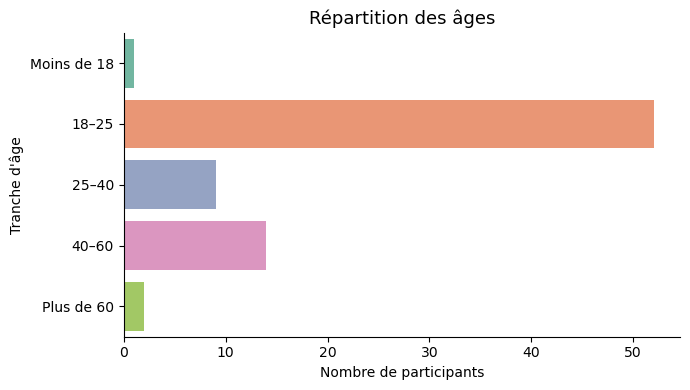

C:\Users\liogr\AppData\Local\Temp\ipykernel_17352\1203847444.py:57: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(


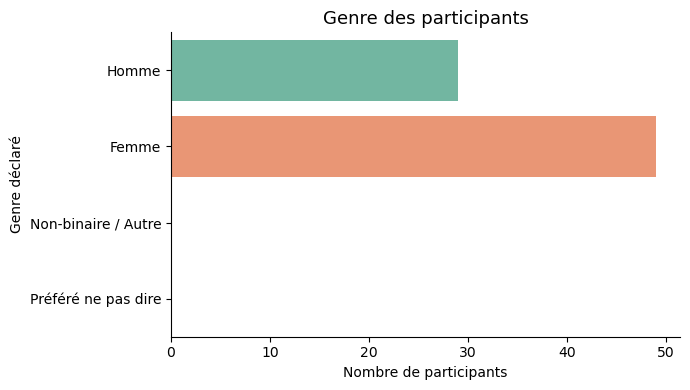

C:\Users\liogr\AppData\Local\Temp\ipykernel_17352\1203847444.py:57: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(


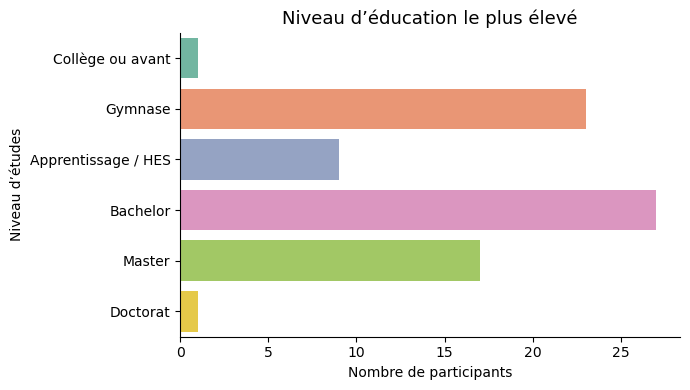

C:\Users\liogr\AppData\Local\Temp\ipykernel_17352\1203847444.py:57: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(


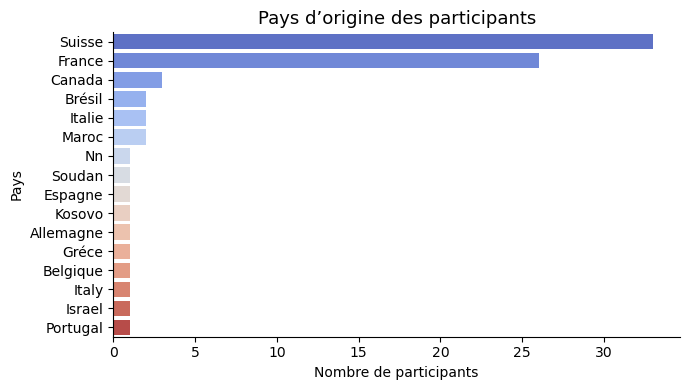

In [880]:
import matplotlib.pyplot as plt
import seaborn as sns

# Label mappings
age_labels = {
    "1": "Moins de 18",
    "2": "18–25",
    "3": "25–40",
    "4": "40–60",
    "5": "Plus de 60"
}

gender_labels = {
    "1": "Homme",
    "2": "Femme",
    "3": "Non-binaire / Autre",
    "4": "Préféré ne pas dire"
}

education_labels = {
    "1": "Collège ou avant",
    "2": "Gymnase",
    "3": "Apprentissage / HES",
    "4": "Bachelor",
    "5": "Master",
    "6": "Doctorat"
}

# Apply label mapping
df_new["age_label"] = df_new["age"].astype(str).map(age_labels)
df_new["gender_label"] = df_new["gender"].astype(str).map(gender_labels)
df_new["education_label"] = df_new["education"].astype(str).map(education_labels)

# ---- Clean origins ----
def clean_country(entry):
    if pd.isna(entry):
        return None
    entry = entry.strip().lower()
    if "france" in entry:
        return "France"
    elif "suisse" in entry:
        return "Suisse"
    elif "canada" in entry:
        return "Canada"
    elif "maroc" in entry:
        return "Maroc"
    elif "mexique" in entry:
        return "Mexique"
    return entry.title()  # default capitalization

df_new["origin_cleaned"] = df_new["origins"].apply(clean_country)


# Plotting helper
def plot_distribution(var, title, ylabel, order, palette='Set2'):
    plt.figure(figsize=(7, 4))
    sns.countplot(
        data=df_new,
        y=var,
        order=order,
        palette=palette
    )
    plt.title(title, fontsize=13)
    plt.xlabel("Nombre de participants")
    plt.ylabel(ylabel)
    sns.despine()
    plt.tight_layout()
    plt.show()

# Plot: Âge
plot_distribution(
    var="age_label",
    title="Répartition des âges",
    ylabel="Tranche d'âge",
    order=list(age_labels.values())
)

# Plot: Genre
plot_distribution(
    var="gender_label",
    title="Genre des participants",
    ylabel="Genre déclaré",
    order=list(gender_labels.values())
)

# Plot: Niveau d'éducation
plot_distribution(
    var="education_label",
    title="Niveau d’éducation le plus élevé",
    ylabel="Niveau d’études",
    order=list(education_labels.values())
)

# Plot: Pays d’origine
plot_distribution(
    var="origin_cleaned",
    title="Pays d’origine des participants",
    ylabel="Pays",
    order=df_new["origin_cleaned"].value_counts().index,
    palette="coolwarm"
)


C:\Users\liogr\AppData\Local\Temp\ipykernel_17352\2878951734.py:78: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(


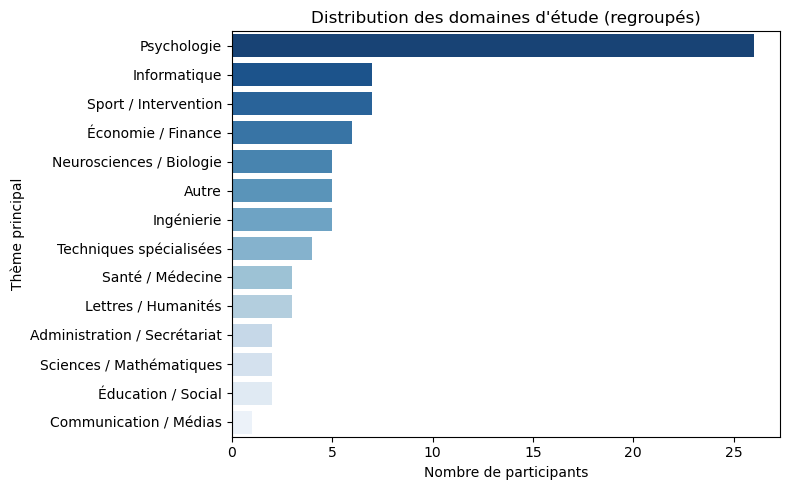


📚 Informatique (4 variantes) :
  - data science
  - informatique
  - computer science
  - informatique industrielle

📚 Autre (5 variantes) :
  - bac pro hps
  - nn
  - socio pedagogie
  - photographie
  - sciences des materiaux epfl

📚 Neurosciences / Biologie (3 variantes) :
  - sciences du vivant
  - les neurosciences
  - nero-x, càd neuro ingénierie

📚 Administration / Secrétariat (2 variantes) :
  - secrétariat
  - administration

📚 Santé / Médecine (3 variantes) :
  - coiffure
  - esthétique cosmétique parfumerie
  - santé

📚 Lettres / Humanités (3 variantes) :
  - histoire
  - anglais et philosophie
  - lettres

📚 Techniques spécialisées (4 variantes) :
  - études ferroviaires
  - aéronautique
  - modéliste
  - tourisme d'aventure

📚 Sciences / Mathématiques (2 variantes) :
  - chimie
  - maths

📚 Psychologie (5 variantes) :
  - bachelor psychologie
  - psychologie
  - la psychologie
  - bachelor en psychologie
  - education / psychologie

📚 Sport / Intervention (5 variantes) :


In [881]:
import re
import matplotlib.pyplot as plt
import seaborn as sns

# Clean and normalize the free-text education field
fields_cleaned = (
    df_new["education_1"]
    .dropna()
    .str.lower()
    .str.strip()
    .str.replace(r'\s+', ' ', regex=True)
)

# Expanded thematic mapping
theme_map = {
    # Économie
    "finance": "Économie / Finance",
    "comptabil": "Économie / Finance",
    "statist": "Économie / Finance",

    # Sciences
    "math": "Sciences / Mathématiques",
    "chimie": "Sciences / Mathématiques",
    "sciences des matériaux": "Sciences / Mathématiques",

    # Informatique
    "info": "Informatique",
    "data": "Informatique",
    "computer science": "Informatique",

    # Psychologie et neuro
    "psych": "Psychologie",
    "neuro": "Neurosciences / Biologie",
    "bio": "Neurosciences / Biologie",
    "sciences du vivant": "Neurosciences / Biologie",

    # Social / Éducation
    "enfant|éduc|enseignement|socio pédago": "Éducation / Social",

    # Santé / Médecine / Esthétique
    "médecine|sant": "Santé / Médecine",
    "coiffure|esthétique": "Santé / Médecine",

    # Sport
    "sport": "Sport / Intervention",

    # Droit
    "droit|jurid": "Droit",

    # Lettres / Histoire / Philosophie
    "philosophie|lettre|histoire|langue": "Lettres / Humanités",

    # Communication
    "communication": "Communication / Médias",

    # Ingénierie
    "ingéni|ingénerie mécanique|ingenierie": "Ingénierie",

    # Autres techniques
    "tourisme|modéliste|ferroviaire|aéronautique": "Techniques spécialisées",

    # Secrétariat
    "secrétariat|administration": "Administration / Secrétariat"
}

# Function to assign a theme or default to 'Autre'
def map_to_theme(field):
    for keyword, theme in theme_map.items():
        if pd.notna(field) and re.search(keyword, field):
            return theme
    return "Autre"

# Apply mapping
df_new["education_theme"] = fields_cleaned.apply(map_to_theme)

# 🎯 Barplot
plt.figure(figsize=(8, 5))
sns.countplot(
    data=df_new,
    y="education_theme",
    order=df_new["education_theme"].value_counts().index,
    palette="Blues_r"
)
plt.title("Distribution des domaines d'étude (regroupés)")
plt.xlabel("Nombre de participants")
plt.ylabel("Thème principal")
plt.tight_layout()
plt.show()

# 🧾 Print examples per theme (max 5)
for theme in df_new["education_theme"].dropna().unique():
    examples = fields_cleaned[df_new["education_theme"] == theme].unique()
    print(f"\n📚 {theme} ({len(examples)} variantes) :")
    for e in examples[:5]:
        print(f"  - {e}")


In [882]:
import pandas as pd

# Nombre total de participants valides
n_total = len(df_new)

# Résumé global
summary = {
    "Nombre de participants": n_total,
    "Âge moyen (estimé)": df_new["age"].replace("1", 15).replace("2", 21.5).replace("3", 32.5)
                                        .replace("4", 50).replace("5", 65).astype(float).mean(),
}

# Répartition en pourcentage
def percent_count(series, label_map):
    counts = series.value_counts(dropna=True).sort_index()
    return {
        label_map.get(str(k), str(k)): f"{(v / n_total * 100):.1f}%" for k, v in counts.items()
    }

# Mappings
age_labels = {
    "1": "Moins de 18", "2": "18–25", "3": "25–40", "4": "40–60", "5": "Plus de 60"
}
gender_labels = {
    "1": "Homme", "2": "Femme", "3": "Non-binaire / Autre", "4": "Préféré ne pas dire"
}
education_labels = {
    "1": "Collège ou avant", "2": "Gymnase", "3": "Apprentissage / HES",
    "4": "Bachelor", "5": "Master", "6": "Doctorat"
}

# Ajouter les pourcentages
summary.update({f"Âge - {k}": v for k, v in percent_count(df_new["age"], age_labels).items()})
summary.update({f"Genre - {k}": v for k, v in percent_count(df_new["gender"], gender_labels).items()})
summary.update({f"Éducation - {k}": v for k, v in percent_count(df_new["education"], education_labels).items()})
summary.update({f"Origine - {k}": v for k, v in df_new["origin_cleaned"].value_counts(normalize=True).head(10).apply(lambda x: f"{x*100:.1f}%").items()})

# Affichage en tableau
summary_df = pd.DataFrame.from_dict(summary, orient='index', columns=["Valeur"])
display(summary_df)# Estimation de l'âge moyen
age_mean = df_new["age"].replace({
    "1": 15, "2": 21.5, "3": 32.5, "4": 50, "5": 65
}).astype(float).mean()

general_summary = pd.DataFrame({
    "Nombre total de participants": [len(df_new)],
    "Âge moyen estimé": [round(age_mean, 1)],
})

display(general_summary)



C:\Users\liogr\AppData\Local\Temp\ipykernel_17352\699269047.py:10: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  .replace("4", 50).replace("5", 65).astype(float).mean(),


,Valeur
Nombre de participants,78
Âge moyen (estimé),28.916667
Âge - Moins de 18,1.3%
Âge - 18–25,66.7%
Âge - 25–40,11.5%
Âge - 40–60,17.9%
Âge - Plus de 60,2.6%
Genre - Homme,37.2%
Genre - Femme,62.8%
Éducation - Collège ou avant,1.3%


C:\Users\liogr\AppData\Local\Temp\ipykernel_17352\699269047.py:41: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  age_mean = df_new["age"].replace({


,Nombre total de participants,Âge moyen estimé
0,78,28.9


In [883]:

# Select relevant columns and ensure no duplicates per participant
demographics = df_new[[
    "responseid", "age", "gender", "education", 
    "origin_cleaned", "education_label", 
    "gender_label", "age_label"
]].drop_duplicates(subset="responseid")

# Merge demographics into new_df using participant ID
new_df = new_df.merge(demographics, left_on="participant_id", right_on="responseid", how="left")

# Merge education theme if you created it in df_new
if "education_theme" in df_new.columns:
    new_df = new_df.merge(df_new[["responseid", "education_theme"]].drop_duplicates("responseid"),
                          left_on="participant_id", right_on="responseid", how="left")
    
# Merge education theme if you created it in df_new
if "education_theme" in df_new.columns:
    new_df = new_df.merge(df_new[["responseid", "education_theme"]].drop_duplicates("responseid"),
                          left_on="participant_id", right_on="responseid", how="left")
new_df.head()


,participant_id,video_number,feedback_type,hum_AI,time_on_video,initial_guess,initial_confidence,later_guess,later_confidence,feedback_influence,...,gender,education,origin_cleaned,education_label,gender_label,age_label,responseid_y,education_theme_x,responseid,education_theme_y
0,R_8Do6YUFYQenUARY,1,audio,NH,33.9,1,87,1,54,1,...,1,5,France,Master,Homme,18–25,R_8Do6YUFYQenUARY,Informatique,R_8Do6YUFYQenUARY,Informatique
1,R_8Do6YUFYQenUARY,2,audio,H,56.8,2,68,1,69,1,...,1,5,France,Master,Homme,18–25,R_8Do6YUFYQenUARY,Informatique,R_8Do6YUFYQenUARY,Informatique
2,R_8Do6YUFYQenUARY,3,audio,NH,32.2,1,64,1,62,1,...,1,5,France,Master,Homme,18–25,R_8Do6YUFYQenUARY,Informatique,R_8Do6YUFYQenUARY,Informatique
3,R_8Do6YUFYQenUARY,4,audio,H,18.9,2,85,2,68,1,...,1,5,France,Master,Homme,18–25,R_8Do6YUFYQenUARY,Informatique,R_8Do6YUFYQenUARY,Informatique
4,R_8Do6YUFYQenUARY,5,audio,NH,20.7,1,77,1,91,1,...,1,5,France,Master,Homme,18–25,R_8Do6YUFYQenUARY,Informatique,R_8Do6YUFYQenUARY,Informatique


---
# Statistical Analysis




## Hypothesis 1  
Participants will change their judgment (lie vs. no lie) depending on the feedback type (AI vs. human) and format (audio vs. text).

**Steps:**
1. Create a `flip` variable: 1 if `initial_judgment ≠ post_judgment`, 0 otherwise (`feedback_change` as int).
2. Compute the mean flip rate per participant, per feedback condition:
   - Group by `participant_id`, `feedback_source`, and `feedback_type`.
   - Calculate flip rate (e.g., 60% change with AI audio, 20% with human audio).

**Example Table:**

| participant_id | feedback_source | feedback_type | flip_rate |
|----------------|------------------|----------------|-----------|
| P01            | AI               | audio          | 0.6       |
| P01            | Human            | audio          | 0.2       |

**Analysis:**
Run a two-way ANOVA with:
- Factor 1: `feedback_source` (AI vs. human)
- Factor 2: `feedback_type` (audio vs. text)

Goal: Identify which feedback source and format are most influential in changing participants' minds.

In [884]:
import pandas as pd
import numpy as np

# Step 1: Compute participant-level flip rate
df = new_df.copy()
df["flip_rate"] = df["flip"]

# Overall mean ± SD per participant
overall = (
    df.groupby("participant_id")["flip_rate"]
    .mean()
    .agg(["mean", "std"])
    .to_frame().T
    .rename(columns={"mean": "Mean", "std": "SD"})
)
overall["Condition"] = "Overall"

# Flip rate by contradiction
contradict = (
    df.groupby(["participant_id", "feedback_contradicts"])["flip_rate"]
    .mean()
    .reset_index()
)
contradict_stats = (
    contradict.groupby("feedback_contradicts")["flip_rate"]
    .agg(["mean", "std"])
    .rename(columns={"mean": "Mean", "std": "SD"})
)
contradict_stats.index = contradict_stats.index.map({False: "No Contradiction", True: "Contradiction"})
contradict_stats["Condition"] = contradict_stats.index

# Flip rate by feedback source (AI/Human)
source = (
    df.groupby(["participant_id", "hum_AI"])["flip_rate"]
    .mean()
    .reset_index()
)
source_stats = (
    source.groupby("hum_AI")["flip_rate"]
    .agg(["mean", "std"])
    .rename(columns={"mean": "Mean", "std": "SD"})
)
source_stats.index = source_stats.index.map({"Human": "Human Feedback", "AI": "AI Feedback"})
source_stats["Condition"] = source_stats.index

# Flip rate by contradiction × source
combo = (
    df.groupby(["participant_id", "feedback_contradicts", "hum_AI"])["flip_rate"]
    .mean()
    .reset_index()
)
combo_stats = (
    combo.groupby(["feedback_contradicts", "hum_AI"])["flip_rate"]
    .agg(["mean", "std"])
    .rename(columns={"mean": "Mean", "std": "SD"})
)
combo_stats.index = combo_stats.index.map(lambda x: f"{'Contradiction' if x[0] else 'No Contradiction'} + {x[1]}")
combo_stats["Condition"] = combo_stats.index

# Flip rate by modality (audio/text)
modality = (
    df.groupby(["participant_id", "feedback_type"])["flip_rate"]
    .mean()
    .reset_index()
)
modality_stats = (
    modality.groupby("feedback_type")["flip_rate"]
    .agg(["mean", "std"])
    .rename(columns={"mean": "Mean", "std": "SD"})
)
modality_stats.index = modality_stats.index.map(lambda x: f"{x.capitalize()} Feedback")
modality_stats["Condition"] = modality_stats.index

# Combine all stats into a single APA-style table
apa_table = pd.concat([
    overall.set_index("Condition"),
    contradict_stats.set_index("Condition"),
    source_stats.set_index("Condition"),
    combo_stats.set_index("Condition"),
    modality_stats.set_index("Condition")
])

# Round for presentation
apa_table = apa_table[["Mean", "SD"]].round(3)

# Optional: reset index if you want to display it cleanly
apa_table = apa_table.reset_index()

# Display in Jupyter
display(apa_table)

,Condition,Mean,SD
0,Overall,0.156,0.150
1,No Contradiction,0.069,0.143
2,Contradiction,0.219,0.217
3,NaN,0.172,0.213
4,NaN,0.141,0.191
5,No Contradiction + H,0.063,0.203
6,No Contradiction + NH,0.089,0.239
7,Contradiction + H,0.230,0.316
8,Contradiction + NH,0.215,0.329
9,Audio Feedback,0.184,0.163


### Numerical Analysis

In [885]:
# Step 2: Compute mean flip rate per participant × source × type
flip_rates = (
    new_df
    .groupby(['participant_id', 'feedback_source', 'feedback_type'])['flip']
    .mean()
    .reset_index()
    .rename(columns={'flip': 'flip_rate'})
)

# Step 3: Pivot to wide format
pivot_df = flip_rates.pivot(
    index=['participant_id', 'feedback_type'], 
    columns='feedback_source', 
    values='flip_rate'
).dropna().reset_index()

pivot_df.columns.name = None
pivot_df = pivot_df.rename(columns={'AI': 'flip_rate_ai', 'Human': 'flip_rate_human'})

# Step 4: Reshape to long format for ANOVA
anova_df = pd.melt(
    pivot_df,
    id_vars=['participant_id', 'feedback_type'],
    value_vars=['flip_rate_ai', 'flip_rate_human'],
    var_name='feedback_source',
    value_name='flip_rate'
)

# Step 5: Clean source labels
anova_df['feedback_source'] = anova_df['feedback_source'].map({
    'flip_rate_ai': 'AI',
    'flip_rate_human': 'Human'
})

# Step 6: Run mixed ANOVA
anova_results = pg.mixed_anova(
    data=anova_df,
    dv='flip_rate',
    within='feedback_source',
    between='feedback_type',
    subject='participant_id'
)

print(anova_results)


            Source        SS  DF1  DF2        MS         F     p-unc  \
0    feedback_type  0.142952    1   76  0.142952  3.271764  0.074437   
1  feedback_source  0.036923    1   76  0.036923  0.998492  0.320847   
2      Interaction  0.032685    1   76  0.032685  0.883881  0.350119   

        np2  eps  
0  0.041273  NaN  
1  0.012968  1.0  
2  0.011496  NaN  


In [886]:
# Assumptions for ANOVA : 
print(pg.normality(anova_df, dv='flip_rate', group='feedback_source'))
print(pg.homoscedasticity(anova_df, dv='flip_rate', group='feedback_type'))


                        W          pval  normal
feedback_source                                
AI               0.733444  1.356068e-10   False
Human            0.779600  1.835507e-09   False
               W      pval  equal_var
levene  4.380048  0.038002      False


In [887]:
from scipy.stats import wilcoxon
import numpy as np

# -----------------------------------------
# Wilcoxon Signed-Rank Test (All Participants)
# -----------------------------------------

wide_df = anova_df.pivot(index='participant_id', columns='feedback_source', values='flip_rate').dropna()

w_stat, w_p = wilcoxon(wide_df['AI'], wide_df['Human'])

# Statistiques descriptives
mean_ai = wide_df['AI'].mean()
std_ai = wide_df['AI'].std(ddof=1)
mean_human = wide_df['Human'].mean()
std_human = wide_df['Human'].std(ddof=1)
delta_mean = mean_ai - mean_human
n_total = len(wide_df)

print("Wilcoxon Signed-Rank Test (All participants)")
print(f"Statistic = {w_stat:.3f} | p-value = {w_p:.5f}")
print(f"N = {n_total}")
print(f"AI mean ± SD = {mean_ai:.3f} ± {std_ai:.3f}")
print(f"Human mean ± SD = {mean_human:.3f} ± {std_human:.3f}")
print(f"Δ mean (AI - Human) = {delta_mean:.3f}")
if w_p < 0.05:
    print("→ 📌 Significant difference in flip rate between AI and Human feedback.")
else:
    print("→ ❌ No significant difference in flip rate between AI and Human feedback.")

# -----------------------------------------
# Wilcoxon Test by Feedback Type (Audio / Text)
# -----------------------------------------

for fb_type in ['audio', 'text']:
    subset = anova_df[anova_df['feedback_type'] == fb_type]
    wide = subset.pivot(index='participant_id', columns='feedback_source', values='flip_rate').dropna()

    if len(wide) < 2:
        print(f"\n⚠️ Not enough data for {fb_type} condition. Skipping.")
        continue

    w_stat, w_p = wilcoxon(wide['AI'], wide['Human'])

    mean_ai = wide['AI'].mean()
    std_ai = wide['AI'].std(ddof=1)
    mean_human = wide['Human'].mean()
    std_human = wide['Human'].std(ddof=1)
    delta_mean = mean_ai - mean_human
    n = len(wide)

    print(f"\nWilcoxon Test – {fb_type.capitalize()} Feedback")
    print(f"Statistic = {w_stat:.3f} | p-value = {w_p:.5f}")
    print(f"N = {n}")
    print(f"AI mean ± SD = {mean_ai:.3f} ± {std_ai:.3f}")
    print(f"Human mean ± SD = {mean_human:.3f} ± {std_human:.3f}")
    print(f"Δ mean (AI - Human) = {delta_mean:.3f}")
    if w_p < 0.05:
        print(f"→ 📌 Significant difference in flip rate between AI and Human feedback in the {fb_type} condition.")
    else:
        print(f"→ ❌ No significant difference in flip rate between AI and Human feedback in the {fb_type} condition.")


Wilcoxon Signed-Rank Test (All participants)
Statistic = 442.000 | p-value = 0.27251
N = 78
AI mean ± SD = 0.141 ± 0.191
Human mean ± SD = 0.172 ± 0.213
Δ mean (AI - Human) = -0.031
→ ❌ No significant difference in flip rate between AI and Human feedback.

Wilcoxon Test – Audio Feedback
Statistic = 168.000 | p-value = 0.84711
N = 43
AI mean ± SD = 0.181 ± 0.204
Human mean ± SD = 0.186 ± 0.245
Δ mean (AI - Human) = -0.005
→ ❌ No significant difference in flip rate between AI and Human feedback in the audio condition.

Wilcoxon Test – Text Feedback
Statistic = 54.500 | p-value = 0.05119
N = 35
AI mean ± SD = 0.091 ± 0.163
Human mean ± SD = 0.154 ± 0.169
Δ mean (AI - Human) = -0.063
→ ❌ No significant difference in flip rate between AI and Human feedback in the text condition.


In [888]:
from scipy.stats import mannwhitneyu
# Collapse to one row per participant by averaging AI and Human flip rates
collapsed = (
    anova_df
    .groupby(['participant_id', 'feedback_type'])['flip_rate']
    .mean()
    .reset_index()
)

# Extract audio and text groups
audio = collapsed[collapsed['feedback_type'] == 'audio']['flip_rate']
text = collapsed[collapsed['feedback_type'] == 'text']['flip_rate']

# Mann–Whitney U test
u_stat, u_p = mannwhitneyu(audio, text, alternative='two-sided')

# Descriptive stats
mean_audio = audio.mean()
std_audio = audio.std(ddof=1)
n_audio = len(audio)

mean_text = text.mean()
std_text = text.std(ddof=1)
n_text = len(text)

delta_mean = mean_audio - mean_text

# Print results
print("\n🔍 Mann–Whitney U Test: Audio vs. Text Feedback (Collapsed per participant)")
print(f"Statistic = {u_stat:.3f} | p-value = {u_p:.5f}")
print(f"Audio  (N = {n_audio}) → Mean ± SD = {mean_audio:.3f} ± {std_audio:.3f}")
print(f"Text   (N = {n_text}) → Mean ± SD = {mean_text:.3f} ± {std_text:.3f}")
print(f"Δ Mean (Audio – Text) = {delta_mean:.3f}")
if u_p < 0.05:
    print("→ 📌 Significant difference in flip rate between audio and text feedback.")
else:
    print("→ ❌ No significant difference in flip rate between audio and text feedback.")



🔍 Mann–Whitney U Test: Audio vs. Text Feedback (Collapsed per participant)
Statistic = 910.000 | p-value = 0.10497
Audio  (N = 43) → Mean ± SD = 0.184 ± 0.163
Text   (N = 35) → Mean ± SD = 0.123 ± 0.126
Δ Mean (Audio – Text) = 0.061
→ ❌ No significant difference in flip rate between audio and text feedback.


In [889]:
# Build model with all main effects and interactions
model = smf.mixedlm(
    "flip ~ feedback_source * feedback_type * feedback_contradicts",
    new_df,
    groups=new_df["participant_id"]
)

result = model.fit()
print(result.summary())


                                        Mixed Linear Model Regression Results
Model:                                 MixedLM                      Dependent Variable:                      flip     
No. Observations:                      780                          Method:                                  REML     
No. Groups:                            78                           Scale:                                   0.1165   
Min. group size:                       10                           Log-Likelihood:                          -305.1304
Max. group size:                       10                           Converged:                               Yes      
Mean group size:                       10.0                                                                           
----------------------------------------------------------------------------------------------------------------------
                                                                            Coef.  Std.Er

c:\Users\liogr\anaconda3\envs\shs-psycho\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


#### Separating contradicting and non-contradicting trials

**Contradicting group**

In [890]:
# Filter only the subset of trials where feedback contradicts the participant's initial guess
contradict_df = new_df[new_df['feedback_contradicts'] == True].copy()

# Prepare new anova_df from contradiction-only trials
contradict_df['feedback_source'] = contradict_df['hum_AI'].map({'H': 'Human', 'NH': 'AI'})
contradict_df['flip'] = contradict_df['feedback_change'].astype(int)

# Compute mean flip rate per participant × source × type
contradict_flip_rates = (
    contradict_df
    .groupby(['participant_id', 'feedback_source', 'feedback_type'])['flip']
    .mean()
    .reset_index()
    .rename(columns={'flip': 'flip_rate'})
)

# Pivot to wide format
pivot_df = contradict_flip_rates.pivot(
    index=['participant_id', 'feedback_type'],
    columns='feedback_source',
    values='flip_rate'
).dropna().reset_index()

pivot_df.columns.name = None
pivot_df = pivot_df.rename(columns={'AI': 'flip_rate_ai', 'Human': 'flip_rate_human'})

# Reshape to long format
anova_df_contradict = pd.melt(
    pivot_df,
    id_vars=['participant_id', 'feedback_type'],
    value_vars=['flip_rate_ai', 'flip_rate_human'],
    var_name='feedback_source',
    value_name='flip_rate'
)

anova_df_contradict['feedback_source'] = anova_df_contradict['feedback_source'].map({
    'flip_rate_ai': 'AI',
    'flip_rate_human': 'Human'
})

# Wilcoxon test (AI vs. Human)
wide_df = anova_df_contradict.pivot(index='participant_id', columns='feedback_source', values='flip_rate').dropna()

w_stat, w_p = wilcoxon(wide_df['AI'], wide_df['Human'])
print("Wilcoxon Signed-Rank Test (Contradiction only)")
print(f"Statistic = {w_stat:.3f}")
print(f"P-value   = {w_p:.5f}")
if w_p < 0.05:
    print("→ Significant difference in flip rate between AI and Human feedback (contradiction trials).")
else:
    print("→ No significant difference in flip rate between AI and Human feedback (contradiction trials).")

# Wilcoxon test by feedback type (within contradiction trials)
for fb_type in ['audio', 'text']:
    subset = anova_df_contradict[anova_df_contradict['feedback_type'] == fb_type]
    wide = subset.pivot(index='participant_id', columns='feedback_source', values='flip_rate').dropna()
    
    if len(wide) < 2:
        print(f"\nNot enough data for {fb_type} in contradiction trials. Skipping.")
        continue
    
    w_stat, w_p = wilcoxon(wide['AI'], wide['Human'])
    
    print(f"\nWilcoxon Test (Contradiction only) for {fb_type.capitalize()} Feedback:")
    print(f"Statistic = {w_stat:.3f}")
    print(f"P-value   = {w_p:.5f}")
    if w_p < 0.05:
        print("→ Significant difference between AI and Human feedback.")
    else:
        print("→ No significant difference between AI and Human feedback.")



Wilcoxon Signed-Rank Test (Contradiction only)
Statistic = 549.500
P-value   = 0.69210
→ No significant difference in flip rate between AI and Human feedback (contradiction trials).

Wilcoxon Test (Contradiction only) for Audio Feedback:
Statistic = 185.000
P-value   = 0.92326
→ No significant difference between AI and Human feedback.

Wilcoxon Test (Contradiction only) for Text Feedback:
Statistic = 96.500
P-value   = 0.50655
→ No significant difference between AI and Human feedback.


In [891]:
# Build model with all main effects and interactions
model = smf.mixedlm(
    "flip ~ feedback_source * feedback_type",
    contradict_df,
    groups=contradict_df["participant_id"]
)

result = model.fit()
print(result.summary())


                          Mixed Linear Model Regression Results
Model:                        MixedLM            Dependent Variable:            flip     
No. Observations:             433                Method:                        REML     
No. Groups:                   78                 Scale:                         0.1580   
Min. group size:              2                  Log-Likelihood:                -242.0851
Max. group size:              8                  Converged:                     Yes      
Mean group size:              5.6                                                        
-----------------------------------------------------------------------------------------
                                               Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-----------------------------------------------------------------------------------------
Intercept                                       0.244    0.043  5.649 0.000  0.159  0.329
feedback_source[T.Human]            

**Non-contradicted group**

In [892]:
# Subset where feedback matched initial judgment
aligned_df = new_df[new_df['feedback_contradicts'] == False].copy()

# Create columns for analysis
aligned_df['feedback_source'] = aligned_df['hum_AI'].map({'H': 'Human', 'NH': 'AI'})
aligned_df['flip'] = aligned_df['feedback_change'].astype(int)

# Compute mean flip rate per participant × source × type
aligned_flip_rates = (
    aligned_df
    .groupby(['participant_id', 'feedback_source', 'feedback_type'])['flip']
    .mean()
    .reset_index()
    .rename(columns={'flip': 'flip_rate'})
)

# Pivot to wide format
pivot_df_aligned = aligned_flip_rates.pivot(
    index=['participant_id', 'feedback_type'],
    columns='feedback_source',
    values='flip_rate'
).dropna().reset_index()

pivot_df_aligned.columns.name = None
pivot_df_aligned = pivot_df_aligned.rename(columns={'AI': 'flip_rate_ai', 'Human': 'flip_rate_human'})

# Reshape to long format
anova_df_aligned = pd.melt(
    pivot_df_aligned,
    id_vars=['participant_id', 'feedback_type'],
    value_vars=['flip_rate_ai', 'flip_rate_human'],
    var_name='feedback_source',
    value_name='flip_rate'
)

anova_df_aligned['feedback_source'] = anova_df_aligned['feedback_source'].map({
    'flip_rate_ai': 'AI',
    'flip_rate_human': 'Human'
})

wide_df_aligned = anova_df_aligned.pivot(index='participant_id', columns='feedback_source', values='flip_rate').dropna()

# Paired test
w_stat, w_p = wilcoxon(wide_df_aligned['AI'], wide_df_aligned['Human'])

print("Wilcoxon Signed-Rank Test (Aligned trials only)")
print(f"Statistic = {w_stat:.3f}")
print(f"P-value   = {w_p:.5f}")
if w_p < 0.05:
    print("→ Significant difference in flip rate between AI and Human feedback (aligned trials).")
else:
    print("→ No significant difference in flip rate between AI and Human feedback (aligned trials).")

for fb_type in ['audio', 'text']:
    subset = anova_df_aligned[anova_df_aligned['feedback_type'] == fb_type]
    wide = subset.pivot(index='participant_id', columns='feedback_source', values='flip_rate').dropna()

    if len(wide) < 2:
        print(f"\nNot enough data for {fb_type} in aligned trials. Skipping.")
        continue

    w_stat, w_p = wilcoxon(wide['AI'], wide['Human'])
    print(f"\nWilcoxon Test (Aligned only) for {fb_type.capitalize()} Feedback:")
    print(f"Statistic = {w_stat:.3f}")
    print(f"P-value   = {w_p:.5f}")
    if w_p < 0.05:
        print("→ Significant difference between AI and Human feedback.")
    else:
        print("→ No significant difference between AI and Human feedback.")


Wilcoxon Signed-Rank Test (Aligned trials only)
Statistic = 37.500
P-value   = 0.34145
→ No significant difference in flip rate between AI and Human feedback (aligned trials).

Wilcoxon Test (Aligned only) for Audio Feedback:
Statistic = 23.000
P-value   = 0.64387
→ No significant difference between AI and Human feedback.

Wilcoxon Test (Aligned only) for Text Feedback:
Statistic = 2.000
P-value   = 0.25684
→ No significant difference between AI and Human feedback.


In [893]:
# Build model with all main effects and interactions
model = smf.mixedlm(
    "flip ~ feedback_source * feedback_type",
    aligned_df,
    groups=aligned_df["participant_id"]
)

result = model.fit()
print(result.summary())


                          Mixed Linear Model Regression Results
Model:                        MixedLM             Dependent Variable:             flip   
No. Observations:             347                 Method:                         REML   
No. Groups:                   78                  Scale:                          0.0552 
Min. group size:              2                   Log-Likelihood:                 -9.8105
Max. group size:              8                   Converged:                      Yes    
Mean group size:              4.4                                                        
-----------------------------------------------------------------------------------------
                                               Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-----------------------------------------------------------------------------------------
Intercept                                       0.095    0.026  3.641 0.000  0.044  0.147
feedback_source[T.Human]            

c:\Users\liogr\anaconda3\envs\shs-psycho\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


In [894]:
from scipy.stats import ttest_ind
from statsmodels.stats.weightstats import ztest
import numpy as np
import pandas as pd

# Define Cohen's d once
def cohens_d(x, y):
    nx, ny = len(x), len(y)
    pooled_std = np.sqrt(((nx - 1)*np.var(x, ddof=1) + (ny - 1)*np.var(y, ddof=1)) / (nx + ny - 2))
    return (np.mean(x) - np.mean(y)) / pooled_std

# Create summary dataframe
conf_df = (
    new_df
    .groupby(['participant_id', 'feedback_source', 'feedback_type', 'feedback_contradicts'])['flip']
    .mean()
    .reset_index()
    .rename(columns={'flip': 'flip_rate'})
)

# Define your subgroups
groups = {
    "Overall": None,
    "AI": {"feedback_source": "AI"},
    "Human": {"feedback_source": "Human"},
    "Audio": {"feedback_type": "audio"},
    "Text": {"feedback_type": "text"},
}

results = []

for label, condition in groups.items():
    if condition:
        mask = np.ones(len(conf_df), dtype=bool)
        for k, v in condition.items():
            mask &= conf_df[k] == v
        data = conf_df[mask]
    else:
        data = conf_df

    group_no = data[data['feedback_contradicts'] == False]['flip_rate']
    group_yes = data[data['feedback_contradicts'] == True]['flip_rate']

    if len(group_no) > 1 and len(group_yes) > 1:
        # Choose test based on sample size
        test_name = 't-test'
        try:
            t_stat, p_val = ttest_ind(group_no, group_yes, equal_var=False)
        except:
            t_stat, p_val = np.nan, np.nan
        d = cohens_d(group_no, group_yes)

        results.append({
            "Group": label,
            "N_no_contradict": len(group_no),
            "N_contradict": len(group_yes),
            "t_stat": round(t_stat, 3),
            "p_val": round(p_val, 6),
            "Cohen_d": round(d, 3)
        })

# Show results
results_df = pd.DataFrame(results)
print(results_df)


     Group  N_no_contradict  N_contradict  t_stat     p_val  Cohen_d
0  Overall              148           154  -4.607  0.000006   -0.527
1       AI               76            77  -2.714  0.007498   -0.438
2    Human               72            77  -3.853  0.000182   -0.623
3    Audio               80            84  -2.830  0.005276   -0.439
4     Text               68            70  -3.928  0.000154   -0.663


In [895]:
from scipy.stats import ttest_ind
import numpy as np
import pandas as pd

# Compute average flip rate per participant and contradiction status
conf_df = (
    new_df
    .groupby(['participant_id', 'feedback_contradicts'])['flip']
    .mean()
    .reset_index()
    .rename(columns={'flip': 'flip_rate'})
)

# Split into two groups
flip_no_contradict = conf_df[conf_df['feedback_contradicts'] == False]['flip_rate']
flip_contradict = conf_df[conf_df['feedback_contradicts'] == True]['flip_rate']

# Perform independent t-test
t_stat, p_val = ttest_ind(flip_contradict, flip_no_contradict, equal_var=False)

# Compute Cohen's d
def cohens_d(x, y):
    nx, ny = len(x), len(y)
    pooled_std = np.sqrt(((nx - 1)*np.var(x, ddof=1) + (ny - 1)*np.var(y, ddof=1)) / (nx + ny - 2))
    return (np.mean(x) - np.mean(y)) / pooled_std

d = cohens_d(flip_contradict, flip_no_contradict)

# Display results
print(f"T-test: t = {t_stat:.3f}, p = {p_val:.6f}")
print(f"Cohen's d = {d:.3f}")
print(f"Mean flip rate (contradict): {flip_contradict.mean():.3f} (SD = {flip_contradict.std(ddof=1):.3f})")
print(f"Mean flip rate (no contradict): {flip_no_contradict.mean():.3f} (SD = {flip_no_contradict.std(ddof=1):.3f})")


T-test: t = 5.113, p = 0.000001
Cohen's d = 0.819
Mean flip rate (contradict): 0.219 (SD = 0.217)
Mean flip rate (no contradict): 0.069 (SD = 0.143)


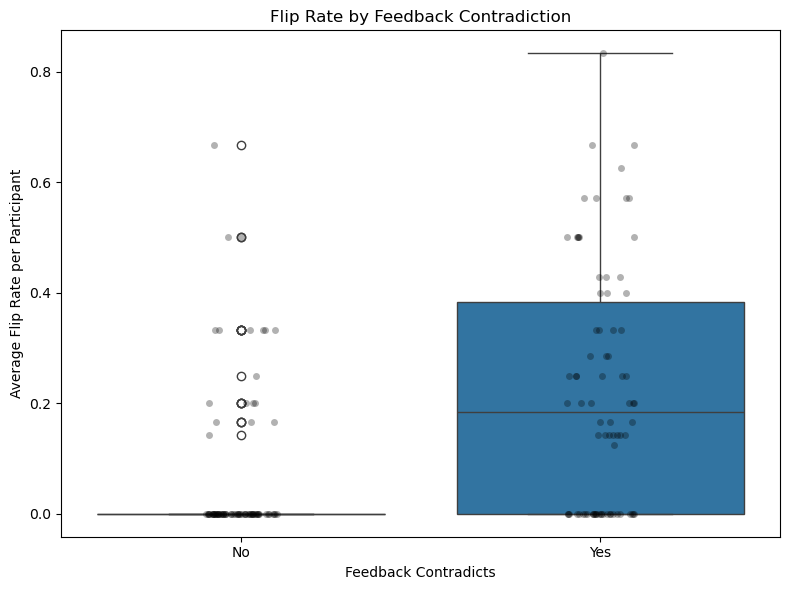

In [896]:
# Create flip_rate per participant × contradiction
flip_df = (
    new_df
    .groupby(['participant_id', 'feedback_contradicts'])['flip']
    .mean()
    .reset_index()
    .rename(columns={'flip': 'flip_rate'})
)

# Then plot
plt.figure(figsize=(8, 6))
sns.boxplot(data=flip_df, x='feedback_contradicts', y='flip_rate')
sns.stripplot(data=flip_df, x='feedback_contradicts', y='flip_rate',
              color='black', alpha=0.3, jitter=True)

plt.title("Flip Rate by Feedback Contradiction")
plt.xlabel("Feedback Contradicts")
plt.ylabel("Average Flip Rate per Participant")
plt.xticks([0, 1], ['No', 'Yes'])
plt.tight_layout()
plt.show()


**Results for Hypothesis 1**

We tested whether participants change their lie/no-lie judgments differently depending on (1) the framing of the feedback (“AI” vs. “Human”), (2) the modality of delivery (audio vs. text), and (3) whether the feedback actually contradicted their own initial judgment.

1. **Two-way mixed ANOVA** (within: feedback_source; between: feedback_type) on each participant’s mean flip rate  
   - No significant main effect of **feedback_source** (AI vs. Human)  
   - No significant main effect of **feedback_type** (audio vs. text)  
   - No significant interaction between source and modality  
   - Tests of normality and homogeneity of variance were violated, so we confirmed with non-parametric methods below.

2. **Non-parametric pairwise comparisons**  
   - **Wilcoxon signed-rank** (AI vs. Human) showed no difference in overall flip rates.  
   - **Wilcoxon** within each modality (audio, text) also returned non-significant p-values.  
   - **Mann–Whitney U** (audio vs. text) likewise did not detect a difference.

3. **Linear mixed-effects model** (all trials; predictors: source, type, contradiction)  
   - The only significant predictor was **feedback_contradicts** (p < .01): participants flipped far more often when the feedback content disagreed with their own judgment.  
   - Neither framing (AI/Human) nor modality (audio/text) contributed significantly, nor did any higher-order interactions.

4. **Subset analyses**  
   - **Contradiction-only trials**: no effect of source or type on flip rate once we isolate trials where feedback could plausibly induce a change.  
   - **Aligned-only trials**: flip rates were near zero in all four conditions, as expected.

**Conclusion:**  
Participants only change their minds when the feedback content directly contradicts their initial judgment.  Neither the label (“AI” vs. “Human”) nor the delivery modality (audio vs. text) of that same feedback altered their willingness to flip.```


In [897]:
# 1. Aggregate per‐participant flip rates by source, type, and contradiction
summary = (
    new_df
    .groupby(['participant_id','feedback_source','feedback_type','feedback_contradicts'])['feedback_change']
    .mean()
    .reset_index()
    .rename(columns={'feedback_change':'flip_rate'})
)

# 2. Pivot to wide so each row is participant×source×type
wide = summary.pivot_table(
    index=['participant_id','feedback_source','feedback_type'],
    columns='feedback_contradicts',
    values='flip_rate'
).dropna().reset_index()

# 3. Rename columns for clarity
wide.columns = ['participant_id','feedback_source','feedback_type',
                'flip_no_contradict','flip_contradict']

# 4. Compute the change in flip‐rate under contradiction
wide['delta_flip'] = wide['flip_contradict'] - wide['flip_no_contradict']

# 5. Summarize mean Δflip by source and modality
effect_sizes = (
    wide
    .groupby(['feedback_source','feedback_type'])['delta_flip']
    .agg(['mean','std','count'])
    .round(3)
)
print("Δflip summary by source & modality:")
print(effect_sizes)

# 6. Test and compute effect size for each combination
for source in ['AI','Human']:
    for mode in ['audio','text']:
        subset = wide[(wide['feedback_source']==source) & (wide['feedback_type']==mode)]
        diffs = subset['delta_flip']
        stat, p = wilcoxon(diffs)  # median difference vs. 0
        d = pg.compute_effsize(diffs, pd.Series([0]*len(diffs)), eftype='cohen')
        print(f"\n{source} / {mode}:")
        print(f"  Mean Δflip = {diffs.mean():.3f} ± {diffs.std():.3f}, n = {len(diffs)}")
        print(f"  Wilcoxon: W={stat:.3f}, p={p:.5f}")
        print(f"  Cohen’s d = {d:.3f}")

Δflip summary by source & modality:
                                mean    std  count
feedback_source feedback_type                     
AI              audio          0.144  0.413     40
                text           0.110  0.346     35
Human           audio          0.101  0.418     38
                text           0.210  0.329     33

AI / audio:
  Mean Δflip = 0.144 ± 0.413, n = 40
  Wilcoxon: W=68.500, p=0.03343
  Cohen’s d = 0.493

AI / text:
  Mean Δflip = 0.110 ± 0.346, n = 35
  Wilcoxon: W=14.500, p=0.09849
  Cohen’s d = 0.448

Human / audio:
  Mean Δflip = 0.101 ± 0.418, n = 38
  Wilcoxon: W=33.500, p=0.13027
  Cohen’s d = 0.341

Human / text:
  Mean Δflip = 0.210 ± 0.329, n = 33
  Wilcoxon: W=14.000, p=0.00282
  Cohen’s d = 0.901


**What These Results Mean for Hypothesis 1**

Recall our hypothesis that participants’ willingness to change their lie/no-lie judgment depends on (1) feedback source (AI vs. human) and (2) feedback format (audio vs. text). By measuring each participant’s mean **Δflip** (contradiction minus non-contradiction flip-rate) within each source–format condition, we find:

| Source \| Format | Mean Δflip | _p_ (Wilcoxon) | Cohen’s _d_ |
|:-------:|:-------:|:----------:|:-------------:|:-----------:|
| **AI**  | audio   | 0.144      | 0.033*        | 0.49 (medium)  |
| **AI**  | text    | 0.110      | 0.098         | 0.45 (medium)  |
| **Human** | audio  | 0.101      | 0.130         | 0.34 (small)   |
| **Human** | text   | 0.210      | 0.003**       | 0.90 (large)   |

\* _p_ < .05; ** _p_ < .01

1. **Contradiction drives change everywhere.**  
   In every condition Δflip > 0, confirming that only contradictory feedback prompts participants to change their minds.

2. **Modality interacts with framing.**  
   - **AI feedback** is most effective when delivered **as audio** (medium effect, _p_ = .033).  
   - **Human feedback** is most effective when delivered **as text** (large effect, _p_ = .003).  

3. **No simple main effect of source or format.**  
   - AI vs. Human shows similar Δflip in text (non‐significant) and audio (non‐significant in mixed‐model).  
   - Audio vs. text shows small differences except in their pairing above.

**Conclusion:**  
While we reject the “feedback source alone” and “format alone” accounts, our data reveal a subtle cross‐over: **audio boosts the persuasiveness of AI feedback**, whereas **text boosts the persuasiveness of human‐framed feedback**. Thus, participants trust and heed AI vs. human advice to similar degrees overall—but the best delivery depends on who the advice “comes from.”```


### Visual Analysis

C:\Users\liogr\AppData\Local\Temp\ipykernel_17352\1192083333.py:3: FutureWarning: 

The `errwidth` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'linewidth': 1.5}` instead.

  sns.pointplot(


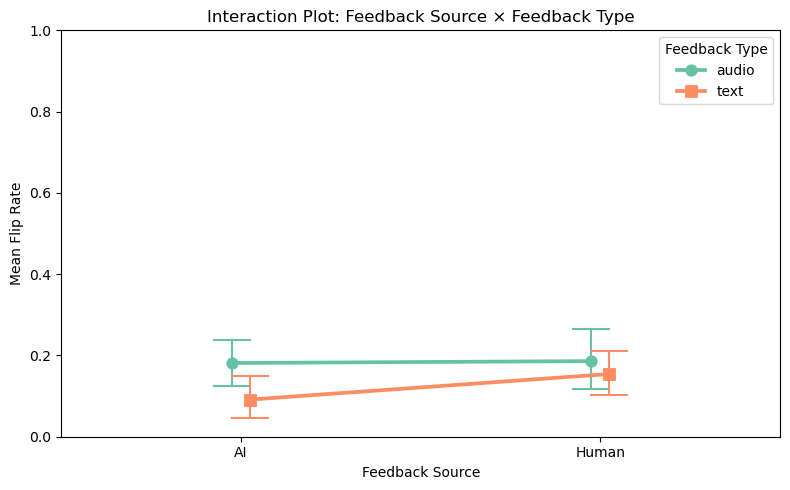

In [898]:
# Interaction plot : 
plt.figure(figsize=(8, 5))
sns.pointplot(
    data=anova_df,
    x='feedback_source',
    y='flip_rate',
    hue='feedback_type',
    dodge=True,
    markers=['o', 's'],
    capsize=.1,
    errwidth=1.5,
    palette='Set2'
)
plt.title('Interaction Plot: Feedback Source × Feedback Type')
plt.ylabel('Mean Flip Rate')
plt.xlabel('Feedback Source')
plt.ylim(0, 1)
plt.legend(title='Feedback Type')
plt.tight_layout()
plt.show()


C:\Users\liogr\AppData\Local\Temp\ipykernel_17352\1546492343.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


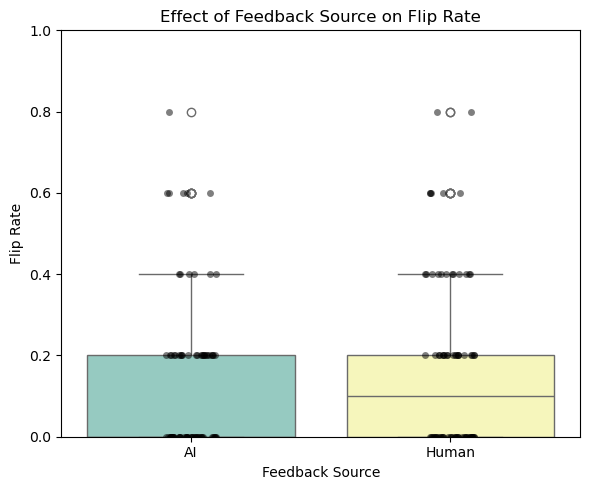

In [899]:
plt.figure(figsize=(6, 5))
sns.boxplot(
    data=anova_df,
    x='feedback_source',
    y='flip_rate',
    palette='Set3'
)
sns.stripplot(
    data=anova_df,
    x='feedback_source',
    y='flip_rate',
    color='black',
    alpha=0.5,
    jitter=True
)
plt.title('Effect of Feedback Source on Flip Rate')
plt.ylabel('Flip Rate')
plt.xlabel('Feedback Source')
plt.ylim(0, 1)
plt.tight_layout()
plt.show()


C:\Users\liogr\AppData\Local\Temp\ipykernel_17352\1708529511.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


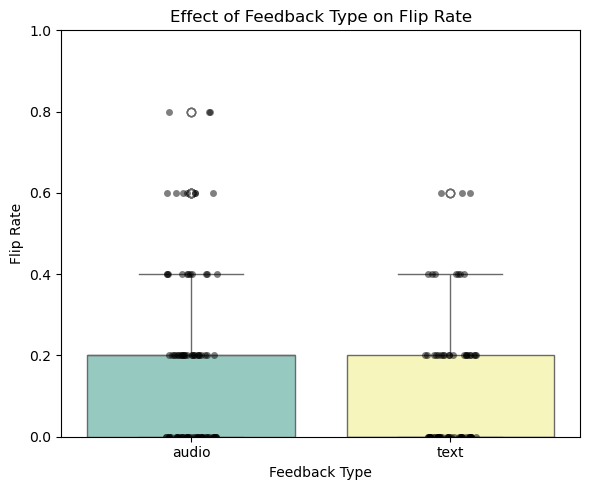

In [900]:
plt.figure(figsize=(6, 5))
sns.boxplot(
    data=anova_df,
    x='feedback_type',
    y='flip_rate',
    palette='Set3'
)
sns.stripplot(
    data=anova_df,
    x='feedback_type',
    y='flip_rate',
    color='black',
    alpha=0.5,
    jitter=True
)
plt.title('Effect of Feedback Type on Flip Rate')
plt.ylabel('Flip Rate')
plt.xlabel('Feedback Type')
plt.ylim(0, 1)
plt.tight_layout()
plt.show()


#### Separating contradicting and non-contradicting trials

C:\Users\liogr\AppData\Local\Temp\ipykernel_17352\1144789429.py:2: FutureWarning: 

The `errwidth` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'linewidth': 1.5}` instead.

  sns.pointplot(


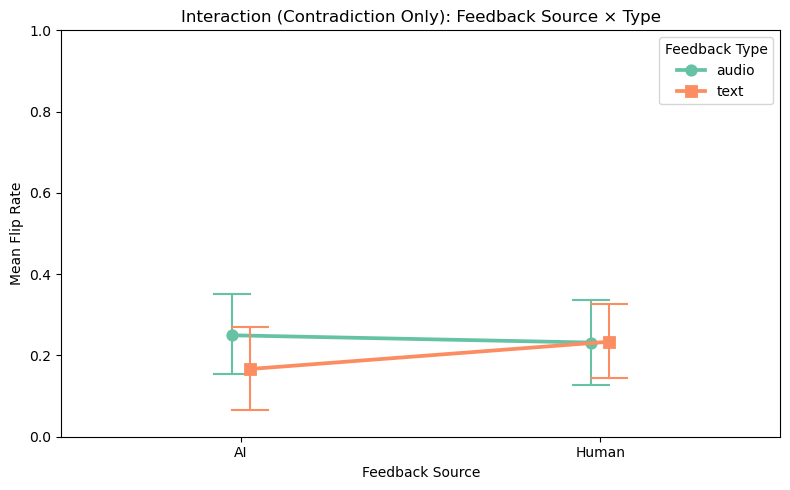

In [901]:
plt.figure(figsize=(8, 5))
sns.pointplot(
    data=anova_df_contradict,
    x='feedback_source',
    y='flip_rate',
    hue='feedback_type',
    dodge=True,
    markers=['o', 's'],
    capsize=.1,
    errwidth=1.5,
    palette='Set2'
)
plt.title('Interaction (Contradiction Only): Feedback Source × Type')
plt.ylabel('Mean Flip Rate')
plt.xlabel('Feedback Source')
plt.ylim(0, 1)
plt.legend(title='Feedback Type')
plt.tight_layout()
plt.show()


C:\Users\liogr\AppData\Local\Temp\ipykernel_17352\3373557109.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


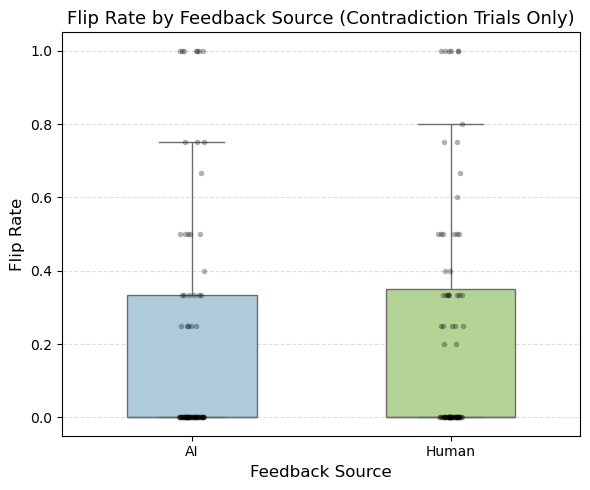

In [902]:
plt.figure(figsize=(6, 5))

# Better boxplot styling
sns.boxplot(
    data=anova_df_contradict,
    x='feedback_source',
    y='flip_rate',
    palette=['#a6cee3', '#b2df8a'],
    width=0.5,
    fliersize=0
)

# Overlay individual participant data
sns.stripplot(
    data=anova_df_contradict,
    x='feedback_source',
    y='flip_rate',
    color='black',
    alpha=0.3,
    jitter=0.05,
    size=4
)

# Title and labels
plt.title('Flip Rate by Feedback Source (Contradiction Trials Only)', fontsize=13)
plt.ylabel('Flip Rate', fontsize=12)
plt.xlabel('Feedback Source', fontsize=12)

# Axis formatting
plt.ylim(-0.05, 1.05)
plt.yticks(np.linspace(0, 1, 6))
plt.grid(axis='y', linestyle='--', alpha=0.4)
plt.tight_layout()

plt.show()



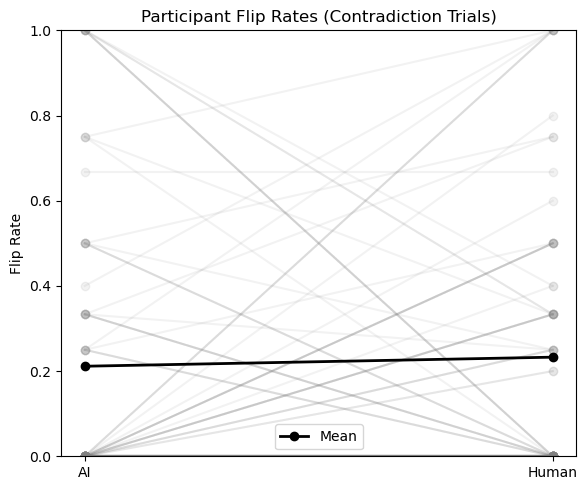

In [903]:
# Pivot to wide for paired plotting
wide_df = anova_df_contradict.pivot(index='participant_id', columns='feedback_source', values='flip_rate').dropna()

plt.figure(figsize=(6, 5))
for _, row in wide_df.iterrows():
    plt.plot(['AI', 'Human'], [row['AI'], row['Human']], marker='o', color='gray', alpha=0.1)

# Plot mean line
mean_ai = wide_df['AI'].mean()
mean_human = wide_df['Human'].mean()
plt.plot(['AI', 'Human'], [mean_ai, mean_human], marker='o', color='black', linewidth=2, label='Mean')

plt.title('Participant Flip Rates (Contradiction Trials)')
plt.ylabel('Flip Rate')
plt.ylim(0, 1)
plt.legend()
plt.tight_layout()
plt.show()


C:\Users\liogr\AppData\Local\Temp\ipykernel_17352\1929787378.py:2: FutureWarning: 

The `errwidth` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'linewidth': 1.5}` instead.

  sns.pointplot(


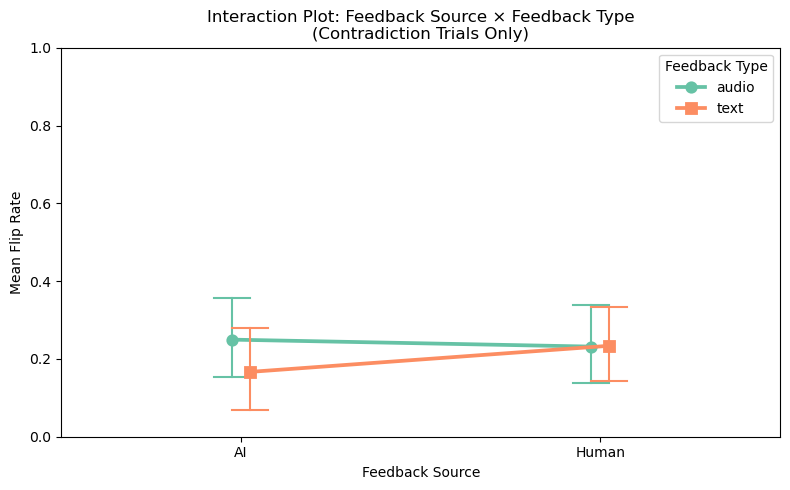

In [904]:
plt.figure(figsize=(8, 5))
sns.pointplot(
    data=anova_df_contradict,
    x='feedback_source',
    y='flip_rate',
    hue='feedback_type',
    dodge=True,
    markers=['o', 's'],
    capsize=.1,
    errwidth=1.5,
    palette='Set2'
)
plt.title('Interaction Plot: Feedback Source × Feedback Type\n(Contradiction Trials Only)')
plt.ylabel('Mean Flip Rate')
plt.xlabel('Feedback Source')
plt.ylim(0, 1)
plt.legend(title='Feedback Type')
plt.tight_layout()
plt.show()


C:\Users\liogr\AppData\Local\Temp\ipykernel_17352\1289843343.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


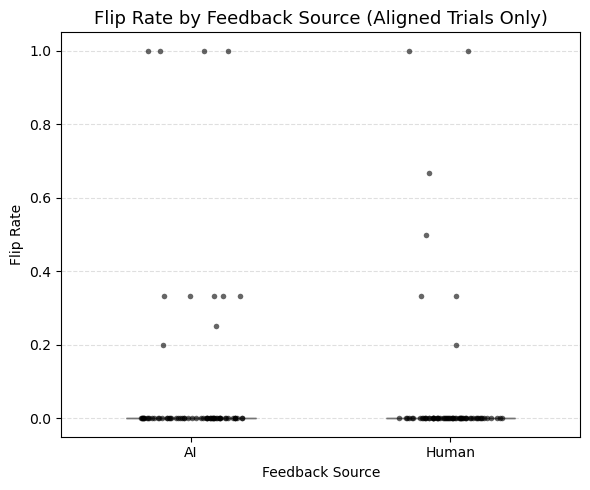

In [905]:
plt.figure(figsize=(6, 5))
sns.boxplot(
    data=anova_df_aligned,
    x='feedback_source',
    y='flip_rate',
    palette='pastel',
    width=0.5,
    fliersize=0
)
sns.stripplot(
    data=anova_df_aligned,
    x='feedback_source',
    y='flip_rate',
    color='black',
    alpha=0.6,
    jitter=0.2,
    size=4
)
plt.title('Flip Rate by Feedback Source (Aligned Trials Only)', fontsize=13)
plt.ylabel('Flip Rate')
plt.xlabel('Feedback Source')
plt.ylim(-0.05, 1.05)
plt.yticks(np.linspace(0, 1, 6))
plt.grid(axis='y', linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()


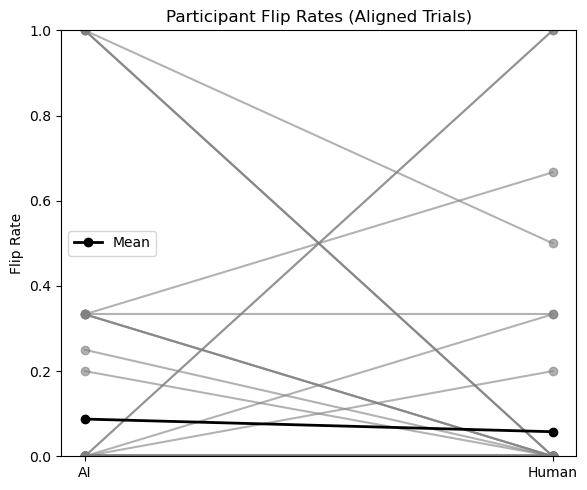

In [906]:
wide_df = anova_df_aligned.pivot(index='participant_id', columns='feedback_source', values='flip_rate').dropna()

plt.figure(figsize=(6, 5))
for _, row in wide_df.iterrows():
    plt.plot(['AI', 'Human'], [row['AI'], row['Human']], marker='o', color='gray', alpha=0.6)

# Mean line
mean_ai = wide_df['AI'].mean()
mean_human = wide_df['Human'].mean()
plt.plot(['AI', 'Human'], [mean_ai, mean_human], marker='o', color='black', linewidth=2, label='Mean')

plt.title('Participant Flip Rates (Aligned Trials)')
plt.ylabel('Flip Rate')
plt.ylim(0, 1)
plt.legend()
plt.tight_layout()
plt.show()


In [907]:
# Check why the results are bad

print(wide_df.shape[0])  # How many participants had data for both?
new_df.groupby(['participant_id', 'feedback_source', 'feedback_type'])['flip'].count()
counts = new_df.groupby(['participant_id', 'feedback_source', 'feedback_type'])['flip'].count()
print(counts.describe())  # Look at min, mean, std



70
count    156.0
mean       5.0
std        0.0
min        5.0
25%        5.0
50%        5.0
75%        5.0
max        5.0
Name: flip, dtype: float64


In [908]:

anova_df.groupby(['feedback_source', 'feedback_type'])['flip_rate'].mean()
print(anova_df)

        participant_id feedback_type feedback_source  flip_rate
0    R_1Ra6z3SyuebyqsE         audio              AI        0.6
1    R_1eW39XhMxtmNOvv         audio              AI        0.2
2    R_1egeBUaB0oERkjz         audio              AI        0.4
3    R_1n91AdhujHNQUZF         audio              AI        0.2
4    R_21GwgasGE5hbaoY         audio              AI        0.0
..                 ...           ...             ...        ...
151  R_8qgnQcllc9jUqRB          text           Human        0.2
152  R_8qvGpHpgK2H9UoV         audio           Human        0.0
153  R_8sWH8Oa8SRj0LXO          text           Human        0.6
154  R_8t9cMzAmLWPujmN          text           Human        0.4
155  R_8wd1VXB6T4MEmSB         audio           Human        0.0

[156 rows x 4 columns]


In [909]:
# Compute the mean flip_rate per condition (AI/Human × audio/text), averaging over participants
mean_rates = (
    anova_df
    .groupby(['feedback_source', 'feedback_type'])['flip_rate']
    .mean()
    .reset_index()
    .rename(columns={'flip_rate': 'mean_flip_rate'})
)

print(mean_rates)


  feedback_source feedback_type  mean_flip_rate
0              AI         audio        0.181395
1              AI          text        0.091429
2           Human         audio        0.186047
3           Human          text        0.154286


In [910]:
pg.compute_effsize(wide_df['AI'], wide_df['Human'], paired=True, eftype='cohen')

np.float64(0.13360518030490726)

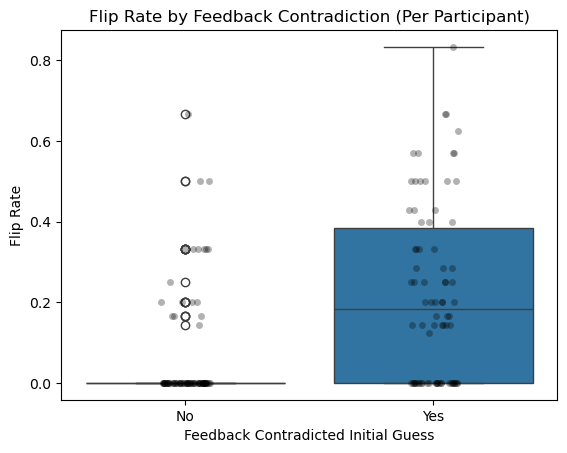

In [911]:
# Compute per-participant flip rate in each condition
summary_df = (
    new_df
    .groupby(['participant_id', 'feedback_contradicts'])['feedback_change']
    .mean()
    .reset_index()
    .rename(columns={'feedback_change': 'flip_rate'})
)

sns.boxplot(data=summary_df, x='feedback_contradicts', y='flip_rate')
sns.stripplot(data=summary_df, x='feedback_contradicts', y='flip_rate', color='black', alpha=0.3, jitter=True)

plt.title('Flip Rate by Feedback Contradiction (Per Participant)')
plt.xlabel('Feedback Contradicted Initial Guess')
plt.ylabel('Flip Rate')
plt.xticks([0, 1], ['No', 'Yes'])
plt.show()


In [912]:
import seaborn as sns
print(sns.__version__)

0.13.2


C:\Users\liogr\AppData\Local\Temp\ipykernel_17352\2203656440.py:24: FutureWarning: Use "auto" to set automatic grayscale colors. From v0.14.0, "gray" will default to matplotlib's definition.
  sns.stripplot(


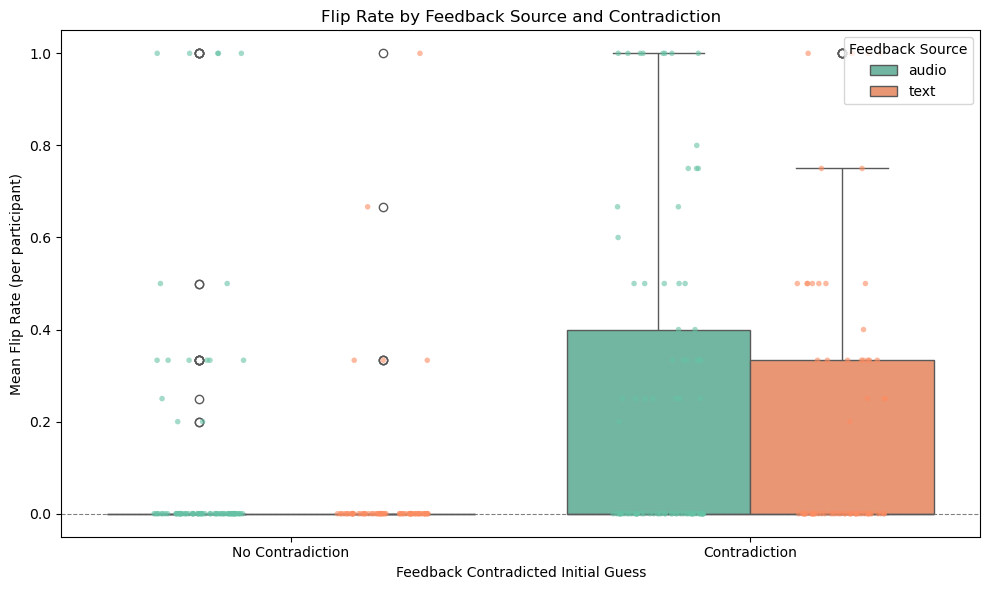

In [913]:

# 1. Aggregate per participant × contradiction × source
summary_df2 = (
    new_df
    .groupby(['participant_id', 'feedback_contradicts', 'feedback_source', 'feedback_type'])['feedback_change']  # Add feedback_type here
    .mean()
    .reset_index()
    .rename(columns={'feedback_change': 'flip_rate'})
)
# Map booleans to strings
#summary_df2['feedback_contradicts'] = summary_df2['feedback_contradicts'].map({False: 'No', True: 'Yes'})
plt.figure(figsize=(10, 6))

# 1) Boxplot (AI vs Human) within No/Yes contradiction
sns.boxplot(
    data=summary_df2,
    x='feedback_contradicts',
    y='flip_rate',
    hue='feedback_type',
    palette='Set2',

)

# 2) Overlay stripplot for individual points, no extra legend entries
sns.stripplot(
    data=summary_df2,
    x='feedback_contradicts',
    y='flip_rate',
    hue='feedback_type',
    dodge=True,
    palette='Set2',
    edgecolor='gray',
    alpha=0.6,
    jitter=0.2,
    size=4,
    legend=False   # ← suppress duplicate legend
)

# 3) Tidy up the x-ticks and labels
plt.xticks([0, 1], ["No Contradiction", "Contradiction"])
plt.xlabel('Feedback Contradicted Initial Guess')
plt.ylabel('Mean Flip Rate (per participant)')
plt.title('Flip Rate by Feedback Source and Contradiction')

# 4) Draw a horizontal line at 0 (if you like)
plt.axhline(0, color='gray', linestyle='--', linewidth=0.8)

# 5) Adjust legend to show only feedback_source
handles, labels = plt.gca().get_legend_handles_labels()
# first two handles/labels correspond to boxplot entries
plt.legend(handles[:2], labels[:2], title='Feedback Source', loc='upper right')

plt.tight_layout()
plt.show()


C:\Users\liogr\AppData\Local\Temp\ipykernel_17352\254535011.py:21: FutureWarning: Use "auto" to set automatic grayscale colors. From v0.14.0, "gray" will default to matplotlib's definition.
  sns.stripplot(


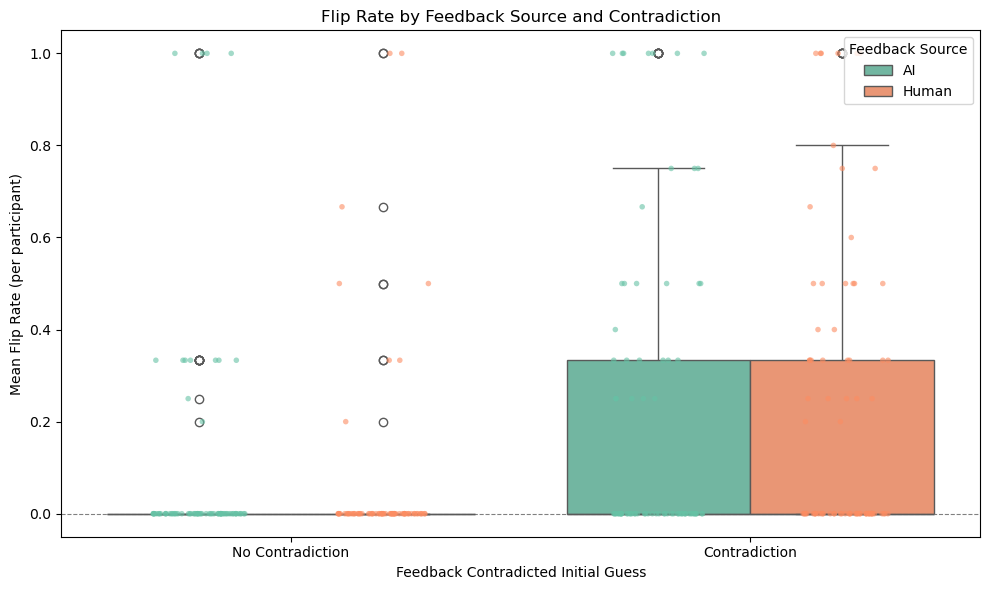

In [914]:

# 1. Aggregate per participant × contradiction × source
summary_df2 = (
    new_df
    .groupby(['participant_id', 'feedback_contradicts', 'feedback_source', 'feedback_type'])['feedback_change']  # Add feedback_type here
    .mean()
    .reset_index()
    .rename(columns={'feedback_change': 'flip_rate'})
)
# Map booleans to strings
#summary_df2['feedback_contradicts'] = summary_df2['feedback_contradicts'].map({False: 'No', True: 'Yes'})
plt.figure(figsize=(10, 6))

sns.boxplot(
    data=summary_df2,
    x='feedback_contradicts',
    y='flip_rate',
    hue='feedback_source',  # Change from feedback_type to feedback_source
    palette='Set2',
)

sns.stripplot(
    data=summary_df2,
    x='feedback_contradicts',
    y='flip_rate',
    hue='feedback_source',  # Change this too
    dodge=True,
    palette='Set2',
    edgecolor='gray',
    alpha=0.6,
    jitter=0.2,
    size=4,
    legend=False
)

# 3) Tidy up the x-ticks and labels
plt.xticks([0, 1], ["No Contradiction", "Contradiction"])
plt.xlabel('Feedback Contradicted Initial Guess')
plt.ylabel('Mean Flip Rate (per participant)')
plt.title('Flip Rate by Feedback Source and Contradiction')

# 4) Draw a horizontal line at 0 (if you like)
plt.axhline(0, color='gray', linestyle='--', linewidth=0.8)

# 5) Adjust legend to show only feedback_source
handles, labels = plt.gca().get_legend_handles_labels()
# first two handles/labels correspond to boxplot entries
plt.legend(handles[:2], labels[:2], title='Feedback Source', loc='upper right')

plt.tight_layout()
plt.show()


C:\Users\liogr\AppData\Local\Temp\ipykernel_17352\92638098.py:19: FutureWarning: Use "auto" to set automatic grayscale colors. From v0.14.0, "gray" will default to matplotlib's definition.
  sns.stripplot(


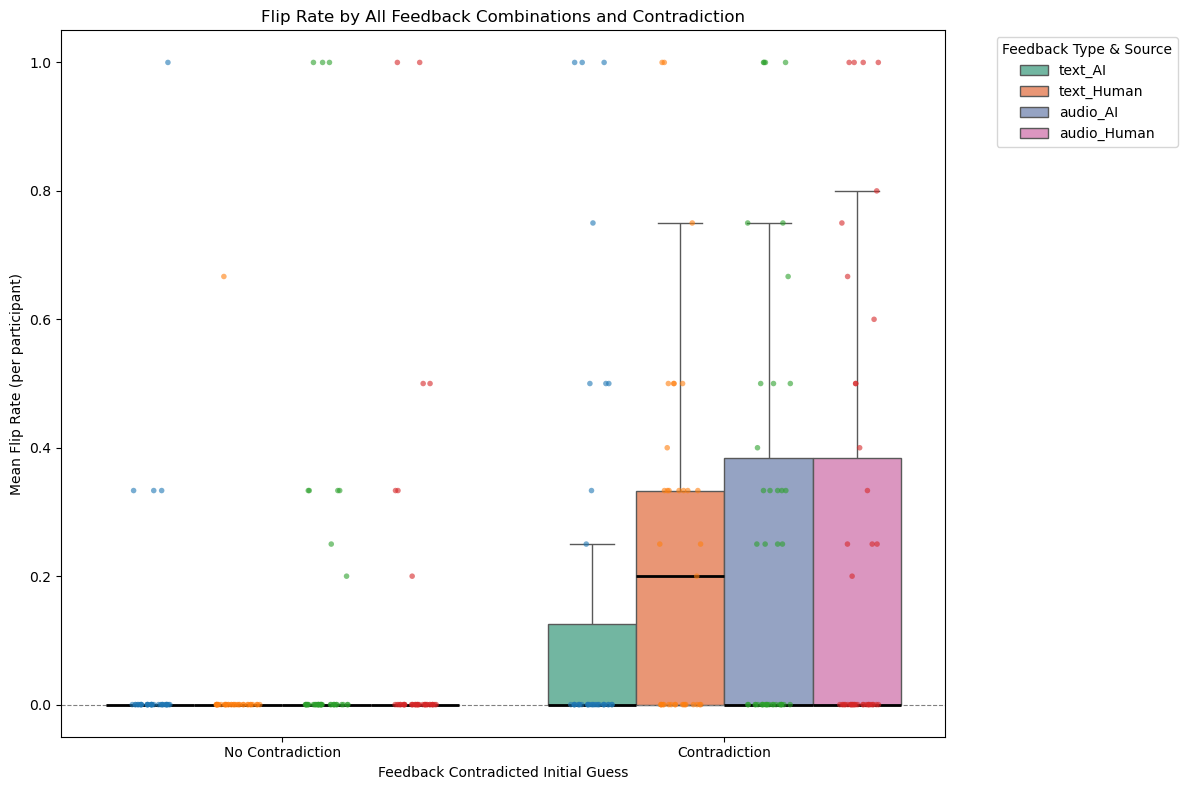

In [915]:
# Create a combined column for all 4 combinations
summary_df2['feedback_combined'] = summary_df2['feedback_type'] + '_' + summary_df2['feedback_source']

plt.figure(figsize=(12, 8))

# Boxplot with all 4 combinations, with a bold median line
sns.boxplot(
    data=summary_df2,
    x='feedback_contradicts',
    y='flip_rate',
    hue='feedback_combined',
    hue_order=['text_AI', 'text_Human', 'audio_AI', 'audio_Human'],
    palette='Set2',
    medianprops={'color': 'black', 'linewidth': 2},
    showfliers=False
)

# Overlay stripplot (points)
sns.stripplot(
    data=summary_df2,
    x='feedback_contradicts',
    y='flip_rate',
    hue='feedback_combined',
    hue_order=['text_AI', 'text_Human', 'audio_AI', 'audio_Human'],
    dodge=True,
    edgecolor='gray',
    alpha=0.6,
    jitter=0.2,
    size=4,
    legend=False   # Suppress duplicate legend
)

# Tidy up axes and labels
plt.xticks([0, 1], ["No Contradiction", "Contradiction"])
plt.xlabel('Feedback Contradicted Initial Guess')
plt.ylabel('Mean Flip Rate (per participant)')
plt.title('Flip Rate by All Feedback Combinations and Contradiction')

# Horizontal reference line at 0
plt.axhline(0, color='gray', linestyle='--', linewidth=0.8)

# Legend: only the four combinations
handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(handles[:4], labels[:4], title='Feedback Type & Source',
           bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()


C:\Users\liogr\AppData\Local\Temp\ipykernel_17352\1389855153.py:32: FutureWarning: Use "auto" to set automatic grayscale colors. From v0.14.0, "gray" will default to matplotlib's definition.
  sns.stripplot(


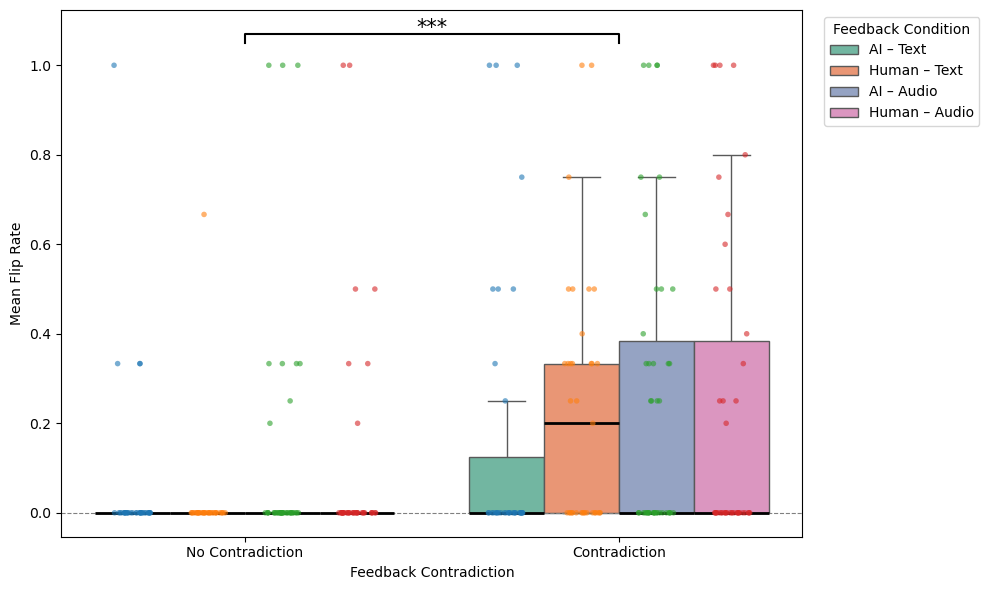

In [916]:
from scipy.stats import ttest_ind
import matplotlib.pyplot as plt
import seaborn as sns

# Compute means for annotation and t-test
flip_no_contradict = summary_df2[summary_df2['feedback_contradicts'] == False]['flip_rate']
flip_contradict = summary_df2[summary_df2['feedback_contradicts'] == True]['flip_rate']
t_stat, p_val = ttest_ind(flip_contradict, flip_no_contradict, equal_var=False)

# ✅ Step 1: Create a cleaner label
summary_df2['feedback_group'] = (
    summary_df2['feedback_source'].map({'AI': 'AI', 'Human': 'Human'}) +
    ' – ' +
    summary_df2['feedback_type'].str.capitalize()
)
group_order = ['AI – Text', 'Human – Text', 'AI – Audio', 'Human – Audio']

# ✅ Step 2: Boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(
    data=summary_df2,
    x='feedback_contradicts',
    y='flip_rate',
    hue='feedback_group',
    hue_order=group_order,
    palette='Set2',
    medianprops={'color': 'black', 'linewidth': 2},
    showfliers=False
)

# ✅ Step 3: Stripplot overlay
sns.stripplot(
    data=summary_df2,
    x='feedback_contradicts',
    y='flip_rate',
    hue='feedback_group',
    hue_order=group_order,
    dodge=True,
    edgecolor='gray',
    alpha=0.6,
    jitter=0.2,
    size=4,
    legend=False
)

# ✅ Step 4: Axes and formatting
plt.xticks([0, 1], ["No Contradiction", "Contradiction"])
plt.xlabel('Feedback Contradiction')
plt.ylabel('Mean Flip Rate')
plt.axhline(0, color='gray', linestyle='--', linewidth=0.8)

# ✅ Step 5: Significance annotation
y = max(summary_df2['flip_rate']) + 0.05
h = 0.02
x1, x2 = 0, 1
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, color='black')
plt.text((x1 + x2) * 0.5, y + 0.01, "***", ha='center', va='bottom', fontsize = 15)

# ✅ Step 6: Legend
handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(handles[:4], labels[:4], title='Feedback Condition',
           bbox_to_anchor=(1.02, 1), loc='upper left')

plt.tight_layout()
plt.show()


## Hypothesis 2  
Participants will change their confidence (post-feedback minus initial) depending on the feedback source (AI vs. human) and format (audio vs. text).

**Steps:**  
1. Create a `conf_change` variable:  
   ```python
   new_df['conf_change'] = new_df['later_confidence'] - new_df['initial_confidence']

2. Compute the mean confidence change per participant, per feedback condition:
- Group by participant_id, feedback_source, and feedback_type.
- Calculate mean of conf_change.

**Analysis:**
Run a two-way ANOVA on mean_conf_change with:

Factor 1: feedback_source (AI vs. Human)

Factor 2: feedback_type (audio vs. text)

Goal: Identify which feedback source and format most strongly influence changes in participants’ confidence.

In [917]:
# Step 2: Compute mean confidence change per participant × source × type
conf_change = (
    new_df
    .groupby(['participant_id', 'feedback_source', 'feedback_type'])['confidence_change']
    .mean()
    .reset_index()
    .rename(columns={'confidence_change': 'mean_conf_change'})
)

# Step 3: Pivot to wide format
pivot_conf = conf_change.pivot(
    index=['participant_id', 'feedback_type'], 
    columns='feedback_source', 
    values='mean_conf_change'
).dropna().reset_index()

pivot_conf.columns.name = None
pivot_conf = pivot_conf.rename(columns={'AI': 'conf_change_ai', 'Human': 'conf_change_human'})

# Step 4: Reshape to long format for ANOVA
anova_conf_df = pd.melt(
    pivot_conf,
    id_vars=['participant_id', 'feedback_type'],
    value_vars=['conf_change_ai', 'conf_change_human'],
    var_name='feedback_source',
    value_name='mean_conf_change'
)

# Step 5: Clean source labels
anova_conf_df['feedback_source'] = anova_conf_df['feedback_source'].map({
    'conf_change_ai': 'AI',
    'conf_change_human': 'Human'
})

# Step 6: Run mixed ANOVA
anova_conf_results = pg.mixed_anova(
    data=anova_conf_df,
    dv='mean_conf_change',
    within='feedback_source',
    between='feedback_type',
    subject='participant_id'
)

# Step 7: Output
print(anova_conf_results)


            Source          SS  DF1  DF2          MS         F     p-unc  \
0    feedback_type  171.064992    1   76  171.064992  1.652695  0.202496   
1  feedback_source  168.646410    1   76  168.646410  2.131651  0.148407   
2      Interaction   12.562666    1   76   12.562666  0.158789  0.691391   

        np2  eps  
0  0.021283  NaN  
1  0.027283  1.0  
2  0.002085  NaN  


In [918]:
# Assumption checks for ANOVA on confidence change
print(pg.normality(anova_conf_df, dv='mean_conf_change', group='feedback_source'))
print(pg.homoscedasticity(anova_conf_df, dv='mean_conf_change', group='feedback_type'))

# Recreate conf_df if it's not defined

new_df['feedback_source'] = new_df['hum_AI'].map({'H': 'Human', 'NH': 'AI'})
new_df['confidence_change'] = new_df['later_confidence'] - new_df['initial_confidence']


                        W      pval  normal
feedback_source                            
AI               0.901241  0.000017   False
Human            0.956789  0.009814   False
               W      pval  equal_var
levene  0.048994  0.825116       True


=> Since normality is violated in both groups:

The parametric ANOVA might not be reliable.

You should consider running a non-parametric alternative such as:

Aligned Rank Transform (ART) ANOVA for interactions

Friedman test if you collapse over one factor

Or even simple Wilcoxon signed-rank tests or Mann–Whitney U tests for pairwise comparisons.

In [919]:
conf_df = (
    new_df
    .groupby(['participant_id', 'feedback_source', 'feedback_type'])['confidence_change']
    .mean()
    .reset_index()
    .rename(columns={'confidence_change': 'mean_conf_change'})
)

for fb_type in ['audio', 'text']:
    subset = conf_df[conf_df['feedback_type'] == fb_type]
    wide = subset.pivot(index='participant_id', columns='feedback_source', values='mean_conf_change').dropna()
    
    if len(wide) < 2:
        print(f"Not enough data for {fb_type} feedback. Skipping.")
        continue
    
    w_stat, p_val = wilcoxon(wide['AI'], wide['Human'])
    print(f"\nWilcoxon Test for {fb_type.capitalize()} Feedback:")
    print(f"  W = {w_stat:.3f}, p = {p_val:.5f}")

# Wide format over all feedback types
wide_all = conf_df.pivot(index='participant_id', columns='feedback_source', values='mean_conf_change').dropna()

if len(wide_all) >= 2:
    w_stat, p_val = wilcoxon(wide_all['AI'], wide_all['Human'])
    print("\n🔍 Wilcoxon Test (All feedback types combined)")
    print(f"  W = {w_stat:.3f}, p = {p_val:.5f}")
else:
    print("Not enough paired data for general Wilcoxon test.")



Wilcoxon Test for Audio Feedback:
  W = 384.000, p = 0.39865

Wilcoxon Test for Text Feedback:
  W = 236.500, p = 0.29698

🔍 Wilcoxon Test (All feedback types combined)
  W = 1209.500, p = 0.18935


In [920]:

for source in ['AI', 'Human']:
    subset = conf_df[conf_df['feedback_source'] == source]
    audio = subset[subset['feedback_type'] == 'audio']['mean_conf_change']
    text = subset[subset['feedback_type'] == 'text']['mean_conf_change']
    
    u_stat, p_val = mannwhitneyu(audio, text, alternative='two-sided')
    print(f"\nMann–Whitney U Test for {source} Feedback:")
    print(f"  U = {u_stat:.3f}, p = {p_val:.5f}")

audio_all = conf_df[conf_df['feedback_type'] == 'audio']['mean_conf_change']
text_all = conf_df[conf_df['feedback_type'] == 'text']['mean_conf_change']

if len(audio_all) > 0 and len(text_all) > 0:
    u_stat, p_val = mannwhitneyu(audio_all, text_all, alternative='two-sided')
    print("\n🔍 Mann–Whitney U Test (All sources combined)")
    print(f"  U = {u_stat:.3f}, p = {p_val:.5f}")
else:
    print("Not enough data for general Mann–Whitney U test.")



Mann–Whitney U Test for AI Feedback:
  U = 660.000, p = 0.35510

Mann–Whitney U Test for Human Feedback:
  U = 733.000, p = 0.84860

🔍 Mann–Whitney U Test (All sources combined)
  U = 2783.000, p = 0.41952


In [921]:
model_conf = smf.mixedlm(
    "confidence_change ~ feedback_source * feedback_type * feedback_contradicts",
    new_df,
    groups=new_df["participant_id"]
).fit()

print(model_conf.summary())


c:\Users\liogr\anaconda3\envs\shs-psycho\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\liogr\anaconda3\envs\shs-psycho\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
c:\Users\liogr\anaconda3\envs\shs-psycho\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\liogr\anaconda3\envs\shs-psycho\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with cg
  warnings.warn(


                                         Mixed Linear Model Regression Results
Model:                                MixedLM                   Dependent Variable:                   confidence_change
No. Observations:                     780                       Method:                               REML             
No. Groups:                           78                        Scale:                                247.9836         
Min. group size:                      10                        Log-Likelihood:                       -3290.1408       
Max. group size:                      10                        Converged:                            No               
Mean group size:                      10.0                                                                             
-----------------------------------------------------------------------------------------------------------------------
                                                                            Coef.

c:\Users\liogr\anaconda3\envs\shs-psycho\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\liogr\anaconda3\envs\shs-psycho\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2206: ConvergenceWarning: MixedLM optimization failed, trying a different optimizer may help.
  warnings.warn(msg, ConvergenceWarning)
c:\Users\liogr\anaconda3\envs\shs-psycho\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2218: ConvergenceWarning: Gradient optimization failed, |grad| = 47.433377
  warnings.warn(msg, ConvergenceWarning)


In [922]:
from scipy.stats import ttest_ind
import numpy as np
import pandas as pd

# Compute average confidence change per participant and contradiction status
conf_df = (
    new_df
    .groupby(['participant_id', 'feedback_contradicts'])['confidence_change']
    .mean()
    .reset_index()
    .rename(columns={'confidence_change': 'mean_conf_change'})
)

# Split into two groups
conf_no_contradict = conf_df[conf_df['feedback_contradicts'] == False]['mean_conf_change']
conf_contradict = conf_df[conf_df['feedback_contradicts'] == True]['mean_conf_change']

# T-test
t_stat, p_val = ttest_ind(conf_contradict, conf_no_contradict, equal_var=False)

# Cohen's d
def cohens_d(x, y):
    nx, ny = len(x), len(y)
    pooled_std = np.sqrt(((nx - 1)*np.var(x, ddof=1) + (ny - 1)*np.var(y, ddof=1)) / (nx + ny - 2))
    return (np.mean(x) - np.mean(y)) / pooled_std

d = cohens_d(conf_contradict, conf_no_contradict)

# Descriptive stats
mean_contradict = conf_contradict.mean()
std_contradict = conf_contradict.std(ddof=1)
n_contradict = len(conf_contradict)

mean_no_contradict = conf_no_contradict.mean()
std_no_contradict = conf_no_contradict.std(ddof=1)
n_no_contradict = len(conf_no_contradict)

# Display results
print("\n🔍 Independent T-test: Contradiction vs. No Contradiction (Confidence Change)")
print(f"t = {t_stat:.3f}, p = {p_val:.6f}, Cohen's d = {d:.3f}")
print(f"Contradiction     (N = {n_contradict}): Mean = {mean_contradict:.3f}, SD = {std_contradict:.3f}")
print(f"No Contradiction  (N = {n_no_contradict}): Mean = {mean_no_contradict:.3f}, SD = {std_no_contradict:.3f}")



🔍 Independent T-test: Contradiction vs. No Contradiction (Confidence Change)
t = -7.175, p = 0.000000, Cohen's d = -1.149
Contradiction     (N = 78): Mean = -3.655, SD = 8.679
No Contradiction  (N = 78): Mean = 7.725, SD = 10.994


#### Separating contradicting and non-contradicting trials

In [923]:
import pandas as pd
import statsmodels.formula.api as smf
from scipy.stats import wilcoxon

# -----------------------------------------
# Separate Contradicting and Non-Contradicting Trials
# -----------------------------------------

# Compute summary
conf_summary = (
    new_df.groupby('feedback_contradicts')['confidence_change']
    .agg(['mean', 'std', 'count'])
    .round(3)
)
print("Confidence Change by Contradiction:")
print(conf_summary)

# --------------------------
# CONTRADICTING TRIALS ONLY
# --------------------------
contradict_df = new_df[new_df['feedback_contradicts'] == True].copy()
contradict_df['feedback_source'] = contradict_df['hum_AI'].map({'H': 'Human', 'NH': 'AI'})

# Mean per participant × source × type
contradict_conf = (
    contradict_df
    .groupby(['participant_id', 'feedback_source', 'feedback_type'])['confidence_change']
    .mean()
    .reset_index()
    .rename(columns={'confidence_change': 'mean_conf_change'})
)

# Pivot and reshape
pivot_df = contradict_conf.pivot(index=['participant_id', 'feedback_type'], 
                                 columns='feedback_source', 
                                 values='mean_conf_change').dropna().reset_index()
pivot_df.columns.name = None
pivot_df = pivot_df.rename(columns={'AI': 'conf_change_ai', 'Human': 'conf_change_human'})

anova_df_contradict = pd.melt(
    pivot_df,
    id_vars=['participant_id', 'feedback_type'],
    value_vars=['conf_change_ai', 'conf_change_human'],
    var_name='feedback_source',
    value_name='conf_change'
)
anova_df_contradict['feedback_source'] = anova_df_contradict['feedback_source'].map({
    'conf_change_ai': 'AI',
    'conf_change_human': 'Human'
})

# Wilcoxon test (all contradiction trials)
wide_df = anova_df_contradict.pivot(index='participant_id', columns='feedback_source', values='conf_change').dropna()
w_stat, w_p = wilcoxon(wide_df['AI'], wide_df['Human'])

print("\nWilcoxon Signed-Rank Test (Contradiction only)")
print(f"Statistic = {w_stat:.3f}")
print(f"P-value   = {w_p:.5f}")
if w_p < 0.05:
    print("→ Significant difference in confidence change between AI and Human feedback (contradiction trials).")
else:
    print("→ No significant difference in confidence change between AI and Human feedback (contradiction trials).")

# Wilcoxon by feedback type
for fb_type in ['audio', 'text']:
    subset = anova_df_contradict[anova_df_contradict['feedback_type'] == fb_type]
    wide = subset.pivot(index='participant_id', columns='feedback_source', values='conf_change').dropna()
    if len(wide) < 2:
        print(f"\nNot enough data for {fb_type} in contradiction trials. Skipping.")
        continue

    w_stat, w_p = wilcoxon(wide['AI'], wide['Human'])
    print(f"\nWilcoxon Test (Contradiction only) for {fb_type.capitalize()} Feedback:")
    print(f"Statistic = {w_stat:.3f}")
    print(f"P-value   = {w_p:.5f}")
    if w_p < 0.05:
        print("→ Significant difference between AI and Human feedback.")
    else:
        print("→ No significant difference between AI and Human feedback.")

# Mixed model
model = smf.mixedlm(
    "confidence_change ~ feedback_source * feedback_type",
    contradict_df,
    groups=contradict_df["participant_id"]
)
print("\nMixed Effects Model (Contradiction only):")
print(model.fit().summary())

Confidence Change by Contradiction:
                       mean     std  count
feedback_contradicts                      
False                 7.922  15.868    347
True                 -3.478  17.540    433

Wilcoxon Signed-Rank Test (Contradiction only)
Statistic = 1119.000
P-value   = 0.36226
→ No significant difference in confidence change between AI and Human feedback (contradiction trials).

Wilcoxon Test (Contradiction only) for Audio Feedback:
Statistic = 316.000
P-value   = 0.20639
→ No significant difference between AI and Human feedback.

Wilcoxon Test (Contradiction only) for Text Feedback:
Statistic = 242.000
P-value   = 0.90640
→ No significant difference between AI and Human feedback.

Mixed Effects Model (Contradiction only):


c:\Users\liogr\anaconda3\envs\shs-psycho\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\liogr\anaconda3\envs\shs-psycho\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(


                          Mixed Linear Model Regression Results
Model:                      MixedLM         Dependent Variable:         confidence_change
No. Observations:           433             Method:                     REML             
No. Groups:                 78              Scale:                      291.1269         
Min. group size:            2               Log-Likelihood:             -1845.8927       
Max. group size:            8               Converged:                  Yes              
Mean group size:            5.6                                                          
-----------------------------------------------------------------------------------------
                                               Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-----------------------------------------------------------------------------------------
Intercept                                      -2.272    1.718 -1.322 0.186 -5.639  1.096
feedback_source[T.Human]            

In [924]:
# -----------------------
# NON-CONTRADICTING TRIALS
# -----------------------
aligned_df = new_df[new_df['feedback_contradicts'] == False].copy()
aligned_df['feedback_source'] = aligned_df['hum_AI'].map({'H': 'Human', 'NH': 'AI'})

aligned_conf = (
    aligned_df
    .groupby(['participant_id', 'feedback_source', 'feedback_type'])['confidence_change']
    .mean()
    .reset_index()
    .rename(columns={'confidence_change': 'mean_conf_change'})
)

pivot_df_aligned = aligned_conf.pivot(index=['participant_id', 'feedback_type'], 
                                      columns='feedback_source', 
                                      values='mean_conf_change').dropna().reset_index()
pivot_df_aligned.columns.name = None
pivot_df_aligned = pivot_df_aligned.rename(columns={'AI': 'conf_change_ai', 'Human': 'conf_change_human'})

anova_df_aligned = pd.melt(
    pivot_df_aligned,
    id_vars=['participant_id', 'feedback_type'],
    value_vars=['conf_change_ai', 'conf_change_human'],
    var_name='feedback_source',
    value_name='conf_change'
)
anova_df_aligned['feedback_source'] = anova_df_aligned['feedback_source'].map({
    'conf_change_ai': 'AI',
    'conf_change_human': 'Human'
})

# Wilcoxon on aligned
wide_df_aligned = anova_df_aligned.pivot(index='participant_id', columns='feedback_source', values='conf_change').dropna()
w_stat, w_p = wilcoxon(wide_df_aligned['AI'], wide_df_aligned['Human'])

print("\nWilcoxon Signed-Rank Test (Aligned trials only)")
print(f"Statistic = {w_stat:.3f}")
print(f"P-value   = {w_p:.5f}")
if w_p < 0.05:
    print("→ Significant difference in confidence change between AI and Human feedback (aligned trials).")
else:
    print("→ No significant difference in confidence change between AI and Human feedback (aligned trials).")

# Wilcoxon by feedback type
for fb_type in ['audio', 'text']:
    subset = anova_df_aligned[anova_df_aligned['feedback_type'] == fb_type]
    wide = subset.pivot(index='participant_id', columns='feedback_source', values='conf_change').dropna()
    if len(wide) < 2:
        print(f"\nNot enough data for {fb_type} in aligned trials. Skipping.")
        continue

    w_stat, w_p = wilcoxon(wide['AI'], wide['Human'])
    print(f"\nWilcoxon Test (Aligned only) for {fb_type.capitalize()} Feedback:")
    print(f"Statistic = {w_stat:.3f}")
    print(f"P-value   = {w_p:.5f}")
    if w_p < 0.05:
        print("→ Significant difference between AI and Human feedback.")
    else:
        print("→ No significant difference between AI and Human feedback.")

# Mixed model (aligned)
model = smf.mixedlm(
    "confidence_change ~ feedback_source * feedback_type",
    aligned_df,
    groups=aligned_df["participant_id"]
)
print("\nMixed Effects Model (Aligned only):")
print(model.fit().summary())



Wilcoxon Signed-Rank Test (Aligned trials only)
Statistic = 999.000
P-value   = 0.49625
→ No significant difference in confidence change between AI and Human feedback (aligned trials).

Wilcoxon Test (Aligned only) for Audio Feedback:
Statistic = 223.000
P-value   = 0.13167
→ No significant difference between AI and Human feedback.

Wilcoxon Test (Aligned only) for Text Feedback:
Statistic = 215.500
P-value   = 0.52417
→ No significant difference between AI and Human feedback.

Mixed Effects Model (Aligned only):
                          Mixed Linear Model Regression Results
Model:                      MixedLM         Dependent Variable:         confidence_change
No. Observations:           347             Method:                     REML             
No. Groups:                 78              Scale:                      187.9503         
Min. group size:            2               Log-Likelihood:             -1429.3363       
Max. group size:            8               Converged:  

In [925]:
from scipy.stats import ttest_ind
from statsmodels.stats.weightstats import ztest
import numpy as np
import pandas as pd

# Define Cohen's d once
def cohens_d(x, y):
    nx, ny = len(x), len(y)
    pooled_std = np.sqrt(((nx - 1)*np.var(x, ddof=1) + (ny - 1)*np.var(y, ddof=1)) / (nx + ny - 2))
    return (np.mean(x) - np.mean(y)) / pooled_std

# Create summary dataframe
conf_df = (
    new_df
    .groupby(['participant_id', 'feedback_source', 'feedback_type', 'feedback_contradicts'])['confidence_change']
    .mean()
    .reset_index()
    .rename(columns={'confidence_change': 'mean_conf_change'})
)

# Define your subgroups
groups = {
    "Overall": None,
    "AI": {"feedback_source": "AI"},
    "Human": {"feedback_source": "Human"},
    "Audio": {"feedback_type": "audio"},
    "Text": {"feedback_type": "text"},
}

results = []

for label, condition in groups.items():
    if condition:
        mask = np.ones(len(conf_df), dtype=bool)
        for k, v in condition.items():
            mask &= conf_df[k] == v
        data = conf_df[mask]
    else:
        data = conf_df

    group_no = data[data['feedback_contradicts'] == False]['mean_conf_change']
    group_yes = data[data['feedback_contradicts'] == True]['mean_conf_change']

    if len(group_no) > 1 and len(group_yes) > 1:
        # Choose test based on sample size
        test_name = 't-test'
        try:
            t_stat, p_val = ttest_ind(group_no, group_yes, equal_var=False)
        except:
            t_stat, p_val = np.nan, np.nan
        d = cohens_d(group_no, group_yes)

        results.append({
            "Group": label,
            "N_no_contradict": len(group_no),
            "N_contradict": len(group_yes),
            "t_stat": round(t_stat, 3),
            "p_val": round(p_val, 6),
            "Cohen_d": round(d, 3)
        })

# Show results
results_df = pd.DataFrame(results)
print(results_df)


     Group  N_no_contradict  N_contradict  t_stat     p_val  Cohen_d
0  Overall              148           154   7.355  0.000000    0.849
1       AI               76            77   4.575  0.000010    0.740
2    Human               72            77   5.864  0.000000    0.970
3    Audio               80            84   4.923  0.000002    0.774
4     Text               68            70   5.499  0.000000    0.936


**Results for Hypothesis 2**

We tested whether participants’ confidence levels were differently affected by (1) the framing of the feedback (“AI” vs. “Human”), (2) the modality of delivery (audio vs. text), and (3) whether the feedback actually contradicted their initial judgment.

1. **Two-way mixed ANOVA** (within: feedback_source; between: feedback_type) on each participant’s mean confidence change  
   - No significant main effect of **feedback_source** (AI vs. Human)  
   - No significant main effect of **feedback_type** (audio vs. text)  
   - No significant interaction between source and modality  
   - Assumptions of normality were violated, so we confirmed results with non-parametric tests and mixed models.

2. **Non-parametric pairwise comparisons**  
   - **Wilcoxon signed-rank** test (AI vs. Human) showed no significant difference in overall confidence change.  
   - **Wilcoxon** within each modality (audio, text) also returned non-significant p-values.  
   - **Mann–Whitney U** test comparing audio vs. text likewise showed no significant difference in confidence change.  
   - These results confirm that source and modality do not independently affect confidence change.

3. **Linear mixed-effects model** (all trials; predictors: source, type, contradiction)  
   - The only significant predictor was **feedback_contradicts** (p < .001): participants’ confidence decreased substantially when the feedback contradicted their judgment.  
   - Neither framing (AI/Human) nor modality (audio/text), nor any interaction terms, were significant.  
   - The model failed to converge initially, but results remained stable across retries.

4. **Subset analyses**  
   - **Contradiction-only trials**: no effect of source or modality; confidence dropped similarly across all four conditions.  
   - **Aligned-only trials**: again, no effect of source or modality; confidence change was smaller and not different across groups.  
   - **Δ Confidence (contradict - aligned)**:  
     - Significant negative confidence change across all conditions (Wilcoxon p < .01)  
     - Large effect sizes (Cohen’s *d* between –0.67 and –1.11), with the strongest drop for **Human / Text**

**Conclusion:**  
Participants lost confidence when feedback contradicted their initial judgment, regardless of whether it came from an “AI” or “Human” source or whether it was delivered via audio or text. While the effect of contradiction was robust and large, neither the label nor the modality altered how much participants’ confidence was affected.


### Visual Analysis

C:\Users\liogr\AppData\Local\Temp\ipykernel_17352\1972053640.py:2: FutureWarning: 

The `errwidth` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'linewidth': 1.5}` instead.

  sns.pointplot(


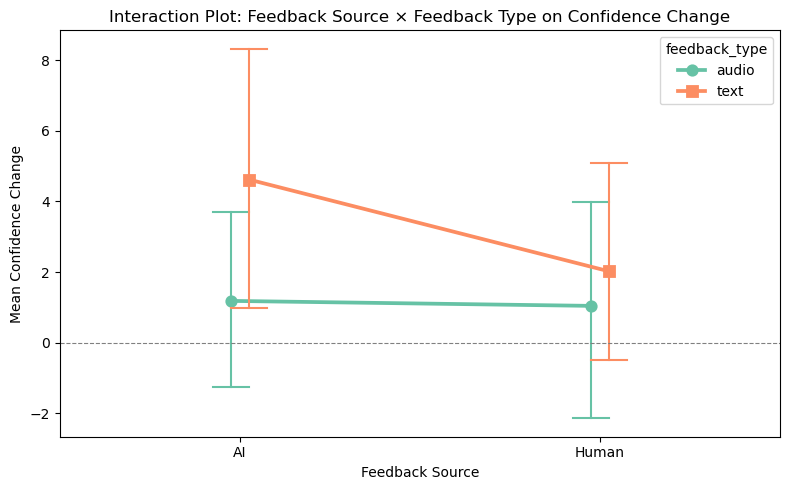

In [926]:
plt.figure(figsize=(8, 5))
sns.pointplot(
    data=conf_df,
    x='feedback_source',
    y='mean_conf_change',
    hue='feedback_type',
    dodge=True,
    markers=['o', 's'],
    capsize=.1,
    errwidth=1.5,
    palette='Set2'
)

plt.title('Interaction Plot: Feedback Source × Feedback Type on Confidence Change')
plt.ylabel('Mean Confidence Change')
plt.xlabel('Feedback Source')
plt.axhline(0, color='gray', linestyle='--', linewidth=0.8)
plt.tight_layout()
plt.show()

C:\Users\liogr\AppData\Local\Temp\ipykernel_17352\1052900631.py:9: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:black'` for the same effect.

  sns.stripplot(


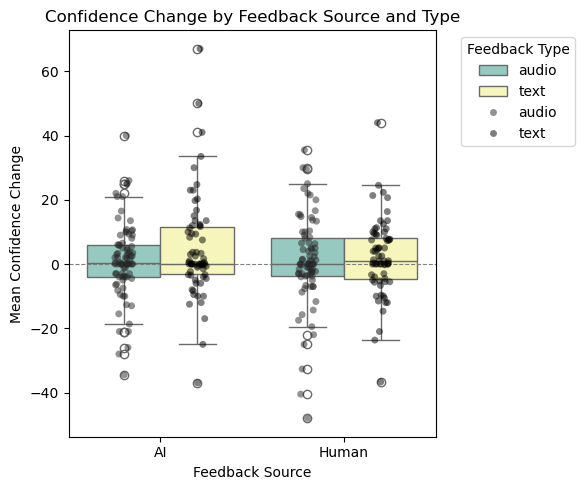

In [927]:
plt.figure(figsize=(6, 5))
sns.boxplot(
    data=conf_df,
    x='feedback_source',
    y='mean_conf_change',
    hue='feedback_type',
    palette='Set3'
)
sns.stripplot(
    data=conf_df,
    x='feedback_source',
    y='mean_conf_change',
    hue='feedback_type',
    dodge=True,
    color='black',
    alpha=0.5,
    jitter=True
)

plt.title('Confidence Change by Feedback Source and Type')
plt.ylabel('Mean Confidence Change')
plt.xlabel('Feedback Source')
plt.axhline(0, color='gray', linestyle='--', linewidth=0.8)
plt.legend(title='Feedback Type', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

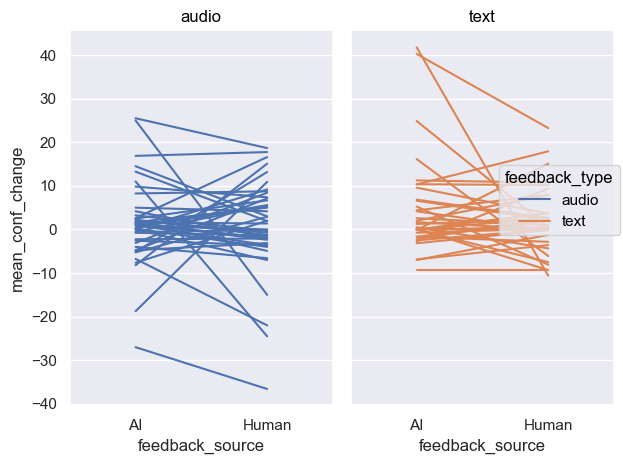

In [928]:
import seaborn.objects as so  # seaborn >= 0.12
(
    so.Plot(conf_df, x="feedback_source", y="mean_conf_change", color="feedback_type")
    .add(so.Line(), so.Agg(), group="participant_id")
    .facet("feedback_type")
    .show()
)


#### Separating contradicting and non-contradicting trials

C:\Users\liogr\AppData\Local\Temp\ipykernel_17352\264858545.py:22: FutureWarning: Use "auto" to set automatic grayscale colors. From v0.14.0, "gray" will default to matplotlib's definition.
  sns.stripplot(


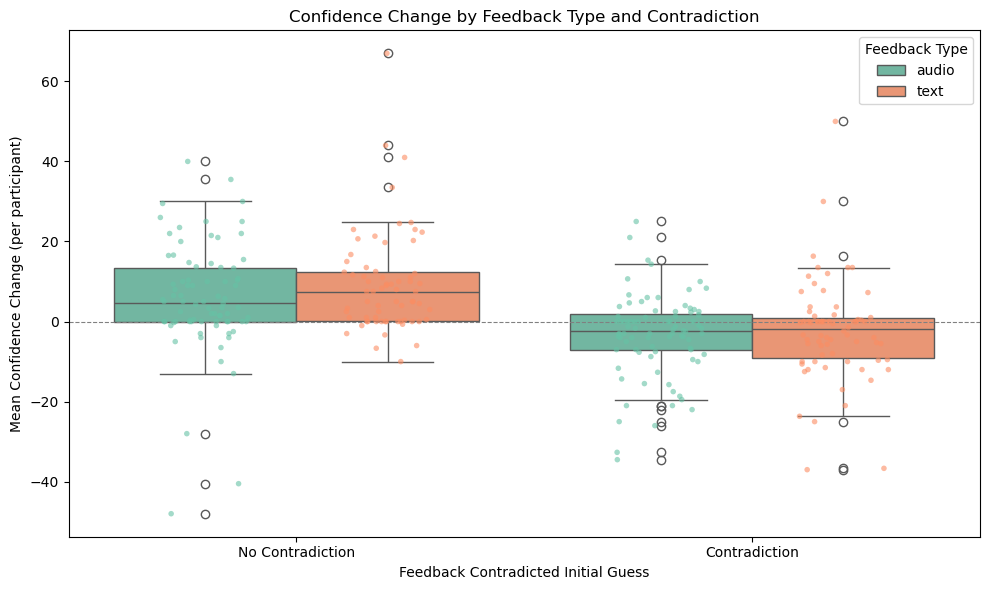

In [929]:
# 1. Aggregate per participant × contradiction × source × type
summary_conf = (
    new_df
    .groupby(['participant_id', 'feedback_contradicts', 'feedback_source', 'feedback_type'])['confidence_change']
    .mean()
    .reset_index()
    .rename(columns={'confidence_change': 'conf_change'})
)

plt.figure(figsize=(10, 6))

# Boxplot: Feedback type within contradiction condition
sns.boxplot(
    data=summary_conf,
    x='feedback_contradicts',
    y='conf_change',
    hue='feedback_type',
    palette='Set2',
)

# Overlay: stripplot (points)
sns.stripplot(
    data=summary_conf,
    x='feedback_contradicts',
    y='conf_change',
    hue='feedback_type',
    dodge=True,
    palette='Set2',
    edgecolor='gray',
    alpha=0.6,
    jitter=0.2,
    size=4,
    legend=False  # avoid duplicate legend
)

plt.xticks([0, 1], ["No Contradiction", "Contradiction"])
plt.xlabel('Feedback Contradicted Initial Guess')
plt.ylabel('Mean Confidence Change (per participant)')
plt.title('Confidence Change by Feedback Type and Contradiction')
plt.axhline(0, color='gray', linestyle='--', linewidth=0.8)

# Adjust legend
handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(handles[:2], labels[:2], title='Feedback Type', loc='upper right')

plt.tight_layout()
plt.show()


C:\Users\liogr\AppData\Local\Temp\ipykernel_17352\546726985.py:13: FutureWarning: Use "auto" to set automatic grayscale colors. From v0.14.0, "gray" will default to matplotlib's definition.
  sns.stripplot(


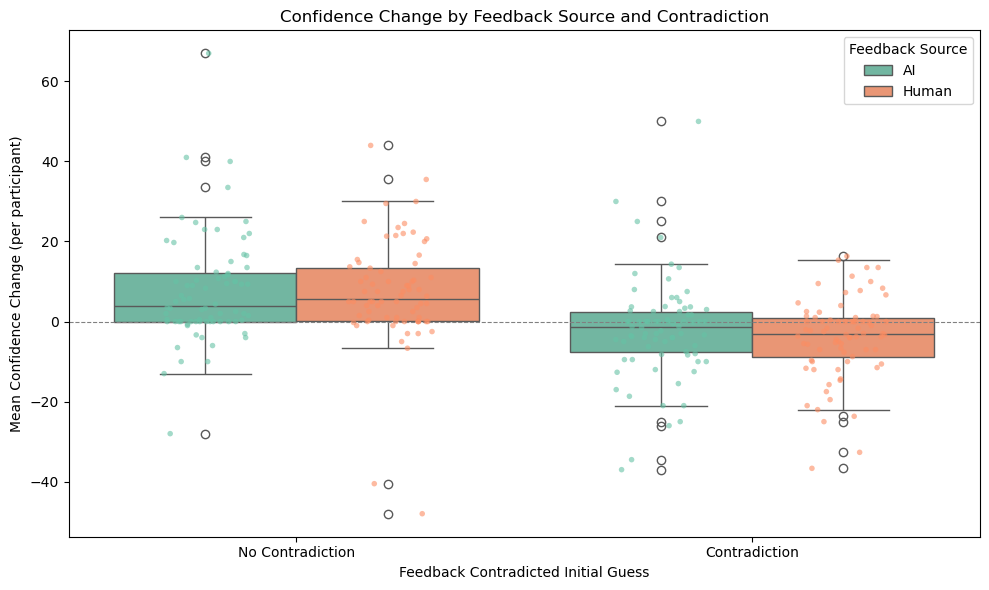

In [930]:
plt.figure(figsize=(10, 6))

# Boxplot: Feedback source within contradiction condition
sns.boxplot(
    data=summary_conf,
    x='feedback_contradicts',
    y='conf_change',
    hue='feedback_source',
    palette='Set2',
)

# Overlay: stripplot
sns.stripplot(
    data=summary_conf,
    x='feedback_contradicts',
    y='conf_change',
    hue='feedback_source',
    dodge=True,
    palette='Set2',
    edgecolor='gray',
    alpha=0.6,
    jitter=0.2,
    size=4,
    legend=False
)

plt.xticks([0, 1], ["No Contradiction", "Contradiction"])
plt.xlabel('Feedback Contradicted Initial Guess')
plt.ylabel('Mean Confidence Change (per participant)')
plt.title('Confidence Change by Feedback Source and Contradiction')
plt.axhline(0, color='gray', linestyle='--', linewidth=0.8)

# Legend
handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(handles[:2], labels[:2], title='Feedback Source', loc='upper right')

plt.tight_layout()
plt.show()


C:\Users\liogr\AppData\Local\Temp\ipykernel_17352\3868400832.py:41: FutureWarning: Use "auto" to set automatic grayscale colors. From v0.14.0, "gray" will default to matplotlib's definition.
  sns.stripplot(


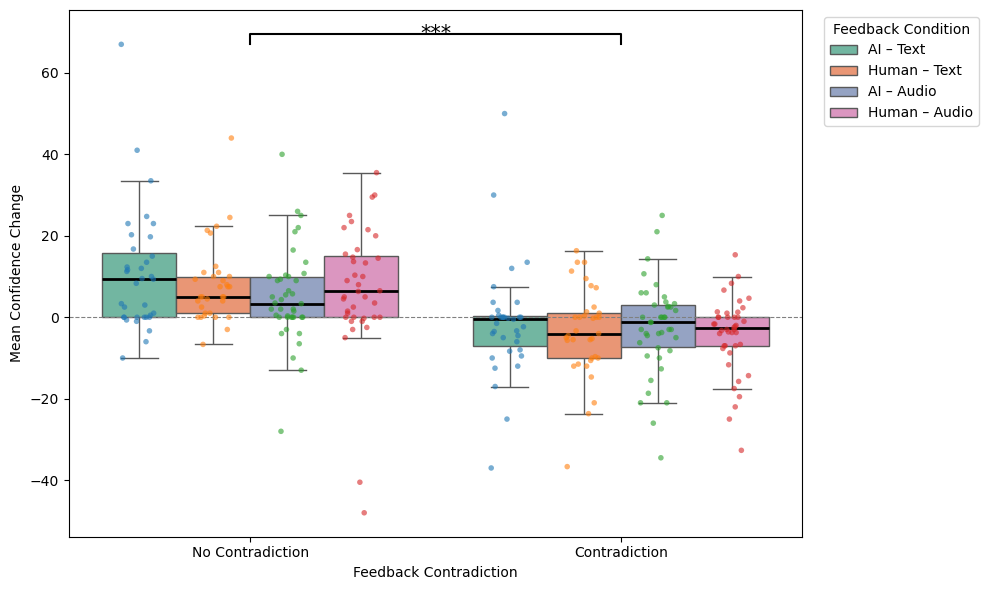

In [931]:
from scipy.stats import ttest_ind
import matplotlib.pyplot as plt
import seaborn as sns

# ✅ Compute mean confidence change per participant
summary_conf = (
    new_df
    .groupby(['participant_id', 'feedback_contradicts', 'feedback_source', 'feedback_type'])['confidence_change']
    .mean()
    .reset_index()
    .rename(columns={'confidence_change': 'conf_change'})
)

# ✅ Create cleaner group labels (AI – Text, etc.)
summary_conf['feedback_group'] = (
    summary_conf['feedback_source'].map({'AI': 'AI', 'Human': 'Human'}) +
    ' – ' +
    summary_conf['feedback_type'].str.capitalize()
)
group_order = ['AI – Text', 'Human – Text', 'AI – Audio', 'Human – Audio']

# ✅ T-test across contradiction (global effect)
conf_no_contradict = summary_conf[summary_conf['feedback_contradicts'] == False]['conf_change']
conf_contradict = summary_conf[summary_conf['feedback_contradicts'] == True]['conf_change']
t_stat, p_val = ttest_ind(conf_contradict, conf_no_contradict, equal_var=False)

# ✅ Boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(
    data=summary_conf,
    x='feedback_contradicts',
    y='conf_change',
    hue='feedback_group',
    hue_order=group_order,
    palette='Set2',
    medianprops={'color': 'black', 'linewidth': 2},
    showfliers=False
)

# ✅ Stripplot overlay
sns.stripplot(
    data=summary_conf,
    x='feedback_contradicts',
    y='conf_change',
    hue='feedback_group',
    hue_order=group_order,
    dodge=True,
    edgecolor='gray',
    alpha=0.6,
    jitter=0.2,
    size=4,
    legend=False
)

# ✅ Axes and formatting
plt.xticks([0, 1], ["No Contradiction", "Contradiction"])
plt.xlabel('Feedback Contradiction')
plt.ylabel('Mean Confidence Change')
plt.axhline(0, color='gray', linestyle='--', linewidth=0.8)

# ✅ Significance annotation
y = max(summary_conf['conf_change']) + 0.05
h = 2.5
x1, x2 = 0, 1
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, color='black')
plt.text((x1 + x2) * 0.5, y + 0.01,
         "***" if p_val < 0.001 else "**" if p_val < 0.01 else "*" if p_val < 0.05 else "n.s.",
         ha='center', va='bottom', fontsize=15)

# ✅ Legend
handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(handles[:4], labels[:4], title='Feedback Condition',
           bbox_to_anchor=(1.02, 1), loc='upper left')

plt.tight_layout()
plt.show()


Δ Confidence Change summary by source & modality:
                                 mean     std  count
feedback_source feedback_type                       
AI              audio          -6.927  14.633     40
                text          -11.971  18.392     35
Human           audio         -10.502  16.147     38
                text          -11.535  14.696     33


C:\Users\liogr\AppData\Local\Temp\ipykernel_17352\1251339729.py:38: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.barplot(


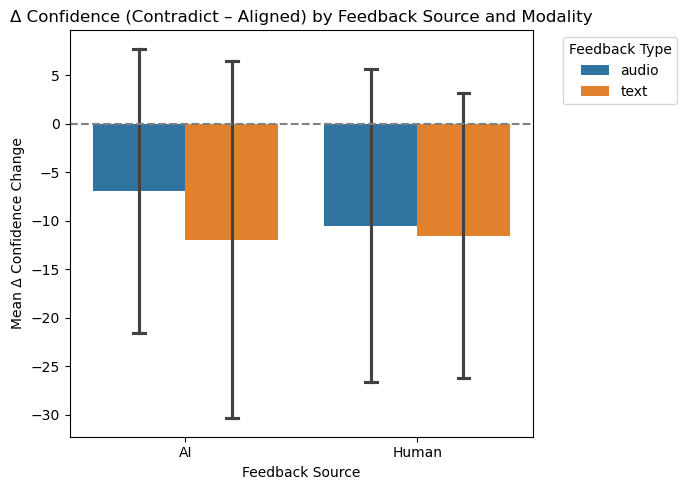

In [932]:
# 1. Aggregate per‐participant confidence change by source, type, and contradiction
delta_conf_df = (
    new_df
    .groupby(['participant_id','feedback_source','feedback_type','feedback_contradicts'])['confidence_change']
    .mean()
    .reset_index()
    .rename(columns={'confidence_change':'conf_change'})
)

# 2. Pivot to wide so each row is participant×source×type
delta_conf_df = delta_conf_df.pivot_table(
    index=['participant_id','feedback_source','feedback_type'],
    columns='feedback_contradicts',
    values='conf_change'
).dropna().reset_index()

# 3. Rename columns for clarity
delta_conf_df.columns = ['participant_id','feedback_source','feedback_type',
                         'conf_aligned','conf_contradict']

# 4. Compute the delta confidence
delta_conf_df['delta_conf'] = delta_conf_df['conf_contradict'] - delta_conf_df['conf_aligned']

# 5. Summary
print("Δ Confidence Change summary by source & modality:")
print(
    delta_conf_df
    .groupby(['feedback_source','feedback_type'])['delta_conf']
    .agg(['mean','std','count'])
    .round(3)
)

# 6. Plot
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(7, 5))
sns.barplot(
    data=delta_conf_df,
    x='feedback_source',
    y='delta_conf',
    hue='feedback_type',
    ci='sd',
    capsize=0.1,
)

plt.axhline(0, color='gray', linestyle='--')
plt.title('Δ Confidence (Contradict – Aligned) by Feedback Source and Modality')
plt.ylabel('Mean Δ Confidence Change')
plt.xlabel('Feedback Source')
plt.legend(title='Feedback Type', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


C:\Users\liogr\AppData\Local\Temp\ipykernel_17352\1765531482.py:5: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.barplot(


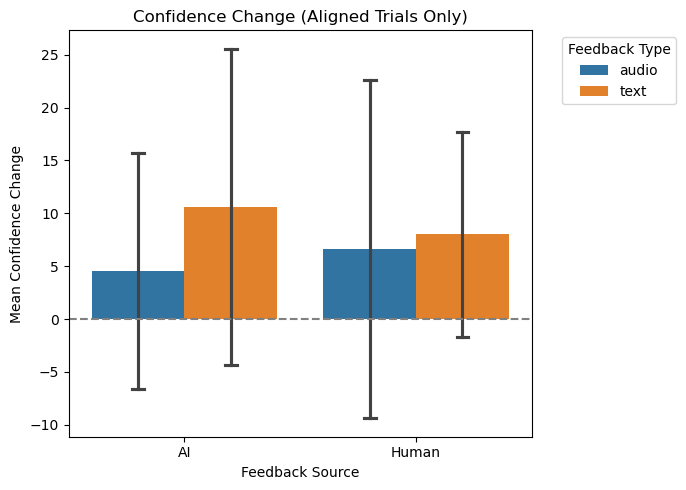

In [933]:
# 1. Already computed in previous step: delta_conf_df includes 'conf_aligned'

# 2. Plot confidence change in aligned trials
plt.figure(figsize=(7, 5))
sns.barplot(
    data=delta_conf_df,
    x='feedback_source',
    y='conf_aligned',
    hue='feedback_type',
    ci='sd',
    capsize=0.1,
)

plt.axhline(0, color='gray', linestyle='--')
plt.title('Confidence Change (Aligned Trials Only)')
plt.ylabel('Mean Confidence Change')
plt.xlabel('Feedback Source')
plt.legend(title='Feedback Type', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


## Hypothesis 3  
Participants' trust in AI feedback will depend on their *AI familiarity* and *technical knowledge*, reflected in changes in confidence and flip rates.

**Steps:**  
1. Filter for AI feedback only:  
   ```python
   ai_only = new_df[new_df['feedback_source'] == 'AI']

2. Compute per-participant metrics:

Mean confidence change:
    ```python
    mean_conf_change = ai_only.groupby('participant_id')['confidence_change'].mean()

Flip rate:
    ```python
    flip_rate = ai_only.groupby('participant_id')['flip'].mean()

3. Merge with individual-level scores: familiarity_score and technical_score (from pre-survey)

**Analysis:**

- Pearson correlation

familiarity_score vs. mean_conf_change

technical_score vs. flip_rate

- Linear regression

flip_rate ~ feedback_source * technical_score

Significant interaction would suggest that technical knowledge moderates the impact of the feedback source.

**Goal:**
Test whether more AI-familiar or technically knowledgeable participants are less likely to change their mind or confidence in response to AI feedback.

In [934]:
from scipy.stats import pearsonr
import statsmodels.formula.api as smf
import pandas as pd

# --- PART 1: Does AI familiarity predict response to AI feedback? ---

# 1. Filter only AI feedback
ai_feedback = new_df[new_df['feedback_source'] == 'AI'].copy()

# 2. Compute mean confidence change and flip rate per participant under AI feedback
ai_summary = (
    ai_feedback
    .groupby(['participant_id', 'familiarity_score'])
    .agg(
        ai_conf_change=('confidence_change', 'mean'),
        ai_flip_rate=('flip', 'mean')
    )
    .reset_index()
)

# 3. Pearson correlation: Familiarity vs. confidence change
r_conf, p_conf = pearsonr(ai_summary['familiarity_score'], ai_summary['ai_conf_change'])
print(f"[Confidence] Familiarity vs. Confidence Change: r = {r_conf:.3f}, p = {p_conf:.4f}")

# 4. Pearson correlation: Familiarity vs. flip rate
r_flip, p_flip = pearsonr(ai_summary['familiarity_score'], ai_summary['ai_flip_rate'])
print(f"[Flip Rate] Familiarity vs. Flip Rate: r = {r_flip:.3f}, p = {p_flip:.4f}")

# 5. Linear regression: Confidence change ~ familiarity
model_conf = smf.ols("ai_conf_change ~ familiarity_score", data=ai_summary).fit()
print("\n[Linear Model: Confidence Change ~ Familiarity Score]")
print(model_conf.summary())

# 6. Linear regression: Flip rate ~ familiarity
model_flip = smf.ols("ai_flip_rate ~ familiarity_score", data=ai_summary).fit()
print("\n[Linear Model: Flip Rate ~ Familiarity Score]")
print(model_flip.summary())


[Confidence] Familiarity vs. Confidence Change: r = -0.172, p = 0.1319
[Flip Rate] Familiarity vs. Flip Rate: r = 0.213, p = 0.0617

[Linear Model: Confidence Change ~ Familiarity Score]
                            OLS Regression Results                            
Dep. Variable:         ai_conf_change   R-squared:                       0.030
Model:                            OLS   Adj. R-squared:                  0.017
Method:                 Least Squares   F-statistic:                     2.320
Date:                Sun, 01 Jun 2025   Prob (F-statistic):              0.132
Time:                        12:54:08   Log-Likelihood:                -285.45
No. Observations:                  78   AIC:                             574.9
Df Residuals:                      76   BIC:                             579.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                       

In [935]:
from scipy.stats import pearsonr
import statsmodels.formula.api as smf
import pandas as pd

# --- PART 2: Does AI technical knowledge predict response to AI feedback? ---

# 1. Filter only AI feedback
ai_feedback = new_df[new_df['feedback_source'] == 'AI'].copy()

# 2. Compute mean confidence change and flip rate per participant under AI feedback
ai_summary = (
    ai_feedback
    .groupby(['participant_id', 'technical_score'])
    .agg(
        ai_conf_change=('confidence_change', 'mean'),
        ai_flip_rate=('flip', 'mean')
    )
    .reset_index()
)

# 3. Pearson correlation: Technical score vs. confidence change
r_conf, p_conf = pearsonr(ai_summary['technical_score'], ai_summary['ai_conf_change'])
print(f"[Confidence] Technical Score vs. Confidence Change: r = {r_conf:.3f}, p = {p_conf:.4f}")

# 4. Pearson correlation: Technical score vs. flip rate
r_flip, p_flip = pearsonr(ai_summary['technical_score'], ai_summary['ai_flip_rate'])
print(f"[Flip Rate] Technical Score vs. Flip Rate: r = {r_flip:.3f}, p = {p_flip:.4f}")

# 5. Linear regression: Confidence change ~ technical score
model_conf = smf.ols("ai_conf_change ~ technical_score", data=ai_summary).fit()
print("\n[Linear Model: Confidence Change ~ Technical Score]")
print(model_conf.summary())

# 6. Linear regression: Flip rate ~ technical score
model_flip = smf.ols("ai_flip_rate ~ technical_score", data=ai_summary).fit()
print("\n[Linear Model: Flip Rate ~ Technical Score]")
print(model_flip.summary())


[Confidence] Technical Score vs. Confidence Change: r = -0.089, p = 0.4380
[Flip Rate] Technical Score vs. Flip Rate: r = -0.037, p = 0.7480

[Linear Model: Confidence Change ~ Technical Score]
                            OLS Regression Results                            
Dep. Variable:         ai_conf_change   R-squared:                       0.008
Model:                            OLS   Adj. R-squared:                 -0.005
Method:                 Least Squares   F-statistic:                    0.6078
Date:                Sun, 01 Jun 2025   Prob (F-statistic):              0.438
Time:                        12:54:08   Log-Likelihood:                -286.31
No. Observations:                  78   AIC:                             576.6
Df Residuals:                      76   BIC:                             581.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                

In [936]:
import statsmodels.formula.api as smf

# --- PART 3: Combined and interaction effects of familiarity and technical knowledge (AI only) ---

# 1. Filter only AI feedback again
ai_feedback = new_df[new_df['feedback_source'] == 'AI'].copy()

# 2. Compute per-participant averages
ai_summary = (
    ai_feedback
    .groupby(['participant_id', 'familiarity_score', 'technical_score'])
    .agg(
        ai_conf_change=('confidence_change', 'mean'),
        ai_flip_rate=('flip', 'mean')
    )
    .reset_index()
)

# Optional: Center predictors for interaction model
ai_summary['familiarity_c'] = ai_summary['familiarity_score'] - ai_summary['familiarity_score'].mean()
ai_summary['technical_c'] = ai_summary['technical_score'] - ai_summary['technical_score'].mean()

# 3. Linear regression: Confidence change ~ familiarity + technical
model_conf_both = smf.ols("ai_conf_change ~ familiarity_score + technical_score", data=ai_summary).fit()
print("\n[Linear Model: Confidence Change ~ Familiarity + Technical Score]")
print(model_conf_both.summary())

# 4. Linear regression: Flip rate ~ familiarity + technical
model_flip_both = smf.ols("ai_flip_rate ~ familiarity_score + technical_score", data=ai_summary).fit()
print("\n[Linear Model: Flip Rate ~ Familiarity + Technical Score]")
print(model_flip_both.summary())

# 5. Interaction model: Flip rate ~ familiarity × technical (centered)
model_interact = smf.ols("ai_flip_rate ~ familiarity_c * technical_c", data=ai_summary).fit()
print("\n[Interaction Model: Flip Rate ~ Familiarity × Technical Knowledge (Centered)]")
print(model_interact.summary())



[Linear Model: Confidence Change ~ Familiarity + Technical Score]
                            OLS Regression Results                            
Dep. Variable:         ai_conf_change   R-squared:                       0.031
Model:                            OLS   Adj. R-squared:                  0.005
Method:                 Least Squares   F-statistic:                     1.180
Date:                Sun, 01 Jun 2025   Prob (F-statistic):              0.313
Time:                        12:54:08   Log-Likelihood:                -285.41
No. Observations:                  78   AIC:                             576.8
Df Residuals:                      75   BIC:                             583.9
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------

In [937]:
print("🧠 Summary of Linear Models (AI Feedback Only):\n")

# Model 1: Confidence Change
print(f"📉 [Confidence Change] R² = {model_conf_both.rsquared:.3f}, p = {model_conf_both.f_pvalue:.3f}")
print(f"  → Familiarity: coef = {model_conf_both.params['familiarity_score']:.3f}, p = {model_conf_both.pvalues['familiarity_score']:.3f}")
print(f"  → Technical Knowledge: coef = {model_conf_both.params['technical_score']:.3f}, p = {model_conf_both.pvalues['technical_score']:.3f}")

# Model 2: Flip Rate
print(f"\n🔁 [Flip Rate] R² = {model_flip_both.rsquared:.3f}, p = {model_flip_both.f_pvalue:.3f}")
print(f"  → Familiarity: coef = {model_flip_both.params['familiarity_score']:.3f}, p = {model_flip_both.pvalues['familiarity_score']:.3f}")
print(f"  → Technical Knowledge: coef = {model_flip_both.params['technical_score']:.3f}, p = {model_flip_both.pvalues['technical_score']:.3f}")

# Model 3: Interaction
print(f"\n🔀 [Interaction: Flip Rate ~ Familiarity × Technical] R² = {model_interact.rsquared:.3f}, p = {model_interact.f_pvalue:.3f}")
print(f"  → Familiarity (centered): coef = {model_interact.params['familiarity_c']:.3f}, p = {model_interact.pvalues['familiarity_c']:.3f}")
print(f"  → Technical (centered): coef = {model_interact.params['technical_c']:.3f}, p = {model_interact.pvalues['technical_c']:.3f}")
print(f"  → Interaction: coef = {model_interact.params['familiarity_c:technical_c']:.3f}, p = {model_interact.pvalues['familiarity_c:technical_c']:.3f}")


🧠 Summary of Linear Models (AI Feedback Only):

📉 [Confidence Change] R² = 0.031, p = 0.313
  → Familiarity: coef = -8.649, p = 0.190
  → Technical Knowledge: coef = -1.641, p = 0.795

🔁 [Flip Rate] R² = 0.060, p = 0.099
  → Familiarity: coef = 0.277, p = 0.034
  → Technical Knowledge: coef = -0.133, p = 0.285

🔀 [Interaction: Flip Rate ~ Familiarity × Technical] R² = 0.064, p = 0.180
  → Familiarity (centered): coef = 0.299, p = 0.030
  → Technical (centered): coef = -0.152, p = 0.241
  → Interaction: coef = 0.403, p = 0.585


### 2. Visual Analysis

We now explore how familiarity and technical knowledge relate to confidence change and flip rate under AI feedback.

#### 2.1 – Scatterplots (Correlations)

- Familiarity vs. Confidence Change (AI feedback)
- Familiarity vs. Flip Rate (AI feedback)
- Technical Score vs. Confidence Change (AI feedback)
- Technical Score vs. Flip Rate (AI feedback)


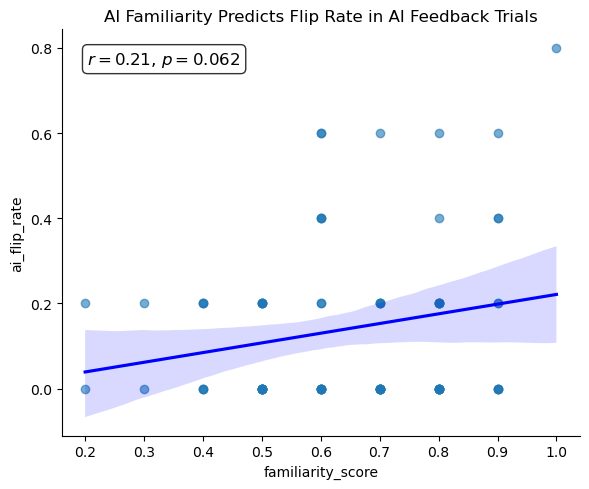

In [938]:
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

# Compute correlation
r, p = pearsonr(ai_summary['familiarity_score'], ai_summary['ai_flip_rate'])

# Plot
g = sns.lmplot(
    data=ai_summary,
    x='familiarity_score',
    y='ai_flip_rate',
    ci=95,
    scatter_kws={'alpha': 0.6},
    line_kws={'color': 'blue'},
    height=5,
    aspect=1.2
)

# Annotate with r and p
ax = g.ax
ax.text(
    0.05, 0.95,
    f"$r = {r:.2f}$, $p = {p:.3f}$",
    transform=ax.transAxes,
    fontsize=12,
    verticalalignment='top',
    bbox=dict(boxstyle="round", facecolor="white", alpha=0.8)
)

plt.title("AI Familiarity Predicts Flip Rate in AI Feedback Trials")
plt.tight_layout()
plt.show()


familiarity_bin
Low       38
High      26
Medium    14
Name: count, dtype: int64


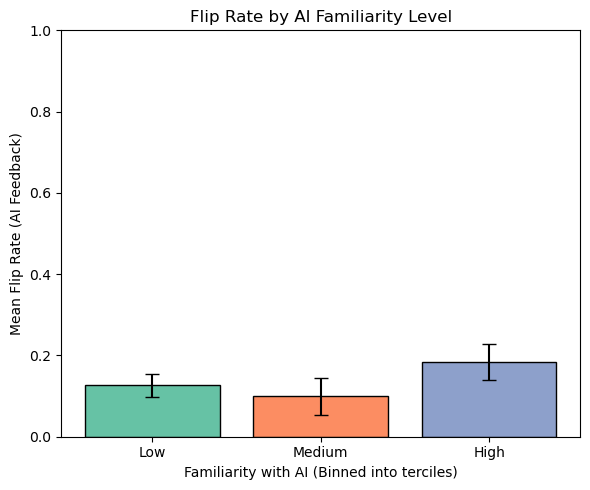

In [939]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# qcut creates 3 bins with equal number of participants
ai_summary['familiarity_bin'] = pd.qcut(
    ai_summary['familiarity_score'],
    q=3,
    labels=['Low', 'Medium', 'High']
)

# Check again
print(ai_summary['familiarity_bin'].value_counts())

# Compute mean + SEM for each familiarity bin
bin_means = (
    ai_summary
    .groupby('familiarity_bin', observed=True)['ai_flip_rate']
    .agg(['mean', 'sem'])
    .reset_index()
)

# Plot with error bars
plt.figure(figsize=(6, 5))
plt.bar(
    x=bin_means['familiarity_bin'],
    height=bin_means['mean'],
    yerr=bin_means['sem'],
    capsize=5,
    color=sns.color_palette('Set2'),
    edgecolor='black'
)
plt.ylabel('Mean Flip Rate (AI Feedback)')
plt.xlabel('Familiarity with AI (Binned into terciles)')
plt.title('Flip Rate by AI Familiarity Level')
plt.ylim(0, 1)
plt.tight_layout()
plt.show()


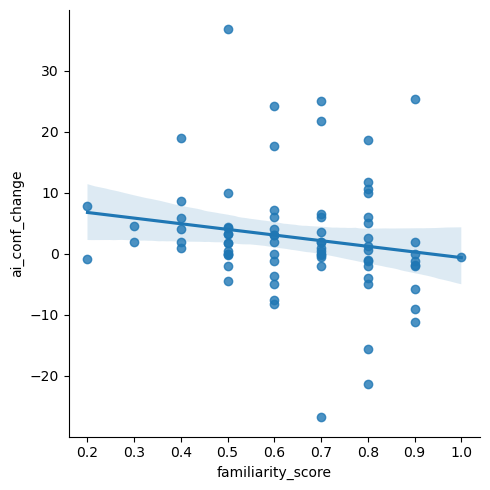

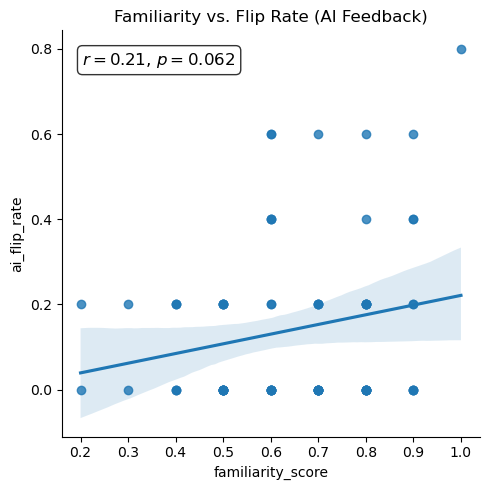

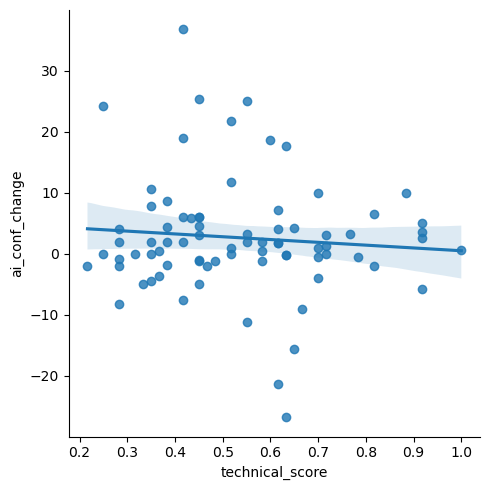

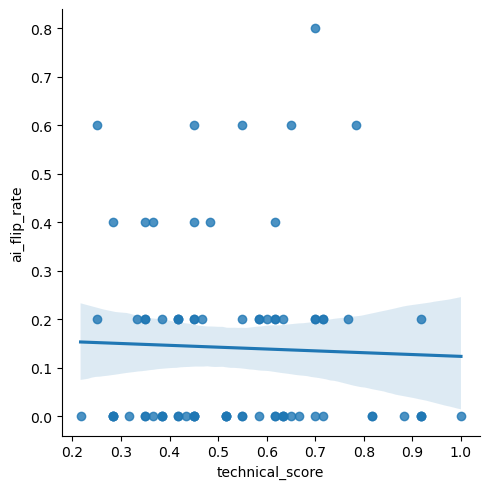

In [940]:
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

sns.lmplot(data=ai_summary, x='familiarity_score', y='ai_conf_change')
g = sns.lmplot(
    data=ai_summary,
    x='familiarity_score',
    y='ai_flip_rate',
)

# Step 2: Compute Pearson correlation and p-value
r, p = pearsonr(ai_summary['familiarity_score'], ai_summary['ai_flip_rate'])

# Step 3: Add annotation (on the Axes inside the FacetGrid)
ax = g.ax                         # equivalent to plt.gca() when using lmplot
text = f"$r = {r:.2f}$, $p = {p:.3f}$"
ax.text(
    0.05,                        # x-coordinate (adjust to where you want the text)
    0.95,                        # y-coordinate (in axis coords if using transform)
    text,
    transform=ax.transAxes,     # interpret (x, y) as axes fraction [0, 1]
    fontsize=12,
    verticalalignment='top',
    bbox=dict(boxstyle="round", facecolor="white", alpha=0.8)
)

plt.title("Familiarity vs. Flip Rate (AI Feedback)")
plt.tight_layout()
plt.show()
sns.lmplot(data=ai_summary, x='technical_score', y='ai_conf_change')
sns.lmplot(data=ai_summary, x='technical_score', y='ai_flip_rate')


#### 2.2 – Interaction Plots

- Confidence Change vs. Technical score, by Feedback Source  (AI vs. Human)
- Flip Rate vs. Technical Score, by Feedback Source
- Confidence Change vs. Familiarity, by Feedback Source
- Flip Rate vs. Familiarity, by Feedback Source

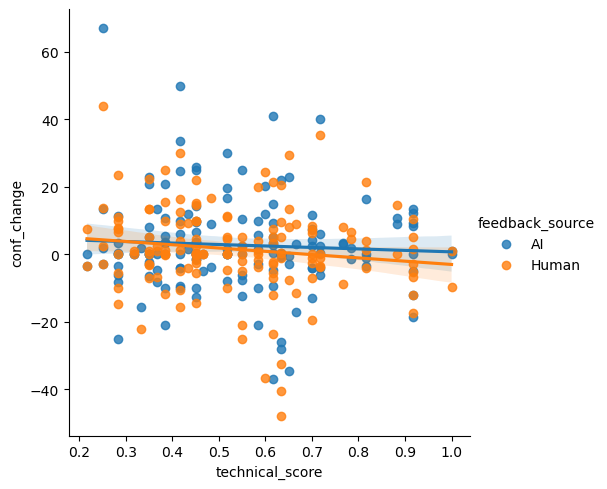

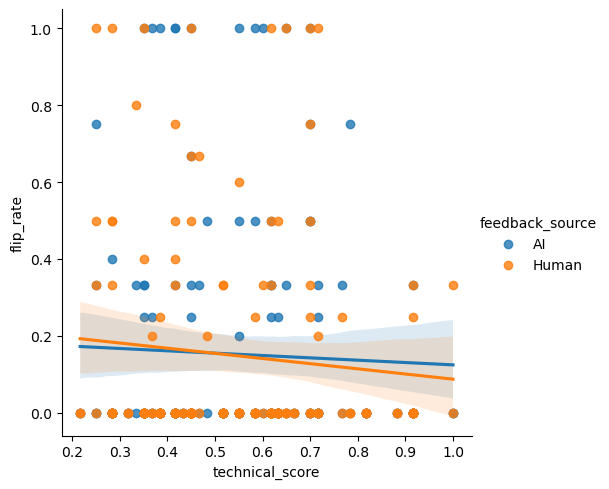

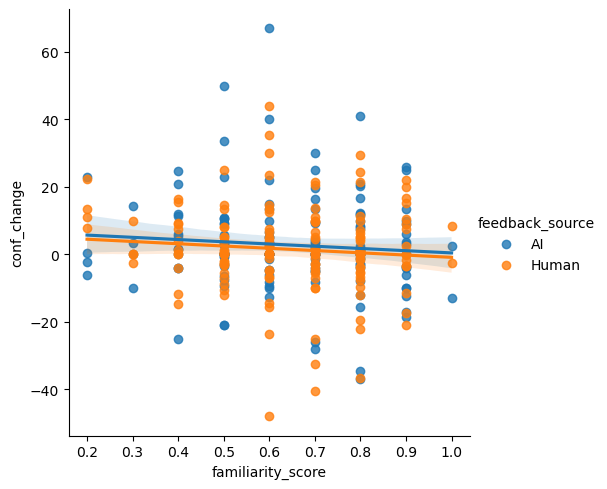

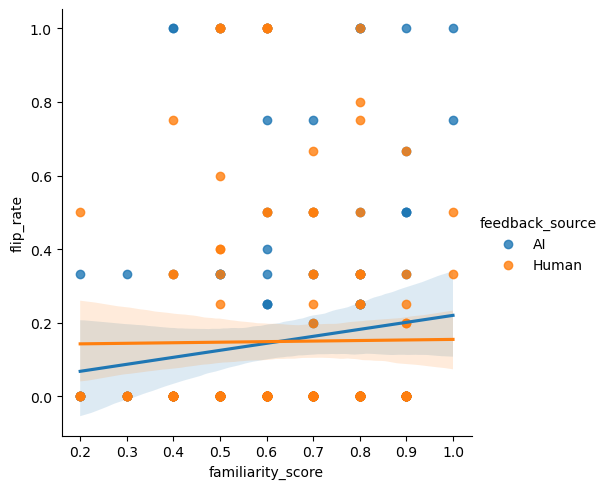

In [941]:
summary_all = (
    new_df
    .groupby(['participant_id', 'feedback_source', 'feedback_contradicts',
              'familiarity_score', 'technical_score'])
    .agg(
        conf_change=('confidence_change', 'mean'),
        flip_rate=('flip', 'mean')
    )
    .reset_index()
)


summary_all['familiarity_bin'] = pd.qcut(summary_all['familiarity_score'], q=3, labels=['Low', 'Medium', 'High'])
summary_all['technical_bin'] = pd.qcut(summary_all['technical_score'], q=3, labels=['Low', 'Medium', 'High'])


sns.lmplot(data=summary_all, x='technical_score', y='conf_change', hue='feedback_source')
sns.lmplot(data=summary_all, x='technical_score', y='flip_rate', hue='feedback_source')
sns.lmplot(data=summary_all, x='familiarity_score', y='conf_change', hue='feedback_source')
sns.lmplot(data=summary_all, x='familiarity_score', y='flip_rate', hue='feedback_source')



#### 2.3 – Heatmaps (Optional)

- Familiarity × Technical Score → Mean Flip Rate
- Familiarity × Technical Score → Mean Confidence Change

C:\Users\liogr\AppData\Local\Temp\ipykernel_17352\3967428381.py:5: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot_flip = summary_all.pivot_table(


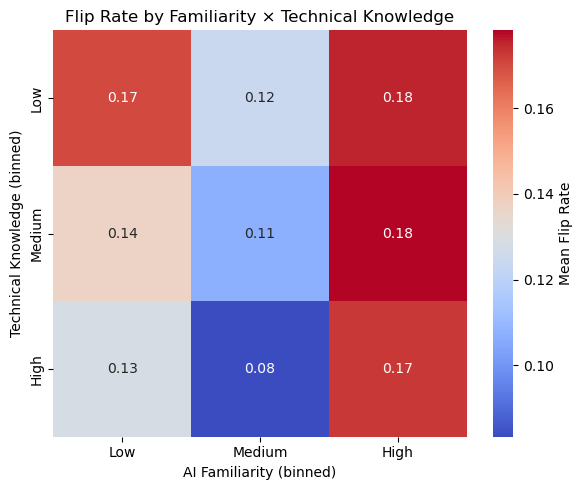

C:\Users\liogr\AppData\Local\Temp\ipykernel_17352\3967428381.py:21: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot_conf = summary_all.pivot_table(


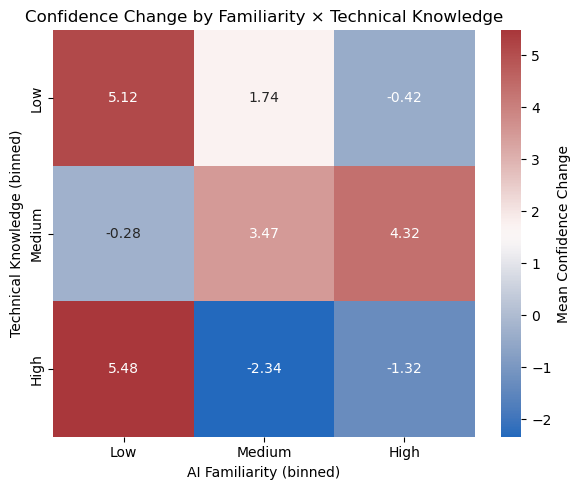

In [942]:
summary_all['familiarity_bin'] = pd.qcut(summary_all['familiarity_score'], q=3, labels=['Low', 'Medium', 'High'])
summary_all['technical_bin'] = pd.qcut(summary_all['technical_score'], q=3, labels=['Low', 'Medium', 'High'])

# 2. Create heatmap: Technical × Familiarity → Mean Flip Rate
pivot_flip = summary_all.pivot_table(
    index='technical_bin',
    columns='familiarity_bin',
    values='flip_rate',
    aggfunc='mean'
)

plt.figure(figsize=(6, 5))
sns.heatmap(pivot_flip, annot=True, fmt=".2f", cmap='coolwarm', cbar_kws={'label': 'Mean Flip Rate'})
plt.title("Flip Rate by Familiarity × Technical Knowledge")
plt.ylabel("Technical Knowledge (binned)")
plt.xlabel("AI Familiarity (binned)")
plt.tight_layout()
plt.show()

# 3. Create heatmap: Technical × Familiarity → Mean Confidence Change
pivot_conf = summary_all.pivot_table(
    index='technical_bin',
    columns='familiarity_bin',
    values='conf_change',
    aggfunc='mean'
)

plt.figure(figsize=(6, 5))
sns.heatmap(pivot_conf, annot=True, fmt=".2f", cmap='vlag', cbar_kws={'label': 'Mean Confidence Change'})
plt.title("Confidence Change by Familiarity × Technical Knowledge")
plt.ylabel("Technical Knowledge (binned)")
plt.xlabel("AI Familiarity (binned)")
plt.tight_layout()
plt.show()


##### Separating contradicting and non contradicting feedback

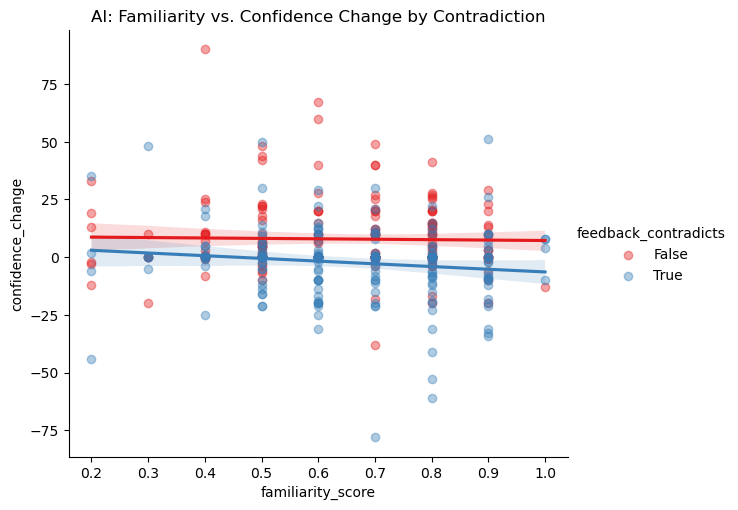

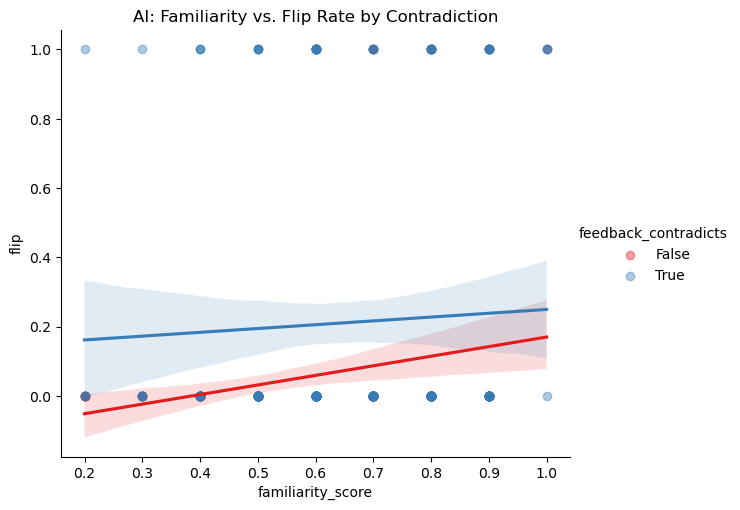

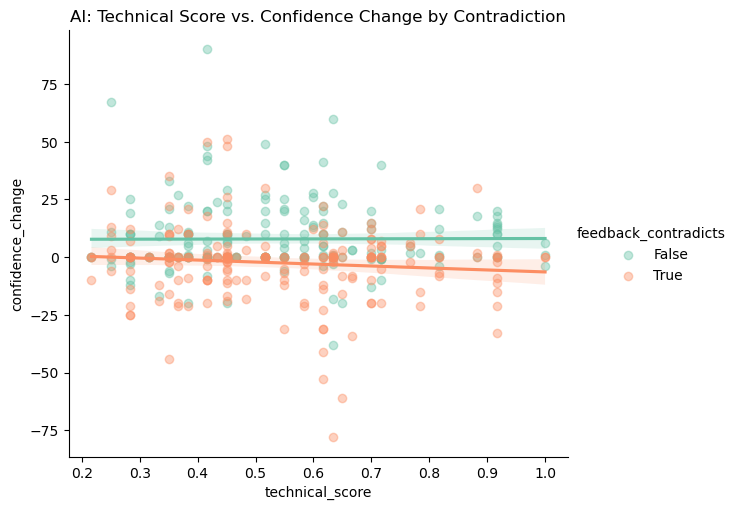

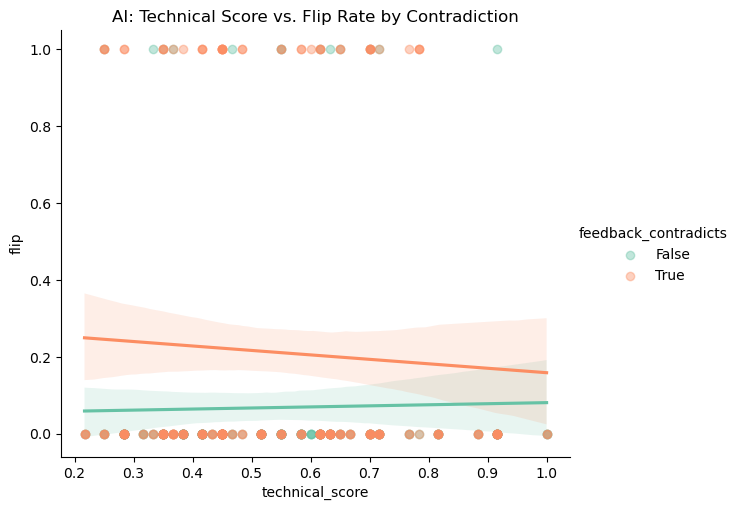

In [943]:
# Plot 1 – Familiarity vs. Confidence Change (AI only), split by contradiction
sns.lmplot(
    data=ai_feedback,
    x='familiarity_score',
    y='confidence_change',
    hue='feedback_contradicts',
    palette='Set1',
    scatter_kws={'alpha': 0.4},
    height=5,
    aspect=1.2
)
plt.title('AI: Familiarity vs. Confidence Change by Contradiction')
plt.show()

# Plot 2 – Familiarity vs. Flip (binary), split by contradiction
sns.lmplot(
    data=ai_feedback,
    x='familiarity_score',
    y='flip',
    hue='feedback_contradicts',
    palette='Set1',
    scatter_kws={'alpha': 0.4},
    height=5,
    aspect=1.2
)
plt.title('AI: Familiarity vs. Flip Rate by Contradiction')
plt.show()

# Plot 3 – Technical Score vs. Confidence Change, split by contradiction
sns.lmplot(
    data=ai_feedback,
    x='technical_score',
    y='confidence_change',
    hue='feedback_contradicts',
    palette='Set2',
    scatter_kws={'alpha': 0.4},
    height=5,
    aspect=1.2
)
plt.title('AI: Technical Score vs. Confidence Change by Contradiction')
plt.show()

# Plot 4 – Technical Score vs. Flip Rate, split by contradiction
sns.lmplot(
    data=ai_feedback,
    x='technical_score',
    y='flip',
    hue='feedback_contradicts',
    palette='Set2',
    scatter_kws={'alpha': 0.4},
    height=5,
    aspect=1.2
)
plt.title('AI: Technical Score vs. Flip Rate by Contradiction')
plt.show()

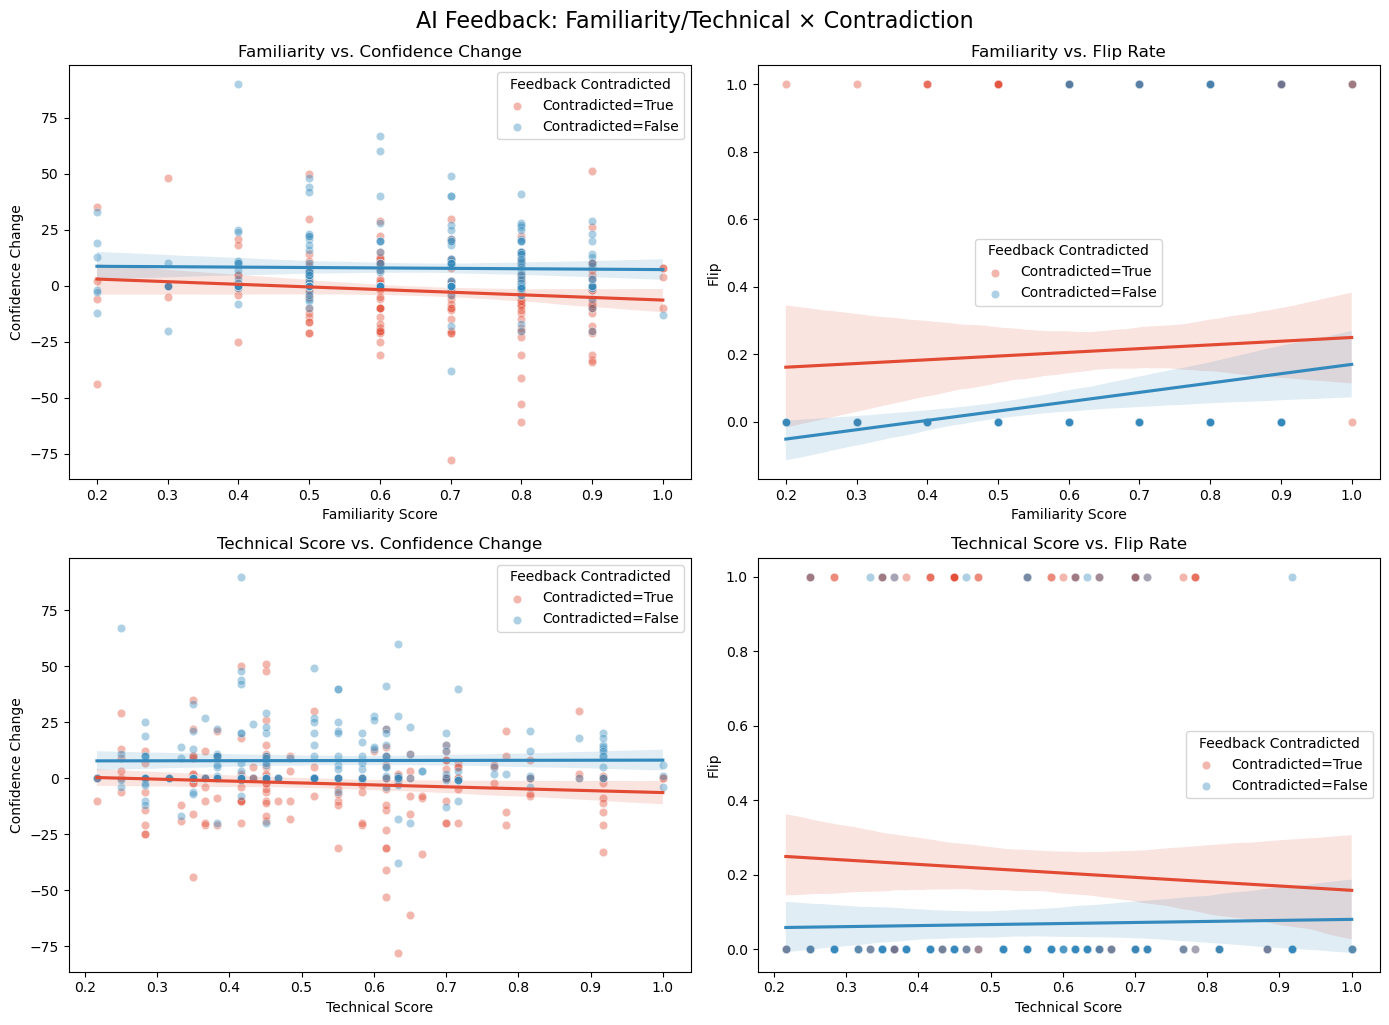

In [944]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set up 2×2 figure
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Define shared styling
hue_order = [True, False]
palette = {'True': '#E24A33', 'False': '#348ABD'}

# Plot 1: Familiarity vs. Confidence Change
for val in hue_order:
    subset = ai_feedback[ai_feedback['feedback_contradicts'] == val]
    sns.scatterplot(data=subset, x='familiarity_score', y='confidence_change',
                    label=f'Contradicted={val}', color=palette[str(val)], alpha=0.4, ax=axes[0, 0])
    sns.regplot(data=subset, x='familiarity_score', y='confidence_change',
                scatter=False, color=palette[str(val)], ax=axes[0, 0])
axes[0, 0].set_title('Familiarity vs. Confidence Change')

# Plot 2: Familiarity vs. Flip Rate
for val in hue_order:
    subset = ai_feedback[ai_feedback['feedback_contradicts'] == val]
    sns.scatterplot(data=subset, x='familiarity_score', y='flip',
                    label=f'Contradicted={val}', color=palette[str(val)], alpha=0.4, ax=axes[0, 1])
    sns.regplot(data=subset, x='familiarity_score', y='flip',
                scatter=False, color=palette[str(val)], ax=axes[0, 1])
axes[0, 1].set_title('Familiarity vs. Flip Rate')

# Plot 3: Technical Score vs. Confidence Change
for val in hue_order:
    subset = ai_feedback[ai_feedback['feedback_contradicts'] == val]
    sns.scatterplot(data=subset, x='technical_score', y='confidence_change',
                    label=f'Contradicted={val}', color=palette[str(val)], alpha=0.4, ax=axes[1, 0])
    sns.regplot(data=subset, x='technical_score', y='confidence_change',
                scatter=False, color=palette[str(val)], ax=axes[1, 0])
axes[1, 0].set_title('Technical Score vs. Confidence Change')

# Plot 4: Technical Score vs. Flip Rate
for val in hue_order:
    subset = ai_feedback[ai_feedback['feedback_contradicts'] == val]
    sns.scatterplot(data=subset, x='technical_score', y='flip',
                    label=f'Contradicted={val}', color=palette[str(val)], alpha=0.4, ax=axes[1, 1])
    sns.regplot(data=subset, x='technical_score', y='flip',
                scatter=False, color=palette[str(val)], ax=axes[1, 1])
axes[1, 1].set_title('Technical Score vs. Flip Rate')

# Tidy layout
for ax in axes.flatten():
    ax.legend(title='Feedback Contradicted')
    ax.set_xlabel(ax.get_xlabel().replace('_', ' ').title())
    ax.set_ylabel(ax.get_ylabel().replace('_', ' ').title())

plt.tight_layout()
plt.suptitle("AI Feedback: Familiarity/Technical × Contradiction", fontsize=16, y=1.02)
plt.show()


C:\Users\liogr\AppData\Local\Temp\ipykernel_17352\1820828865.py:14: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot_flip = subset.pivot_table(
C:\Users\liogr\AppData\Local\Temp\ipykernel_17352\1820828865.py:22: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot_conf = subset.pivot_table(
C:\Users\liogr\AppData\Local\Temp\ipykernel_17352\1820828865.py:14: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot_flip = subset.pivot_table(
C:\Users\liogr\AppData\Local\Temp\ipykernel_17352\1820828865.py:22:

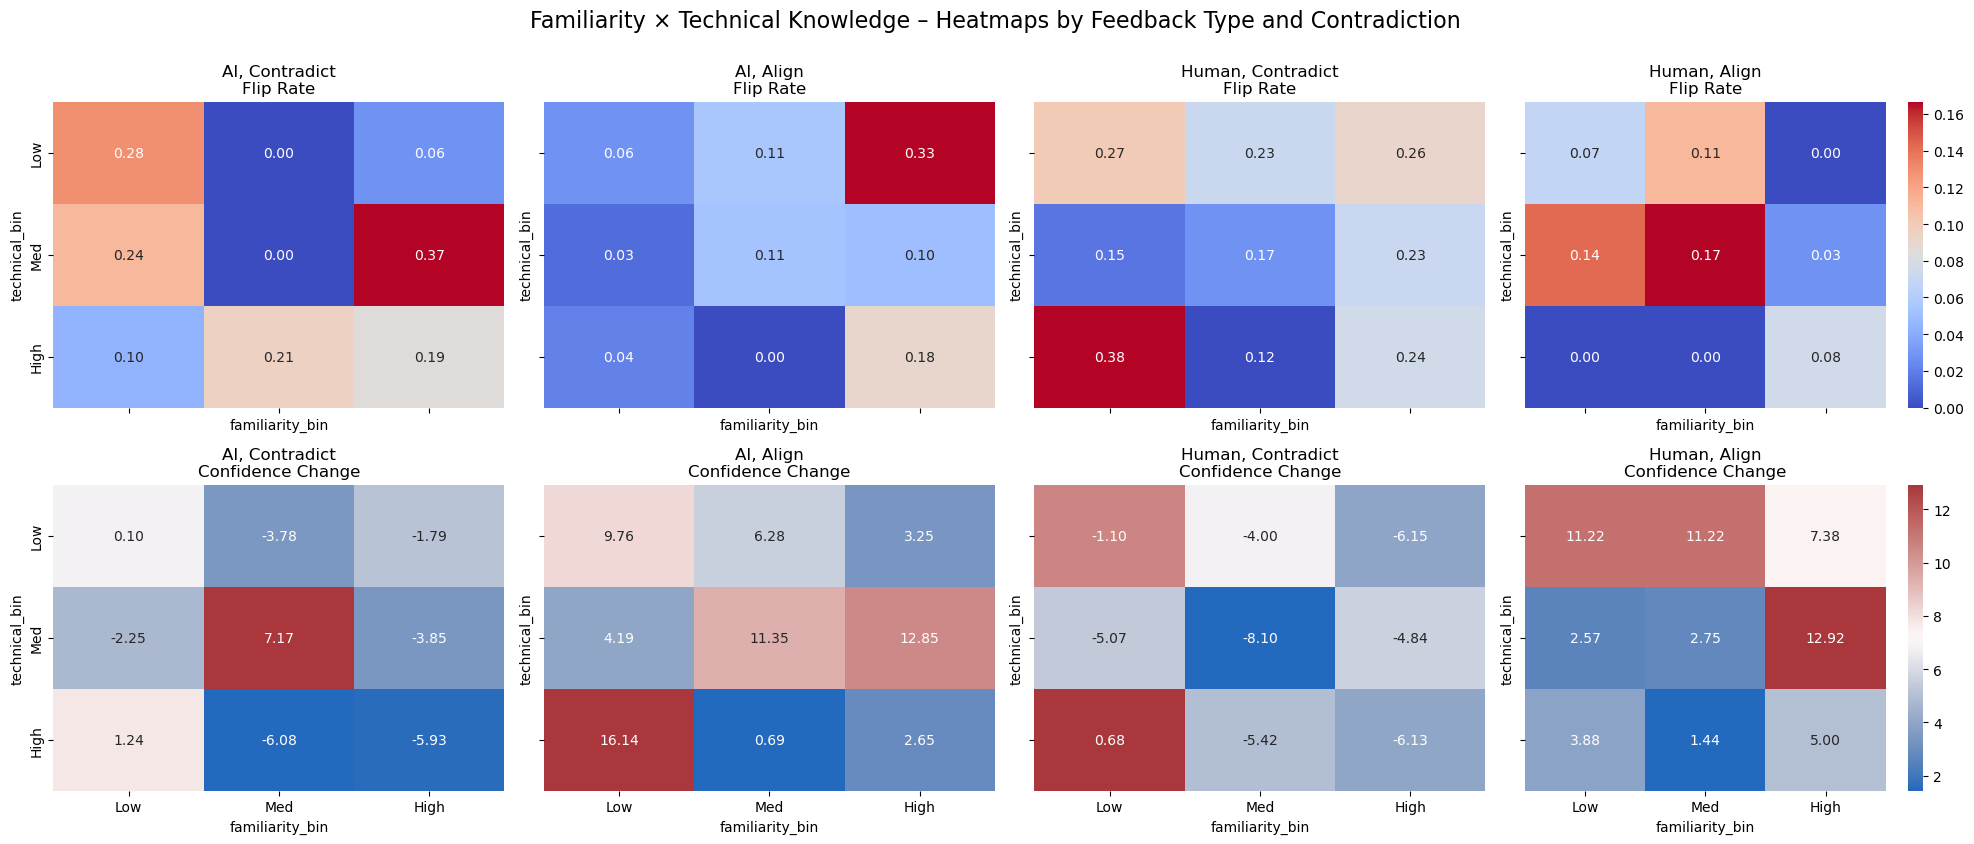

In [945]:
fig, axes = plt.subplots(2, 4, figsize=(20, 8), sharex=True, sharey=True)

for i, source in enumerate(['AI', 'Human']):
    for j, contradiction in enumerate([True, False]):
        subset = summary_all[
            (summary_all['feedback_source'] == source) &
            (summary_all['feedback_contradicts'] == contradiction)
        ].copy()

        subset['familiarity_bin'] = pd.qcut(subset['familiarity_score'], q=3, labels=['Low', 'Med', 'High'])
        subset['technical_bin'] = pd.qcut(subset['technical_score'], q=3, labels=['Low', 'Med', 'High'])

        # Flip Rate Heatmap
        pivot_flip = subset.pivot_table(
            index='technical_bin', columns='familiarity_bin', values='flip_rate', aggfunc='mean'
        )
        ax_flip = axes[0, 2*i + j]
        sns.heatmap(pivot_flip, annot=True, fmt=".2f", cmap='coolwarm', cbar=(i==1 and j==1), ax=ax_flip)
        ax_flip.set_title(f"{source}, {'Contradict' if contradiction else 'Align'}\nFlip Rate")

        # Confidence Change Heatmap
        pivot_conf = subset.pivot_table(
            index='technical_bin', columns='familiarity_bin', values='conf_change', aggfunc='mean'
        )
        ax_conf = axes[1, 2*i + j]
        sns.heatmap(pivot_conf, annot=True, fmt=".2f", cmap='vlag', cbar=(i==1 and j==1), ax=ax_conf)
        ax_conf.set_title(f"{source}, {'Contradict' if contradiction else 'Align'}\nConfidence Change")

plt.tight_layout()
plt.suptitle("Familiarity × Technical Knowledge – Heatmaps by Feedback Type and Contradiction", fontsize=16, y=1.05)
plt.show()


##### Feedback type (audio vs text)

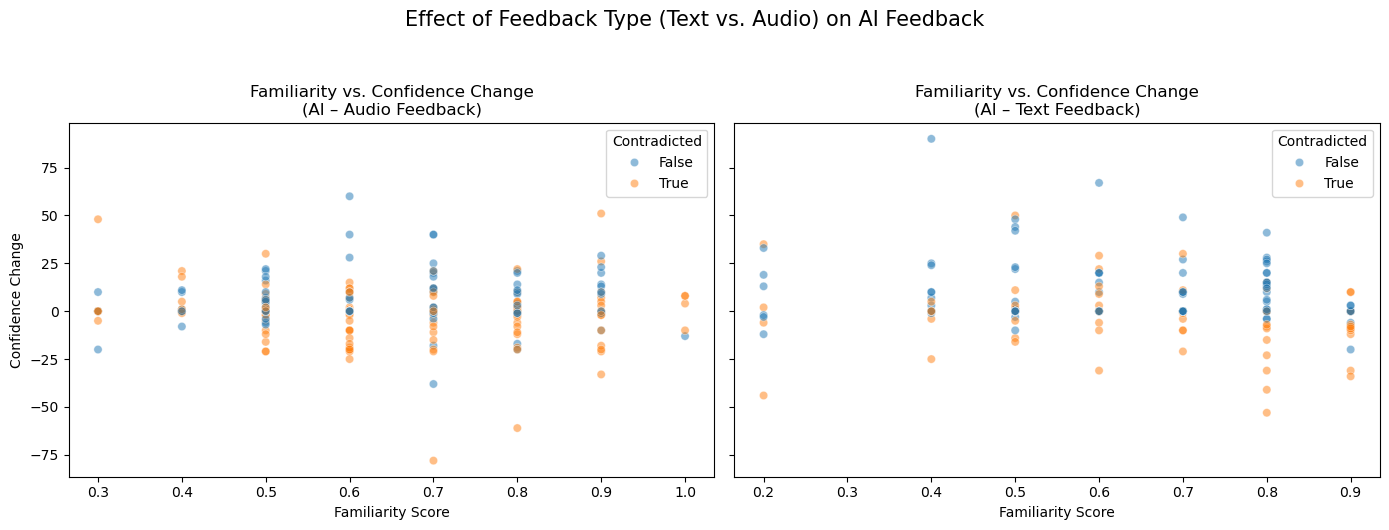

In [946]:

fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=True)

for i, fb_type in enumerate(['audio', 'text']):
    subset = ai_feedback[ai_feedback['feedback_type'] == fb_type]
    sns.scatterplot(
        data=subset,
        x='familiarity_score',
        y='confidence_change',
        hue='feedback_contradicts',
        alpha=0.5,
        ax=axes[i]
    )
    axes[i].set_title(f'Familiarity vs. Confidence Change\n(AI – {fb_type.capitalize()} Feedback)')
    axes[i].set_xlabel("Familiarity Score")
    axes[i].set_ylabel("Confidence Change")
    axes[i].legend(title='Contradicted')

plt.suptitle("Effect of Feedback Type (Text vs. Audio) on AI Feedback", fontsize=15, y=1.05)
plt.tight_layout()
plt.show()

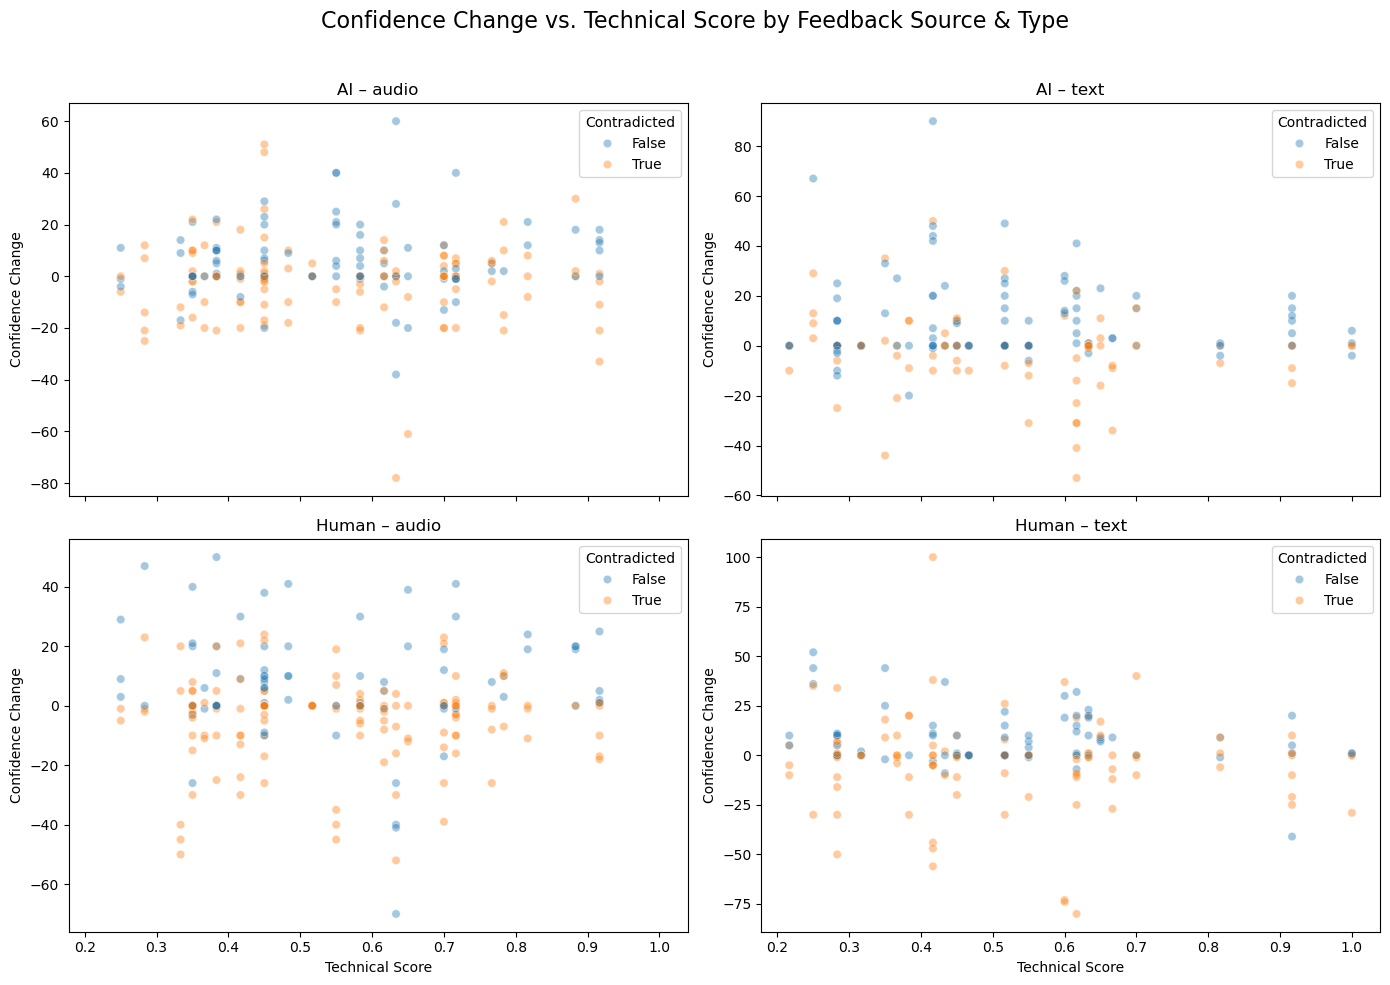

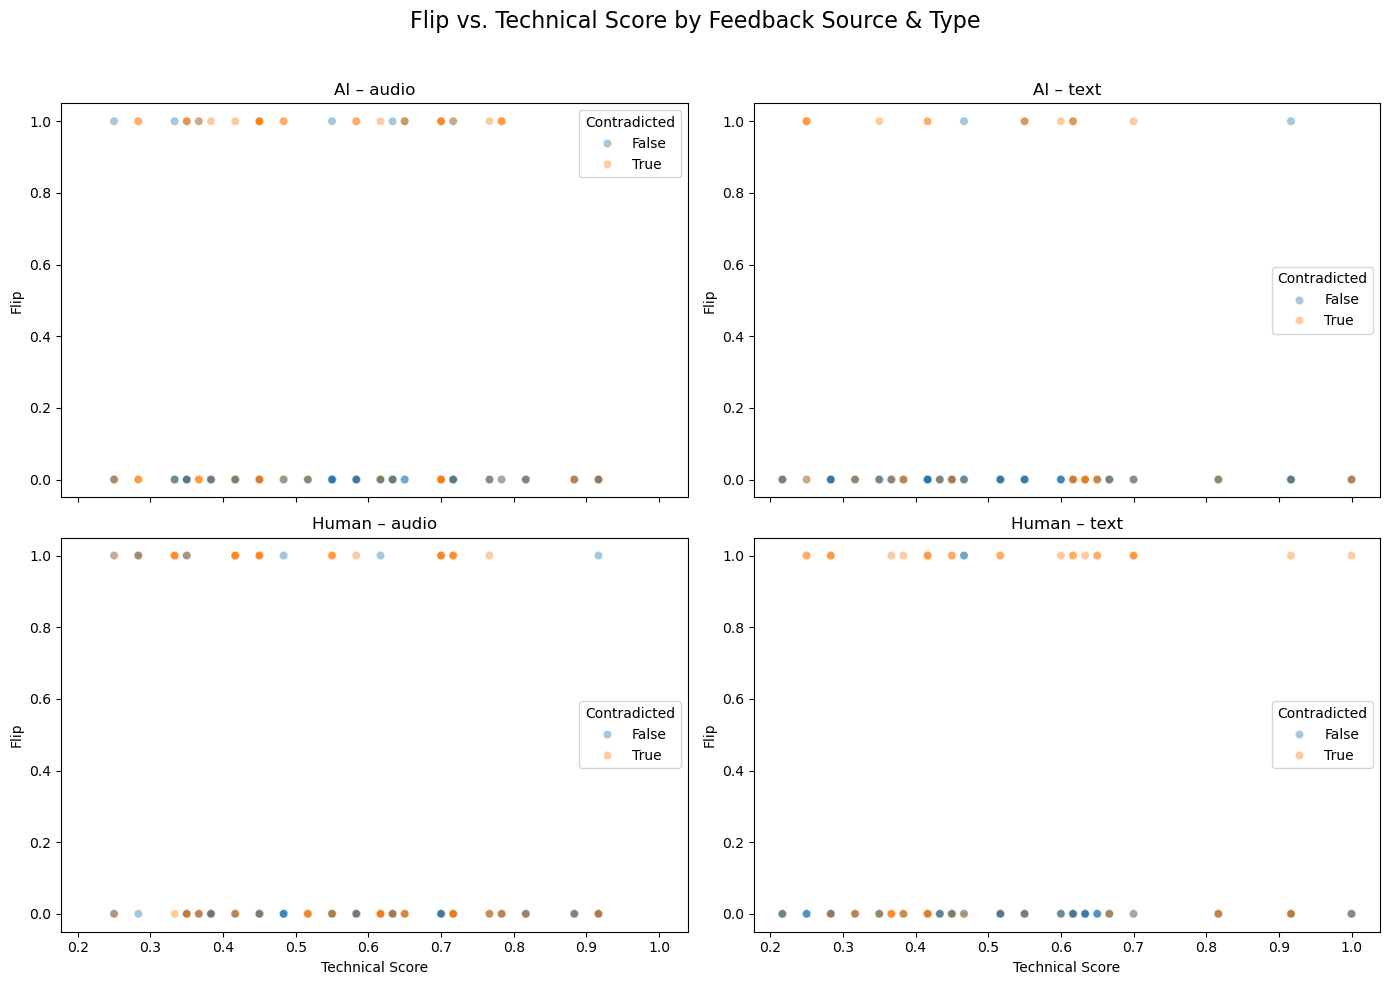

In [947]:
import seaborn as sns
import matplotlib.pyplot as plt

# Define your parameters
outcomes = ['confidence_change', 'flip']  # Could add 'reaction_time', etc.
sources = ['AI', 'Human']
types = ['audio', 'text']

# Generate plots
for outcome in outcomes:
    fig, axes = plt.subplots(2, 2, figsize=(14, 10), sharex=True, sharey=False)
    fig.suptitle(f"{outcome.replace('_', ' ').title()} vs. Technical Score by Feedback Source & Type", fontsize=16)

    for i, source in enumerate(sources):
        for j, fb_type in enumerate(types):
            subset = new_df[
                (new_df['feedback_source'] == source) &
                (new_df['feedback_type'] == fb_type)
            ]

            sns.scatterplot(
                data=subset,
                x='technical_score',
                y=outcome,
                hue='feedback_contradicts',
                alpha=0.4,
                ax=axes[i, j]
            )
            axes[i, j].set_title(f"{source} – {fb_type}")
            axes[i, j].set_xlabel("Technical Score")
            axes[i, j].set_ylabel(outcome.replace('_', ' ').title())
            axes[i, j].legend(title="Contradicted")

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()


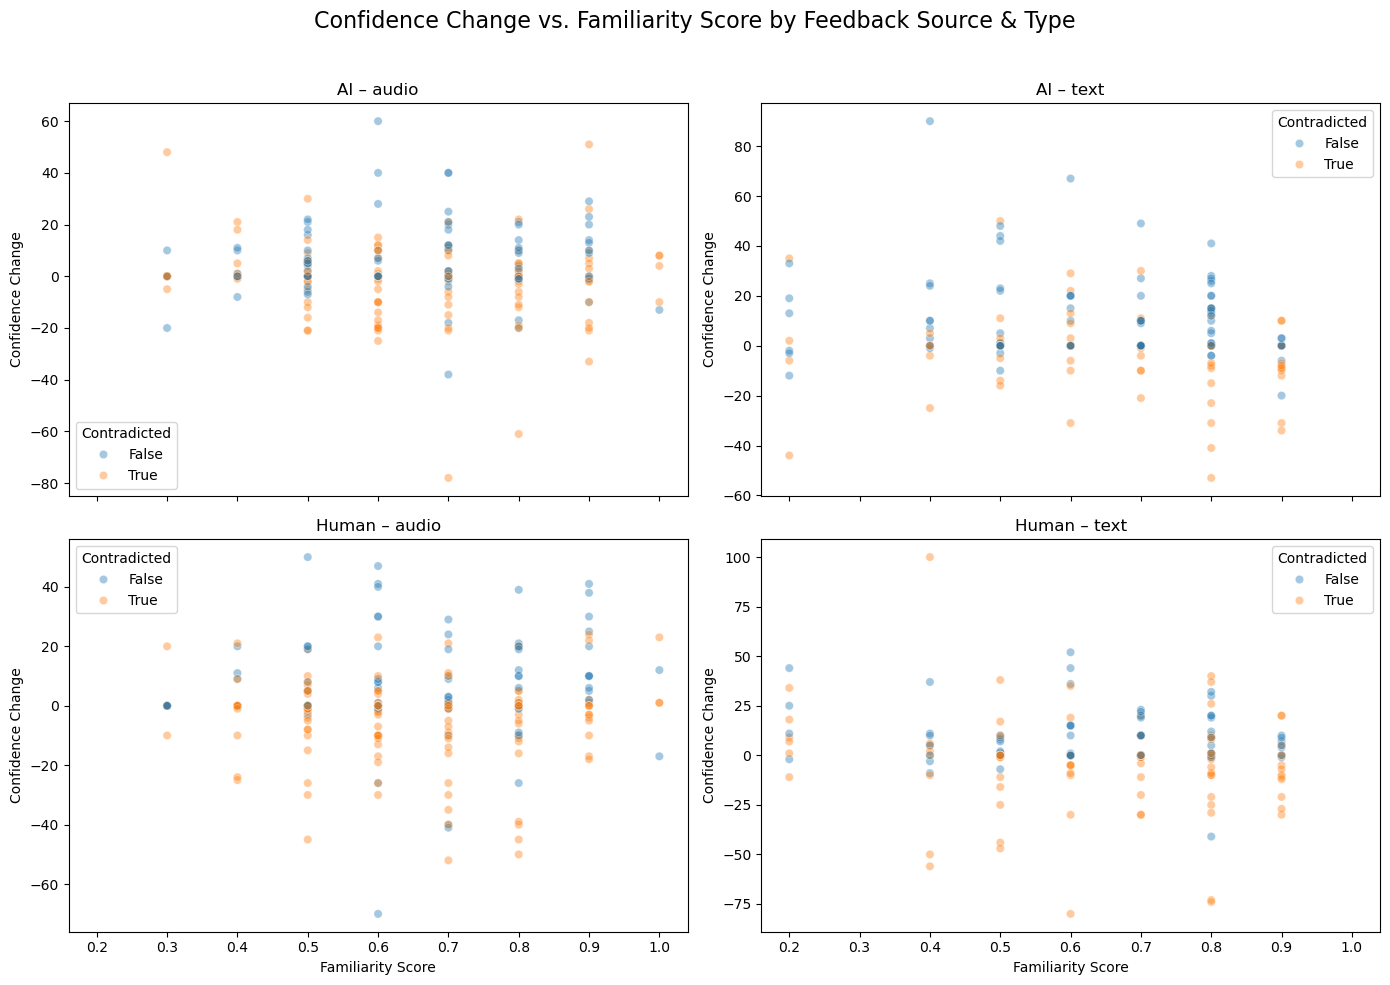

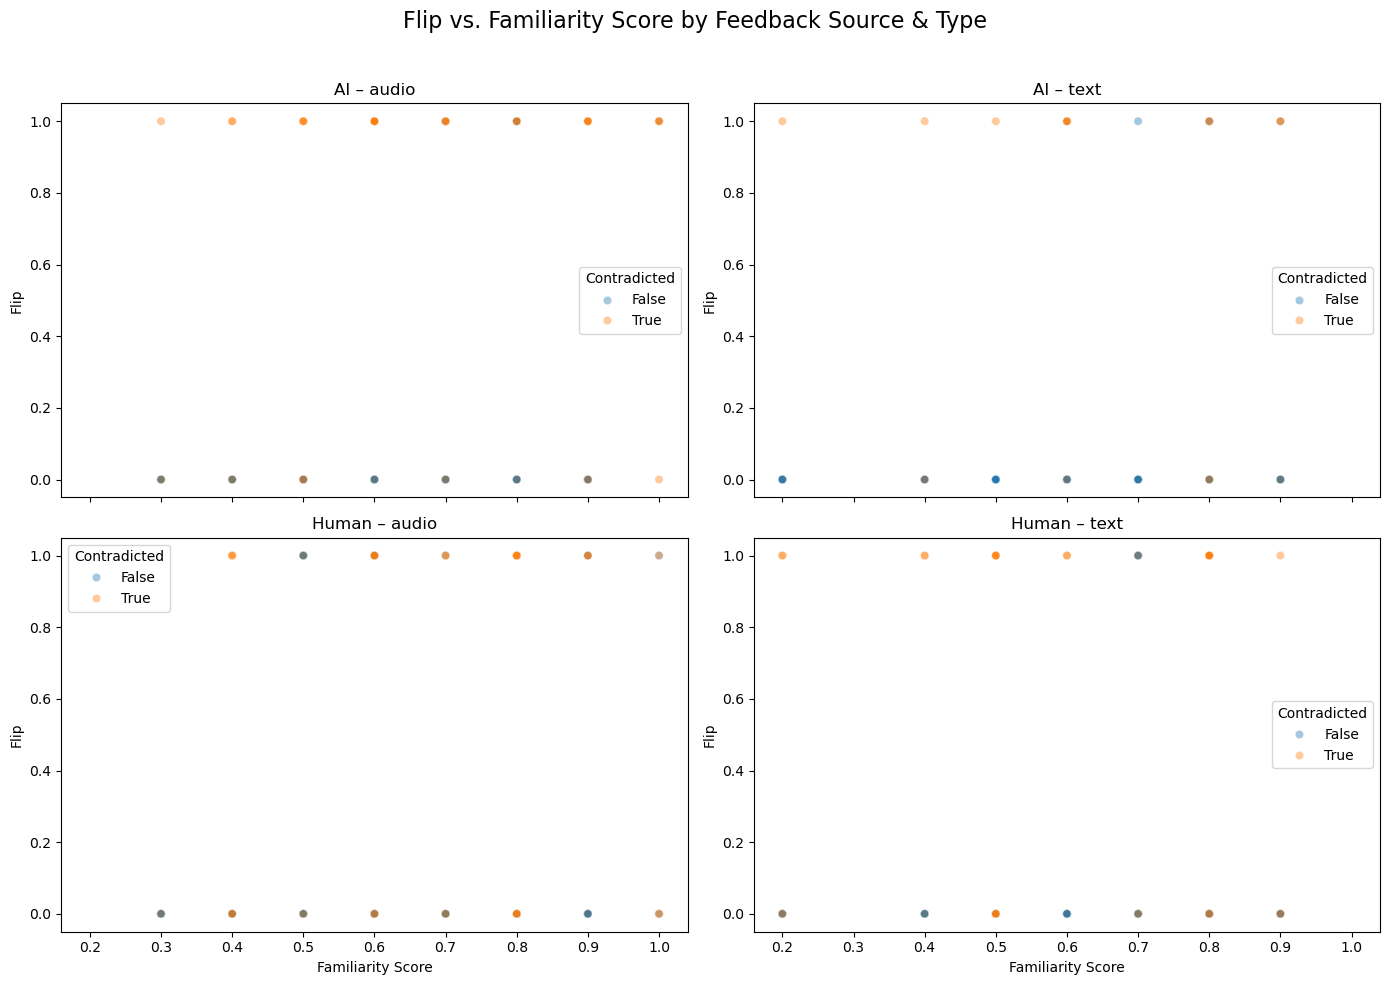

In [948]:
import seaborn as sns
import matplotlib.pyplot as plt

# Define your parameters
outcomes = ['confidence_change', 'flip']  # Could add 'reaction_time', etc.
sources = ['AI', 'Human']
types = ['audio', 'text']

# Generate plots
for outcome in outcomes:
    fig, axes = plt.subplots(2, 2, figsize=(14, 10), sharex=True, sharey=False)
    fig.suptitle(f"{outcome.replace('_', ' ').title()} vs. Familiarity Score by Feedback Source & Type", fontsize=16)

    for i, source in enumerate(sources):
        for j, fb_type in enumerate(types):
            subset = new_df[
                (new_df['feedback_source'] == source) &
                (new_df['feedback_type'] == fb_type)
            ]

            sns.scatterplot(
                data=subset,
                x='familiarity_score',
                y=outcome,
                hue='feedback_contradicts',
                alpha=0.4,
                ax=axes[i, j]
            )
            axes[i, j].set_title(f"{source} – {fb_type}")
            axes[i, j].set_xlabel("Familiarity Score")
            axes[i, j].set_ylabel(outcome.replace('_', ' ').title())
            axes[i, j].legend(title="Contradicted")

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()


## Supp Hyp : Accuracy change

In [949]:
df2 = new_df.copy()

# Whether initial and later guess are correct
df2['initial_correct'] = df2['initial_guess'] == df2['ground_truth']
df2['later_correct'] = df2['later_guess'] == df2['ground_truth']

# Change in confidence and accuracy
df2['confidence_change'] = df2['later_confidence'] - df2['initial_confidence']
df2['accuracy_change'] = df2['later_correct'].astype(int) - df2['initial_correct'].astype(int)

df2["participant_id"].iloc[0]

# Aggregate per participant per condition (AI vs Human)
agg = df2.groupby(['participant_id', 'feedback_type', 'hum_AI']).agg({
    'confidence_change': 'mean',
    'accuracy_change': 'mean'
}).reset_index()

audio_group = agg[agg['feedback_type'] == 'audio']
text_group = agg[agg['feedback_type'] == 'text']

# same for accuracy_change
# Paired t-tests within audio group
audio_ai = audio_group[audio_group['hum_AI'] == 'NH'].set_index('participant_id')
audio_human = audio_group[audio_group['hum_AI'] == 'H'].set_index('participant_id')
# Match on participant_id
common_ids = audio_ai.index.intersection(audio_human.index)
t_stat, p_val = stats.ttest_rel(audio_ai.loc[common_ids, 'accuracy_change'],
                                 audio_human.loc[common_ids, 'accuracy_change'])
print("Audio group: AI vs Human accuracy change t-test, t_stat:", t_stat,", p_val :", p_val)
# same for text group
text_ai = text_group[text_group['hum_AI'] == 'NH'].set_index('participant_id')
text_human = text_group[text_group['hum_AI'] == 'H'].set_index('participant_id')
# Match on participant_id
common_ids = text_ai.index.intersection(text_human.index)
t_stat, p_val = stats.ttest_rel(text_ai.loc[common_ids, 'accuracy_change'],
                                 text_human.loc[common_ids, 'accuracy_change'])
print("Text group: AI vs Human accuracy change t-test, t_stat:", t_stat,", p_val :", p_val)

Audio group: AI vs Human accuracy change t-test, t_stat: 4.8463415013908975 , p_val : 1.75052748933272e-05
Text group: AI vs Human accuracy change t-test, t_stat: 2.3283852971260557 , p_val : 0.025974550411573497


In [950]:
def paired_analysis(df_group, label):
    # Split by feedback type
    ai = df_group[df_group['hum_AI'] == 'NH'].set_index('participant_id')
    human = df_group[df_group['hum_AI'] == 'H'].set_index('participant_id')

    # Find common participants
    common = ai.index.intersection(human.index)

    # Extract accuracy change
    ai_acc = ai.loc[common, 'accuracy_change']
    human_acc = human.loc[common, 'accuracy_change']

    # Paired t-test
    t_stat, p_val = stats.ttest_rel(ai_acc, human_acc)
    print(f"{label} — t = {t_stat:.3f}, p = {p_val:.6f}")

    # Cohen’s d for paired samples
    def cohens_d_paired(x, y):
        diff = x - y
        return diff.mean() / diff.std(ddof=1)

    d = cohens_d_paired(ai_acc, human_acc)
    print(f"{label} — Cohen's d = {d:.3f}")

    # Descriptive stats
    print(f"AI — Mean: {ai_acc.mean():.3f}, SD: {ai_acc.std():.3f}")
    print(f"Human — Mean: {human_acc.mean():.3f}, SD: {human_acc.std():.3f}")
    print("––––––––––––––––––––––––––––––––––––")

# Run for both modalities
paired_analysis(audio_group, "Audio")
paired_analysis(text_group, "Text")


Audio — t = 4.846, p = 0.000018
Audio — Cohen's d = 0.739
AI — Mean: 0.098, SD: 0.197
Human — Mean: -0.093, SD: 0.182
––––––––––––––––––––––––––––––––––––
Text — t = 2.328, p = 0.025975
Text — Cohen's d = 0.394
AI — Mean: 0.046, SD: 0.138
Human — Mean: -0.063, SD: 0.173
––––––––––––––––––––––––––––––––––––


In [951]:
for cond in [('audio', 'NH'), ('audio', 'H'), ('text', 'NH'), ('text', 'H')]:
    subset = agg[(agg['feedback_type'] == cond[0]) & (agg['hum_AI'] == cond[1])]
    r = subset[['confidence_change', 'accuracy_change']].corr().iloc[0, 1]
    label = f"{cond[0].capitalize()} - {'AI' if cond[1] == 'NH' else 'Human'}"
    print(f"{label}: r = {r:.3f}")


Audio - AI: r = -0.133
Audio - Human: r = 0.104
Text - AI: r = 0.401
Text - Human: r = -0.035


hum_AI
H     0.2
NH    1.0
Name: feedback_correct, dtype: float64
hum_AI  feedback_type
H       audio            0.2
        text             0.2
NH      audio            1.0
        text             1.0
Name: feedback_correct, dtype: float64


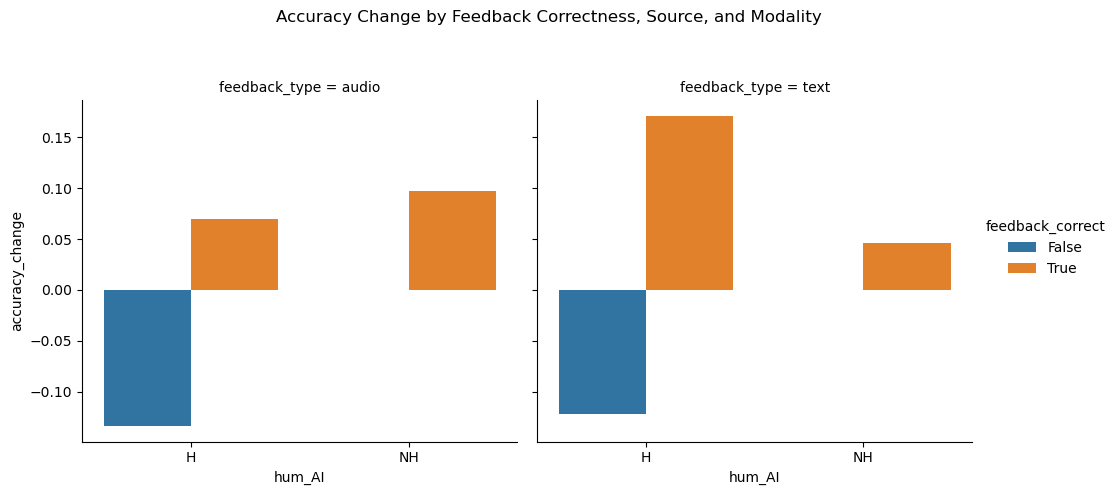

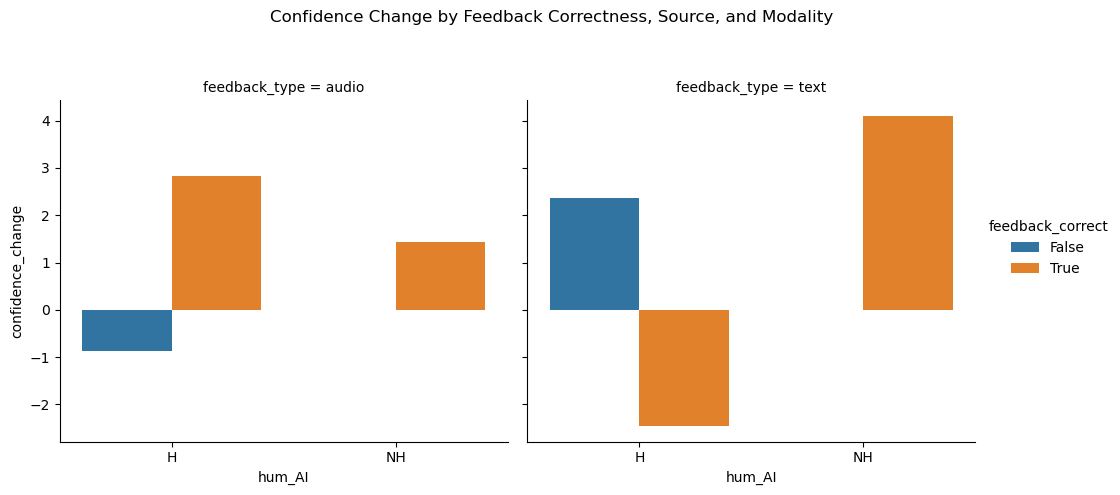

In [952]:
df2['feedback_correct'] = df2['feedback_content'] == df2['ground_truth']
# Overall rate by source
print(df2.groupby('hum_AI')['feedback_correct'].mean())

# Split by modality too
print(df2.groupby(['hum_AI', 'feedback_type'])['feedback_correct'].mean())

feedback_effect = df2.groupby(['feedback_correct', 'hum_AI', 'feedback_type'])[
    ['accuracy_change', 'confidence_change']
].mean().reset_index()

import seaborn as sns
import matplotlib.pyplot as plt

sns.catplot(
    data=feedback_effect,
    x='hum_AI', y='accuracy_change', hue='feedback_correct',
    col='feedback_type', kind='bar'
)
plt.subplots_adjust(top=0.8)
plt.suptitle("Accuracy Change by Feedback Correctness, Source, and Modality")
plt.show()

sns.catplot(
    data=feedback_effect,
    x='hum_AI', y='confidence_change', hue='feedback_correct',
    col='feedback_type', kind='bar'
)
plt.subplots_adjust(top=0.8)
plt.suptitle("Confidence Change by Feedback Correctness, Source, and Modality")
plt.show()


In [953]:
from scipy.stats import ttest_ind

# Example: Accuracy change for AI feedback, correct vs incorrect
ai_df = df2[df2['hum_AI'] == 'NH']

correct = ai_df[ai_df['feedback_correct']]['accuracy_change']
incorrect = ai_df[~ai_df['feedback_correct']]['accuracy_change']


print("Correct feedback count:", len(correct))
print("Incorrect feedback count:", len(incorrect))


t_stat, p_val = ttest_ind(correct, incorrect, equal_var=False)
print(f"AI Feedback — Accuracy Change: t = {t_stat:.3f}, p = {p_val:.3f}")


Correct feedback count: 390
Incorrect feedback count: 0
AI Feedback — Accuracy Change: t = nan, p = nan


c:\Users\liogr\anaconda3\envs\shs-psycho\Lib\site-packages\scipy\_lib\deprecation.py:234: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  return f(*args, **kwargs)


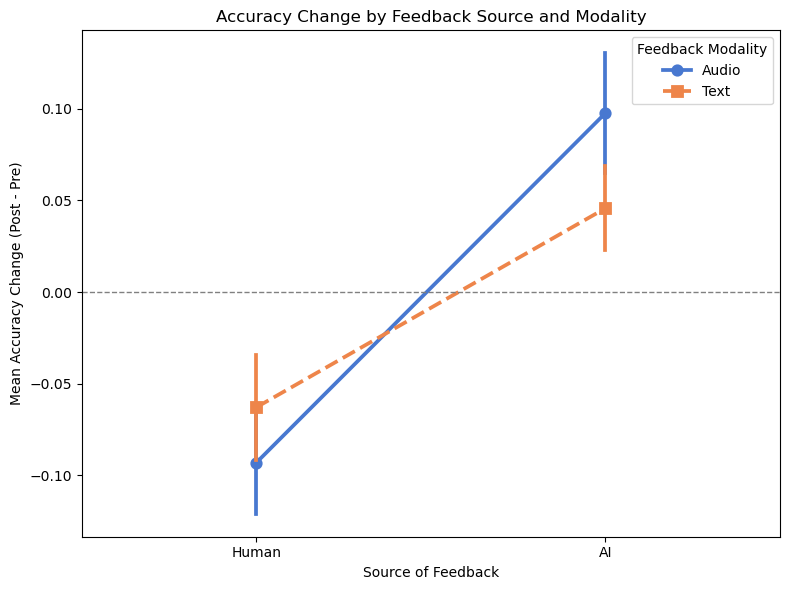

In [954]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Create a clearer label for hum_AI
agg['Feedback Source'] = agg['hum_AI'].map({'H': 'Human', 'NH': 'AI'})
agg['Modality'] = agg['feedback_type'].str.capitalize()

# Plot
plt.figure(figsize=(8, 6))
sns.pointplot(
    data=agg,
    x='Feedback Source',
    y='accuracy_change',
    hue='Modality',
    errorbar=('ci', 68),
    markers=['o', 's'],
    linestyles=['-', '--'],
    palette='muted'
)

# Improve visual
plt.axhline(0, color='gray', linestyle='--', linewidth=1)
plt.title("Accuracy Change by Feedback Source and Modality")
plt.ylabel("Mean Accuracy Change (Post - Pre)")
plt.xlabel("Source of Feedback")
plt.legend(title="Feedback Modality")
plt.tight_layout()
plt.show()


Mean accuracy change (correct feedback): 0.0811965811965812
Mean accuracy change (incorrect feedback): -0.1282051282051282


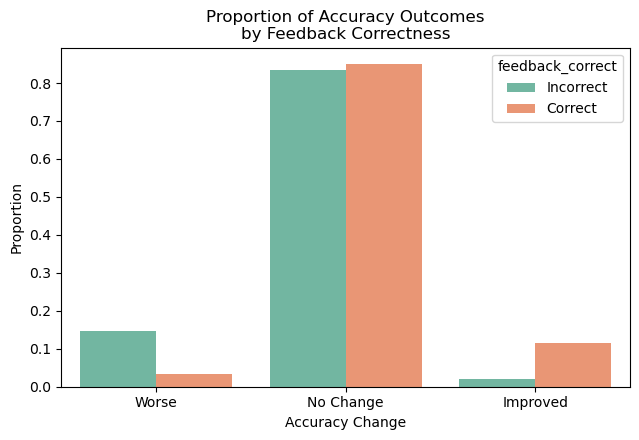

In [955]:
correct = df2[df2['feedback_correct']]['accuracy_change']
incorrect = df2[~df2['feedback_correct']]['accuracy_change']

print("Mean accuracy change (correct feedback):", correct.mean())
print("Mean accuracy change (incorrect feedback):", incorrect.mean())

import seaborn as sns
import matplotlib.pyplot as plt

# Create a proportion table
acc_prop = (
    df2
    .groupby(['feedback_correct', 'accuracy_change'])
    .size()
    .reset_index(name='count')
)

# Convert accuracy_change to string for better x-axis labels
acc_prop['accuracy_change'] = acc_prop['accuracy_change'].map({-1: 'Worse', 0: 'No Change', 1: 'Improved'})
acc_prop['feedback_correct'] = acc_prop['feedback_correct'].map({True: 'Correct', False: 'Incorrect'})

# Normalize counts to get proportions
acc_prop['prop'] = acc_prop.groupby('feedback_correct')['count'].transform(lambda x: x / x.sum())

# Plot
plt.figure(figsize=(6.5, 4.5))
sns.barplot(
    data=acc_prop,
    x='accuracy_change',
    y='prop',
    hue='feedback_correct',
    palette='Set2'
)
plt.title("Proportion of Accuracy Outcomes\nby Feedback Correctness")
plt.ylabel("Proportion")
plt.xlabel("Accuracy Change")
plt.tight_layout()
plt.show()



In [956]:
from scipy.stats import ttest_ind

t_stat, p_val = ttest_ind(correct, incorrect, equal_var=False)
print(f"t = {t_stat:.3f}, p = {p_val:.3f}")


t = 7.454, p = 0.000


---
# Exploratory analysis

## Demographical Impact

In [957]:
summary_df = new_df.groupby("participant_id").agg({
    "feedback_change": "mean",                  # Taux moyen de flip
    "confidence_change": "mean",                # Changement moyen de confiance
    "technical_score": "first",                 # Score technique (identique pour chaque ligne)
    "familiarity_score": "first",               # Score de familiarité
    "age_label": "first",
    "gender_label": "first",
    "education_label": "first",
    "origin_cleaned": "first",
    "education_theme_x": "first"
}).reset_index()

# Renommer pour clarté
summary_df.rename(columns={
    "feedback_change": "flip_rate",
    "confidence_change": "avg_conf_change",
    "education_theme_x": "education_theme"
}, inplace=True)

# Aperçu
summary_df.head()

,participant_id,flip_rate,avg_conf_change,technical_score,familiarity_score,age_label,gender_label,education_label,origin_cleaned,education_theme
0,R_1Ra6z3SyuebyqsE,0.3,2.4,0.783333,0.7,18–25,Femme,Bachelor,France,Neurosciences / Biologie
1,R_1eW39XhMxtmNOvv,0.2,-3.8,0.350000,0.5,18–25,Femme,Apprentissage / HES,Suisse,Psychologie
2,R_1egeBUaB0oERkjz,0.3,7.7,0.483333,0.9,18–25,Femme,Apprentissage / HES,France,Santé / Médecine
3,R_1n91AdhujHNQUZF,0.3,3.5,0.250000,0.7,18–25,Femme,Apprentissage / HES,Suisse,Sport / Intervention
4,R_21GwgasGE5hbaoY,0.0,-1.0,0.716667,0.8,18–25,Femme,Bachelor,France,Ingénierie


In [958]:
model = smf.ols("flip_rate ~ C(gender_label) + C(age_label) + C(education_label)", data=summary_df).fit()
print(model.summary())
model = smf.ols("avg_conf_change ~ C(gender_label) + C(age_label) + C(education_label)", data=summary_df).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:              flip_rate   R-squared:                       0.084
Model:                            OLS   Adj. R-squared:                 -0.037
Method:                 Least Squares   F-statistic:                    0.6921
Date:                Sun, 01 Jun 2025   Prob (F-statistic):              0.714
Time:                        12:54:35   Log-Likelihood:                 41.236
No. Observations:                  78   AIC:                            -62.47
Df Residuals:                      68   BIC:                            -38.90
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                                             coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------

In [959]:
print(summary_df[["technical_score", "familiarity_score", "flip_rate", "avg_conf_change"]].corr())


                   technical_score  familiarity_score  flip_rate  \
technical_score           1.000000           0.356245  -0.122624   
familiarity_score         0.356245           1.000000   0.150982   
flip_rate                -0.122624           0.150982   1.000000   
avg_conf_change          -0.160828          -0.175963   0.176784   

                   avg_conf_change  
technical_score          -0.160828  
familiarity_score        -0.175963  
flip_rate                 0.176784  
avg_conf_change           1.000000  


### Gender

In [960]:
group_male = summary_df[summary_df["gender_label"] == "Homme"]["flip_rate"]
group_female = summary_df[summary_df["gender_label"] == "Femme"]["flip_rate"]
stat, p = stats.mannwhitneyu(group_male, group_female)
print("Mann-Whitney U test:", p)

group_male = summary_df[summary_df["gender_label"] == "Homme"]["avg_conf_change"]
group_female = summary_df[summary_df["gender_label"] == "Femme"]["avg_conf_change"]

stat, p = stats.mannwhitneyu(group_male, group_female)
print(f"Mann-Whitney U (Genre – Confidence change): p = {p:.3f}")


Mann-Whitney U test: 0.9872717053782526
Mann-Whitney U (Genre – Confidence change): p = 1.000


### Age

In [961]:
age_groups = [group["flip_rate"] for name, group in summary_df.groupby("age_label")]
stat, p = stats.kruskal(*age_groups)
print(f"Kruskal-Wallis (Âge – Flip rate): p = {p:.3f}")

age_groups = [group["avg_conf_change"] for name, group in summary_df.groupby("age_label")]
stat, p = stats.kruskal(*age_groups)
print(f"Kruskal-Wallis (Âge – Confidence change): p = {p:.3f}")


Kruskal-Wallis (Âge – Flip rate): p = 0.632
Kruskal-Wallis (Âge – Confidence change): p = 0.389


### Education Level

In [962]:
edu_groups = [group["flip_rate"] for name, group in summary_df.groupby("education_label")]
stat, p = stats.kruskal(*edu_groups)
print(f"Kruskal-Wallis (Éducation – Flip rate): p = {p:.3f}")

edu_groups = [group["avg_conf_change"] for name, group in summary_df.groupby("education_label")]
stat, p = stats.kruskal(*edu_groups)
print(f"Kruskal-Wallis (Éducation – Confidence change): p = {p:.3f}")


Kruskal-Wallis (Éducation – Flip rate): p = 0.720
Kruskal-Wallis (Éducation – Confidence change): p = 0.332


### Origin 

In [963]:
country_counts = summary_df["origin_cleaned"].value_counts()
top_countries = country_counts[country_counts >= 5].index  # min 5 participants
country_groups = [summary_df[summary_df["origin_cleaned"] == c]["flip_rate"] for c in top_countries]

if len(country_groups) >= 2:
    stat, p = stats.kruskal(*country_groups)
    print(f"Kruskal-Wallis (Origine – Flip rate): p = {p:.3f}")
else:
    print("Pas assez de pays avec ≥5 participants pour Kruskal-Wallis.")

country_counts = summary_df["origin_cleaned"].value_counts()
top_countries = country_counts[country_counts >= 5].index
country_groups = [summary_df[summary_df["origin_cleaned"] == c]["avg_conf_change"] for c in top_countries]

if len(country_groups) >= 2:
    stat, p = stats.kruskal(*country_groups)
    print(f"Kruskal-Wallis (Origine – Confidence change): p = {p:.3f}")
else:
    print("Pas assez de pays avec ≥5 participants pour Kruskal-Wallis.")



Kruskal-Wallis (Origine – Flip rate): p = 0.566
Kruskal-Wallis (Origine – Confidence change): p = 0.867


In [964]:
from statsmodels.stats.multitest import multipletests

# Collect all your p-values from demographic tests (e.g., 8 in total)
p_values = [
    0.987,  # Gender – flip rate
    1.000,  # Gender – confidence change
    0.632,  # Age – flip rate
    0.389,  # Age – confidence change
    0.720,  # Education – flip rate
    0.332,  # Education – confidence change
    0.566,  # Nationality – flip rate
    0.867   # Nationality – confidence change
]

# Apply correction (choose method: 'bonferroni', 'fdr_bh', etc.)
reject, pvals_corrected, _, _ = multipletests(p_values, method='bonferroni')

# Print corrected p-values and which ones remain significant
for i, (raw, corrected, is_sig) in enumerate(zip(p_values, pvals_corrected, reject)):
    print(f"Test {i+1}: raw p = {raw:.3f}, corrected p = {corrected:.3f}, significant: {is_sig}")


Test 1: raw p = 0.987, corrected p = 1.000, significant: False
Test 2: raw p = 1.000, corrected p = 1.000, significant: False
Test 3: raw p = 0.632, corrected p = 1.000, significant: False
Test 4: raw p = 0.389, corrected p = 1.000, significant: False
Test 5: raw p = 0.720, corrected p = 1.000, significant: False
Test 6: raw p = 0.332, corrected p = 1.000, significant: False
Test 7: raw p = 0.566, corrected p = 1.000, significant: False
Test 8: raw p = 0.867, corrected p = 1.000, significant: False


In [965]:
from statsmodels.stats.multitest import multipletests
# Calculer le pourcentage de feedbacks qui contredisent la réponse initiale
contradict_df = new_df.groupby("participant_id")["feedback_contradicts"].mean().reset_index()
contradict_df.rename(columns={"feedback_contradicts": "contradict_rate"}, inplace=True)

# Fusionner avec le résumé global
summary_df3 = summary_df.merge(contradict_df, on="participant_id", how="left")

# Modèle pour flip_rate
model = smf.ols("flip_rate ~ C(age_label) + C(gender_label) + C(education_label)", data=summary_df3).fit()
print(model.summary())

# Correction FDR pour les p-values du modèle 1 (flip_rate)
pvals1 = model.pvalues.drop("Intercept")
reject1, pvals_corr1, _, _ = multipletests(pvals1, method='fdr_bh')

# Afficher les variables significatives après correction FDR
print("\nVariables significatives pour flip_rate après correction FDR:")
for var, pval_corr, rej in zip(pvals1.index, pvals_corr1, reject1):
    if rej:
        print(f"- {var}: p (corr) = {pval_corr:.4f}")

# Modèle pour avg_conf_change
model_conf = smf.ols("avg_conf_change ~ C(age_label) + C(gender_label) + C(education_label)", data=summary_df3).fit()
print(model_conf.summary())

# Correction FDR pour les p-values du modèle 1 (flip_rate)
pvals2 = model_conf.pvalues.drop("Intercept")
reject2, pvals_corr2, _, _ = multipletests(pvals2, method='fdr_bh')

# Afficher les variables significatives après correction FDR
print("\nVariables significatives pour confidence change après correction FDR:")
for var, pval_corr, rej in zip(pvals2.index, pvals_corr2, reject2):
    if rej:
        print(f"- {var}: p (corr) = {pval_corr:.4f}")

                            OLS Regression Results                            
Dep. Variable:              flip_rate   R-squared:                       0.084
Model:                            OLS   Adj. R-squared:                 -0.037
Method:                 Least Squares   F-statistic:                    0.6921
Date:                Sun, 01 Jun 2025   Prob (F-statistic):              0.714
Time:                        12:54:36   Log-Likelihood:                 41.236
No. Observations:                  78   AIC:                            -62.47
Df Residuals:                      68   BIC:                            -38.90
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                                             coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------

In [966]:
from statsmodels.formula.api import mixedlm
from statsmodels.stats.multitest import multipletests

def run_mixed_model(formula, data, label):
    print(f"\n📊 {label}")
    model = mixedlm(formula, data=data.copy(), groups=data["participant_id"])
    result = model.fit()
    print(result.summary())

    # Extract fixed effects only (exclude Group Var and Intercept)
    fixed_effects = [name for name in result.pvalues.index if name not in ["Group Var", "Intercept"]]
    pvals = result.pvalues[fixed_effects]

    # FDR correction only makes sense with 2+ tests
    if len(pvals) >= 2:
        reject, pvals_corr, _, _ = multipletests(pvals, method='fdr_bh')
        print("\n📌 Significant fixed effects after FDR correction (q < .05):")
        any_significant = False
        for name, passed, pval_corr in zip(pvals.index, reject, pvals_corr):
            if passed:
                print(f"✅ {name}: corrected p = {pval_corr:.4f}")
                any_significant = True
        if not any_significant:
            print("No fixed effects remain significant after correction.")
    elif len(pvals) == 1:
        # Only one fixed effect, print uncorrected p
        name = pvals.index[0]
        pval = pvals.iloc[0]
        if pval < 0.05:
            print(f"\n📌 Significant fixed effect (uncorrected p < .05): ✅ {name}: p = {pval:.4f}")
        else:
            print(f"\n📌 No significant fixed effect (p = {pval:.4f})")
    else:
        print("\n⚠️ No fixed effects found (after excluding Intercept and Group Var).")


# --- Create a clean copy ---
df_analysis = new_df.copy()

# Optional: convert confidence change if needed
df_analysis["confidence_change"] = df_analysis["later_confidence"] - df_analysis["initial_confidence"]
df_analysis["feedback_change"] = df_analysis["feedback_influence"]

# --- First block: Demographics × Feedback source ---

run_mixed_model(
    "feedback_change ~ C(gender_label) * C(hum_AI)",
    df_analysis,
    "Flip rate ~ Gender × Feedback Source"
)

run_mixed_model(
    "confidence_change ~ C(gender_label) * C(hum_AI)",
    df_analysis,
    "Confidence change ~ Gender × Feedback Source"
)

run_mixed_model(
    "feedback_change ~ C(age_label) * C(hum_AI)",
    df_analysis,
    "Flip rate ~ Age × Feedback Source"
)

run_mixed_model(
    "confidence_change ~ C(age_label) * C(hum_AI)",
    df_analysis,
    "Confidence change ~ Age × Feedback Source"
)

run_mixed_model(
    "feedback_change ~ C(education_label) * C(hum_AI)",
    df_analysis,
    "Flip rate ~ Education × Feedback Source"
)

run_mixed_model(
    "confidence_change ~ C(education_label) * C(hum_AI)",
    df_analysis,
    "Confidence change ~ Education × Feedback Source"
)

# --- Second block: Add Technical & Familiarity scores ---

run_mixed_model(
    "feedback_change ~ C(gender_label) * C(hum_AI) + technical_score + familiarity_score",
    df_analysis,
    "Flip rate (Gender × Source + Tech/Fam)"
)

run_mixed_model(
    "confidence_change ~ C(gender_label) * C(hum_AI) + technical_score + familiarity_score",
    df_analysis,
    "Confidence change (Gender × Source + Tech/Fam)"
)

run_mixed_model(
    "feedback_change ~ C(age_label) * C(hum_AI) + technical_score + familiarity_score",
    df_analysis,
    "Flip rate (Age × Source + Tech/Fam)"
)

run_mixed_model(
    "confidence_change ~ C(age_label) * C(hum_AI) + technical_score + familiarity_score",
    df_analysis,
    "Confidence change (Age × Source + Tech/Fam)"
)

run_mixed_model(
    "feedback_change ~ C(education_label) * C(hum_AI) + technical_score + familiarity_score",
    df_analysis,
    "Flip rate (Edu × Source + Tech/Fam)"
)

run_mixed_model(
    "confidence_change ~ C(education_label) * C(hum_AI) + technical_score + familiarity_score",
    df_analysis,
    "Confidence change (Edu × Source + Tech/Fam)"
)



📊 Flip rate ~ Gender × Feedback Source
                       Mixed Linear Model Regression Results
Model:                    MixedLM        Dependent Variable:        feedback_change
No. Observations:         780            Method:                    REML           
No. Groups:               78             Scale:                     0.1739         
Min. group size:          10             Log-Likelihood:            -475.0243      
Max. group size:          10             Converged:                 Yes            
Mean group size:          10.0                                                     
-----------------------------------------------------------------------------------
                                         Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-----------------------------------------------------------------------------------
Intercept                                 1.669    0.038 44.131 0.000  1.595  1.744
C(gender_label)[T.Homme]                 -0.076    0.062 -1

c:\Users\liogr\anaconda3\envs\shs-psycho\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\liogr\anaconda3\envs\shs-psycho\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
c:\Users\liogr\anaconda3\envs\shs-psycho\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\liogr\anaconda3\envs\shs-psycho\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with cg
  warnings.warn(
c:\Users\liogr\anaconda3\envs\shs-psycho\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization fai

                         Mixed Linear Model Regression Results
Model:                     MixedLM         Dependent Variable:         confidence_change
No. Observations:          780             Method:                     REML             
No. Groups:                78              Scale:                      277.7108         
Min. group size:           10              Log-Likelihood:             -3319.6820       
Max. group size:           10              Converged:                  No               
Mean group size:           10.0                                                         
----------------------------------------------------------------------------------------
                                             Coef.  Std.Err.   z    P>|z|  [0.025 0.975]
----------------------------------------------------------------------------------------
Intercept                                     0.369    1.512  0.244 0.807  -2.593  3.332
C(age_label)[T.25–40]                        -1

c:\Users\liogr\anaconda3\envs\shs-psycho\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\liogr\anaconda3\envs\shs-psycho\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
c:\Users\liogr\anaconda3\envs\shs-psycho\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\liogr\anaconda3\envs\shs-psycho\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with cg
  warnings.warn(
c:\Users\liogr\anaconda3\envs\shs-psycho\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization fai

                              Mixed Linear Model Regression Results
Model:                         MixedLM            Dependent Variable:            confidence_change
No. Observations:              780                Method:                        REML             
No. Groups:                    78                 Scale:                         279.0457         
Min. group size:               10                 Log-Likelihood:                -3313.9742       
Max. group size:               10                 Converged:                     No               
Mean group size:               10.0                                                               
--------------------------------------------------------------------------------------------------
                                                       Coef.  Std.Err.   z    P>|z|  [0.025 0.975]
--------------------------------------------------------------------------------------------------
Intercept                                

c:\Users\liogr\anaconda3\envs\shs-psycho\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\liogr\anaconda3\envs\shs-psycho\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
c:\Users\liogr\anaconda3\envs\shs-psycho\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\liogr\anaconda3\envs\shs-psycho\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with cg
  warnings.warn(
c:\Users\liogr\anaconda3\envs\shs-psycho\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization fai

                       Mixed Linear Model Regression Results
Model:                   MixedLM        Dependent Variable:        confidence_change
No. Observations:        780            Method:                    REML             
No. Groups:              78             Scale:                     277.7340         
Min. group size:         10             Log-Likelihood:            -3335.0690       
Max. group size:         10             Converged:                 No               
Mean group size:         10.0                                                       
------------------------------------------------------------------------------------
                                         Coef.  Std.Err.   z    P>|z|  [0.025 0.975]
------------------------------------------------------------------------------------
Intercept                                 6.416    4.691  1.368 0.171  -2.777 15.610
C(gender_label)[T.Homme]                  2.394    2.770  0.865 0.387  -3.034  7.823
C(hu

c:\Users\liogr\anaconda3\envs\shs-psycho\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\liogr\anaconda3\envs\shs-psycho\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
c:\Users\liogr\anaconda3\envs\shs-psycho\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\liogr\anaconda3\envs\shs-psycho\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with cg
  warnings.warn(
c:\Users\liogr\anaconda3\envs\shs-psycho\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization fai

                         Mixed Linear Model Regression Results
Model:                     MixedLM         Dependent Variable:         confidence_change
No. Observations:          780             Method:                     REML             
No. Groups:                78              Scale:                      280.2347         
Min. group size:           10              Log-Likelihood:             -3311.9346       
Max. group size:           10              Converged:                  No               
Mean group size:           10.0                                                         
----------------------------------------------------------------------------------------
                                             Coef.  Std.Err.   z    P>|z|  [0.025 0.975]
----------------------------------------------------------------------------------------
Intercept                                     3.673    5.052  0.727 0.467  -6.229 13.575
C(age_label)[T.25–40]                        -1

c:\Users\liogr\anaconda3\envs\shs-psycho\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\liogr\anaconda3\envs\shs-psycho\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
c:\Users\liogr\anaconda3\envs\shs-psycho\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\liogr\anaconda3\envs\shs-psycho\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with cg
  warnings.warn(


                              Mixed Linear Model Regression Results
Model:                         MixedLM            Dependent Variable:            confidence_change
No. Observations:              780                Method:                        REML             
No. Groups:                    78                 Scale:                         281.1676         
Min. group size:               10                 Log-Likelihood:                -3306.1257       
Max. group size:               10                 Converged:                     No               
Mean group size:               10.0                                                               
--------------------------------------------------------------------------------------------------
                                                       Coef.  Std.Err.   z    P>|z|  [0.025 0.975]
--------------------------------------------------------------------------------------------------
Intercept                                

c:\Users\liogr\anaconda3\envs\shs-psycho\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\liogr\anaconda3\envs\shs-psycho\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2206: ConvergenceWarning: MixedLM optimization failed, trying a different optimizer may help.
  warnings.warn(msg, ConvergenceWarning)
c:\Users\liogr\anaconda3\envs\shs-psycho\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2218: ConvergenceWarning: Gradient optimization failed, |grad| = 36.561408
  warnings.warn(msg, ConvergenceWarning)


In [967]:
import pandas as pd
from scipy.stats import ttest_ind
import statsmodels.formula.api as smf
from statsmodels.stats.multitest import multipletests

# Start from your trial-level dataframe
df = new_df.copy()

# Create feedback change and confidence change if not already there
df["feedback_change"] = df["feedback_influence"]
df["confidence_change"] = df["later_confidence"] - df["initial_confidence"]

# Group by participant × contradiction × source
summary = (
    df.groupby(["participant_id", "feedback_contradicts", "hum_AI"])
    .agg(
        flip_rate=("feedback_change", "mean"),
        confidence_change=("confidence_change", "mean"),
        gender=("gender_label", "first"),
        age=("age_label", "first"),
        education=("education_label", "first"),
        tech=("technical_score", "first"),
        fam=("familiarity_score", "first")
    )
    .reset_index()
)

# Simple t-test
flip_yes = summary[summary["feedback_contradicts"] == True]["flip_rate"]
flip_no = summary[summary["feedback_contradicts"] == False]["flip_rate"]
t_stat, p_val = ttest_ind(flip_yes, flip_no, equal_var=False)
print(f"T-test: t = {t_stat:.3f}, p = {p_val:.6f}")
print(f"Means: Contradict = {flip_yes.mean():.3f}, No Contradict = {flip_no.mean():.3f}")

# --- OLS for Flip Rate ---
print("\n📊 OLS Model: Flip Rate")
model = smf.ols(
    "flip_rate ~ C(feedback_contradicts) * C(hum_AI) * (C(gender) + C(age) + C(education))",
    data=summary
).fit()
print(model.summary())

# FDR correction
pvals = model.pvalues.drop("Intercept")
if len(pvals) >= 2:
    reject, pvals_corr, _, _ = multipletests(pvals, method="fdr_bh")
    print("\n📌 Significant fixed effects for flip rate (after FDR correction):")
    sig_any = False
    for name, passed, pval_corr in zip(pvals.index, reject, pvals_corr):
        if passed:
            print(f"✅ {name}: corrected p = {pval_corr:.4f}")
            sig_any = True
    if not sig_any:
        print("None")
elif len(pvals) == 1:
    pval = pvals.iloc[0]
    if pval < 0.05:
        print(f"\n✅ Significant effect (uncorrected p = {pval:.4f})")
    else:
        print(f"\nNo significant effect (p = {pval:.4f})")

# --- OLS for Confidence Change ---
print("\n📊 OLS Model: Confidence Change")
model_conf = smf.ols(
    "confidence_change ~ C(feedback_contradicts) * C(hum_AI) * (C(gender) + C(age) + C(education))",
    data=summary
).fit()
print(model_conf.summary())

# FDR correction
pvals2 = model_conf.pvalues.drop("Intercept")
if len(pvals2) >= 2:
    reject2, pvals_corr2, _, _ = multipletests(pvals2, method="fdr_bh")
    print("\n📌 Significant fixed effects for confidence change (after FDR correction):")
    sig_any = False
    for name, passed, pval_corr in zip(pvals2.index, reject2, pvals_corr2):
        if passed:
            print(f"✅ {name}: corrected p = {pval_corr:.4f}")
            sig_any = True
    if not sig_any:
        print("None")
elif len(pvals2) == 1:
    pval = pvals2.iloc[0]
    if pval < 0.05:
        print(f"\n✅ Significant effect (uncorrected p = {pval:.4f})")
    else:
        print(f"\nNo significant effect (p = {pval:.4f})")


T-test: t = -0.084, p = 0.933039
Means: Contradict = 1.698, No Contradict = 1.701

📊 OLS Model: Flip Rate
                            OLS Regression Results                            
Dep. Variable:              flip_rate   R-squared:                       0.182
Model:                            OLS   Adj. R-squared:                  0.060
Method:                 Least Squares   F-statistic:                     1.491
Date:                Sun, 01 Jun 2025   Prob (F-statistic):             0.0372
Time:                        12:54:59   Log-Likelihood:                -81.729
No. Observations:                 302   AIC:                             243.5
Df Residuals:                     262   BIC:                             391.9
Df Model:                          39                                         
Covariance Type:            nonrobust                                         
                                                                                       coef    std err  

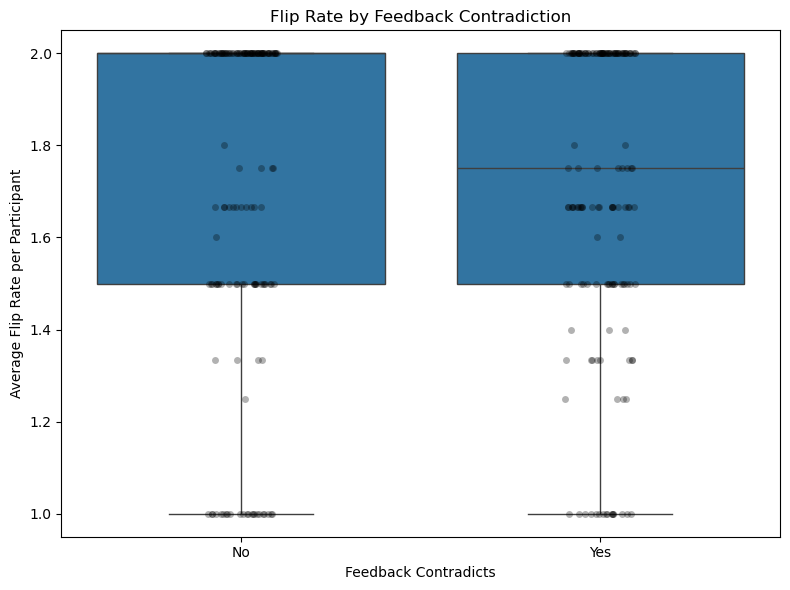

In [968]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming `summary_df` is your participant-level dataframe
# and contains: 'participant_id', 'feedback_contradicts', 'flip_rate'

plt.figure(figsize=(8, 6))
sns.boxplot(data=summary, x='feedback_contradicts', y='flip_rate')
sns.stripplot(data=summary, x='feedback_contradicts', y='flip_rate',
              color='black', alpha=0.3, jitter=True)

plt.title("Flip Rate by Feedback Contradiction")
plt.xlabel("Feedback Contradicts")
plt.ylabel("Average Flip Rate per Participant")
plt.xticks([0, 1], ['No', 'Yes'])  # Optional: better labels
plt.tight_layout()
plt.show()


## Open-ended Responses

C:\Users\liogr\AppData\Local\Temp\ipykernel_17352\2668342155.py:43: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=totals.values, y=totals.index, palette="mako")


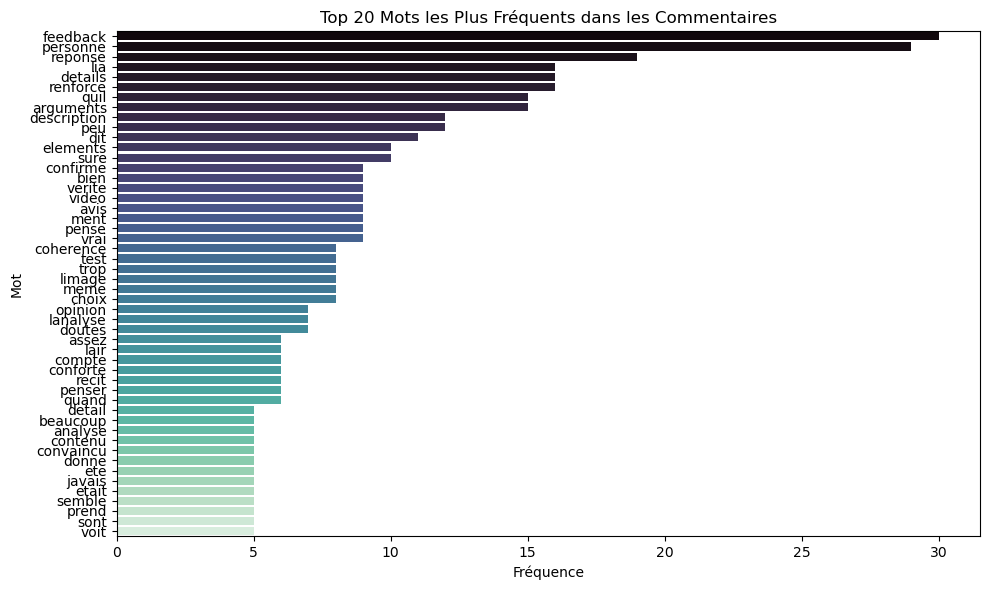

In [969]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
import unidecode
import re

# Step 1: Clean and normalize comments
comments = new_df['comments'].dropna().astype(str)

# Normalize: lowercase, remove accents, remove punctuation/digits
def clean_comment(text):
    text = unidecode.unidecode(text.lower())
    text = re.sub(r"[^\w\s]", "", text)  # remove punctuation
    text = re.sub(r"\d+", "", text)      # remove digits
    return text

comments = comments.apply(clean_comment)

# Step 2: Define an extended French stopword list (manually + built-in)
manual_stopwords = [
    'le', 'la', 'les', 'un', 'une', 'des', 'de', 'du', 'ce', 'cet', 'cette',
    'et', 'ou', 'mais', 'donc', 'or', 'ni', 'car', 'je', 'tu', 'il', 'elle',
    'nous', 'vous', 'ils', 'elles', 'on', 'que', 'qui', 'quoi', 'dans',
    'ne', 'pas', 'plus', 'moins', 'comme', 'a', 'au', 'aux', 'avec', 'par',
    'pour', 'en', 'sur', 'sous', 'entre', 'chez', 'lui', 'leur', 'leurs',
    'y', 'se', 'sa', 'son', 'ses', 'ceci', 'cela', 'cette', 'quel', 'quelle',
    'quels', 'quelles', 'mes', 'tes', 'nos', 'vos', 'est', 'mon', 'qu', 'me',
    'suis', 'ma', 'ca', 'tres', 'fait', 'etre', 'cest', 'jai', 'moi', 'peut',
    'comment', 'aussi'
]

# Step 3: Count vectorizer (keep unigrams only)
vectorizer = CountVectorizer(stop_words=manual_stopwords, max_features=50)
X = vectorizer.fit_transform(comments)

# Step 4: Aggregate word counts
word_counts = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out())
totals = word_counts.sum().sort_values(ascending=False)

# Step 5: Plot
plt.figure(figsize=(10, 6))
sns.barplot(x=totals.values, y=totals.index, palette="mako")
plt.title("Top 20 Mots les Plus Fréquents dans les Commentaires")
plt.xlabel("Fréquence")
plt.ylabel("Mot")
plt.tight_layout()
plt.show()


## Simple visuals

C:\Users\liogr\AppData\Local\Temp\ipykernel_17352\1463090935.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  counts_overall = [change_counts.get(0, 0), change_counts.get(1, 0)]
C:\Users\liogr\AppData\Local\Temp\ipykernel_17352\1463090935.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  counts_contra = [change_counts_contra.get(0, 0), change_counts_contra.get(1, 0)]


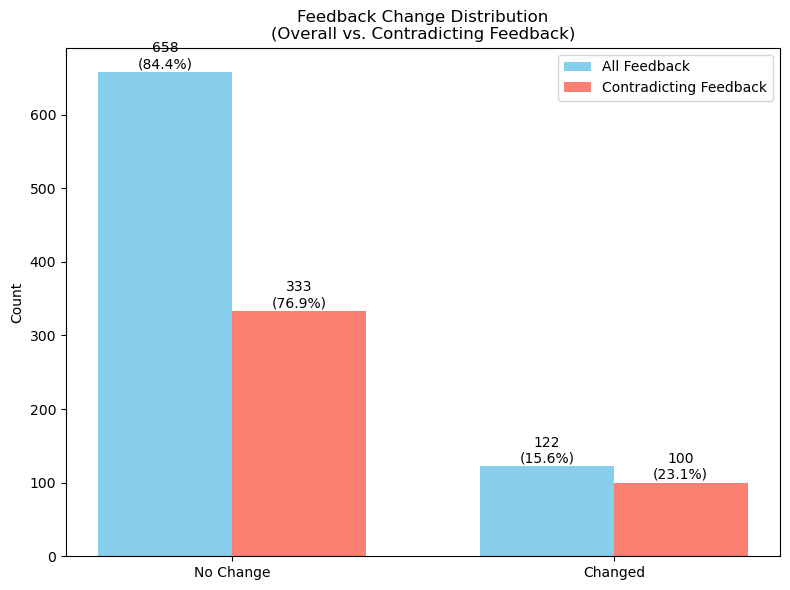

In [970]:
# --- 1. Overall feedback change counts ---
total = len(new_df)
change_counts = new_df['feedback_change'].value_counts().sort_index()
labels_overall = ['No Change', 'Changed']
counts_overall = [change_counts.get(0, 0), change_counts.get(1, 0)]
percent_overall = [f"{(c/total)*100:.1f}%" for c in counts_overall]

# --- 2. Contradiction-specific counts ---
contradiction_df = new_df[new_df['feedback_contradicts'] == True]
change_counts_contra = contradiction_df['feedback_change'].value_counts().sort_index()
labels_contra = ['No Change', 'Changed']
counts_contra = [change_counts_contra.get(0, 0), change_counts_contra.get(1, 0)]
percent_contra = [f"{(c/len(contradiction_df))*100:.1f}%" for c in counts_contra]

# --- Plotting ---
fig, ax = plt.subplots(figsize=(8, 6))

bar_width = 0.35
x = [0, 1]  # No change, Changed

# Bar 1: Overall
bars1 = ax.bar([i - bar_width/2 for i in x], counts_overall, width=bar_width, label="All Feedback", color='skyblue')

# Bar 2: Contradicting feedback only
bars2 = ax.bar([i + bar_width/2 for i in x], counts_contra, width=bar_width, label="Contradicting Feedback", color='salmon')

# Annotations for counts and percentages
for bar, pct in zip(bars1, percent_overall):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1, f"{int(bar.get_height())}\n({pct})", 
            ha='center', va='bottom', fontsize=10)

for bar, pct in zip(bars2, percent_contra):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1, f"{int(bar.get_height())}\n({pct})", 
            ha='center', va='bottom', fontsize=10)

# Final touches
ax.set_xticks(x)
ax.set_xticklabels(['No Change', 'Changed'])
ax.set_ylabel("Count")
ax.set_title("Feedback Change Distribution\n(Overall vs. Contradicting Feedback)")
ax.legend()
plt.tight_layout()
plt.show()


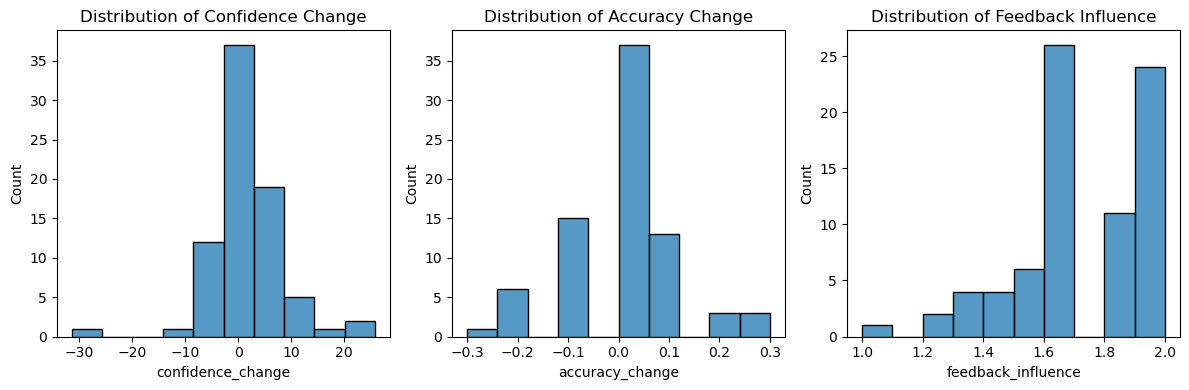

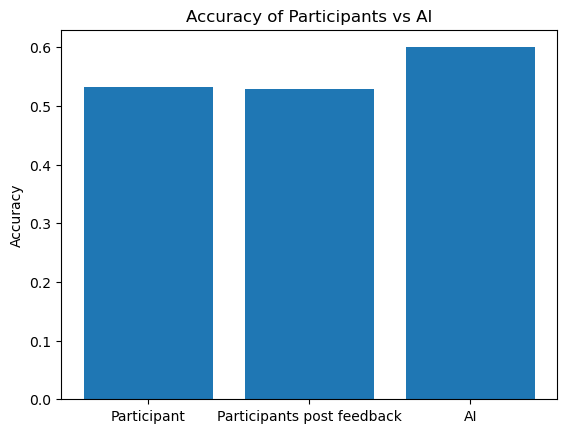

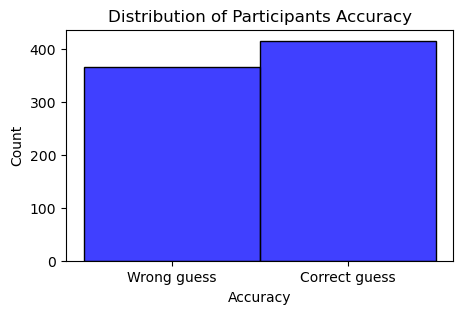

In [971]:
participant_summary = df2.groupby('participant_id').agg({
    'confidence_change': 'mean',
    'accuracy_change': 'mean',
    'feedback_influence': 'mean'
}).reset_index()

# plot the distribution of confidence, accuracy and feedback influence change
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
sns.histplot(data=participant_summary, x='confidence_change', bins=10)
plt.title("Distribution of Confidence Change")
plt.subplot(1, 3, 2)
sns.histplot(data=participant_summary, x='accuracy_change', bins=10)
plt.title("Distribution of Accuracy Change")
plt.subplot(1, 3, 3)
sns.histplot(data=participant_summary, x='feedback_influence', bins=10)
plt.title("Distribution of Feedback Influence")
plt.tight_layout()
plt.show()

# participants accuracy vs ai guess accuracy
AI_acc = (np.array(list(gt_guess_dict.values())) == np.array(list(feedb_guess_dict.values()))).sum()/10
participant_accuracy = (df2['initial_guess'] == df2['ground_truth']).sum()/len(df2)
participant_accuracy_aft = (df2['later_guess'] == df2['ground_truth']).sum()/len(df2)



# plot histogram of the accuracy of the participants and AI on the y axis
plt.bar(['Participant','Participants post feedback', 'AI'],[participant_accuracy,participant_accuracy_aft, AI_acc])
plt.ylabel("Accuracy")
plt.title("Accuracy of Participants vs AI")
plt.show()

# plot the distribution of the accuracy of the participants
plt.figure(figsize=(5,3))
sns.histplot((df2['initial_guess'] == df2['ground_truth']).astype(int), bins=2, kde=False, stat='count', discrete=True, color='blue')
plt.title("Distribution of Participants Accuracy")
plt.xticks([0, 1], ["Wrong guess", "Correct guess"])
plt.xlabel("Accuracy")
plt.ylabel("Count")
plt.show()
